In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")

Warning message:
"package 'DESeq2' was built under R version 4.2.2"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.2.1"

Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    exp

In [2]:
library(ggfortify)

Warning message:
"package 'ggfortify' was built under R version 4.2.2"


In [3]:
library(corrplot)

Warning message:
"package 'corrplot' was built under R version 4.2.1"
corrplot 0.92 loaded



In [4]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [5]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'
HCOLOR = '#E26A2C'
HCOLOR = '#984215'
 
HCOLOR_light = '#FDA65D'
PCOLOR = '#99cc99'
PCOLOR_light = '#aad5aa'

tpal = brewer.pal(5, "Purples")
gpal = brewer.pal(4, 'Dark2')
ann_colors = list(
    Timepoint = c('1'=tpal[1], '2'=tpal[2], '3'=tpal[3], 
                  '4'=tpal[4], '5'=tpal[5]),
    Group = c(P = PCOLOR_light, C = PRO_COLOR),
    treatment = c(ref = gpal[2], long.term=gpal[4])
)
#forder = ['med4 (AX)', 'med4 (CC)', '1A3 (CC)', '1A3 (AX)']
#fpal = [PCOLOR_light, PRO_COLOR, HCOLOR, HCOLOR_light,  ]


In [6]:
list.files('data')

[1] "A_axenic_proteome.txt"                                                                          
 [2] "A_axenic_proteome_norm.txt"                                                                     
 [3] "ALT_Axenic_DE.csv"                                                                              
 [4] "ALT_CC_DE.csv"                                                                                  
 [5] "ALT_coculture_DE.csv"                                                                           
 [6] "C_ALT_proteome.txt"                                                                             
 [7] "C_ALT_proteome_norm.txt"                                                                        
 [8] "C_PRO_proteome.txt"                                                                             
 [9] "C_PRO_proteome_norm.txt"                                                                        
[10] "Nov22_Processing.xlsx"                                                                          
[11] "P_axenic_proteome.txt"                                                                          
[12] "P_axenic_proteome_norm.txt"                                                                     
[13] "uniprot-compressed_true_download_true_fields_accession_2Cid_2Cprotei-2023.01.11-12.43.22.99.txt"

In [7]:

dfA = read.csv(file.path('data', 'P_axenic_proteome_norm.txt'), sep='\t', comment.char = '#' )
dfC = read.csv(file.path('data', 'C_PRO_proteome_norm.txt'), sep='\t', comment.char = '#'  )


In [8]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'MED4_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'MED4', 'MED4_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

In [9]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)


In [10]:
names(dfA)
names(dfC)

[1] "P1_1"                             "P1_2"                            
 [3] "P1_3"                             "P2_1"                            
 [5] "P2_2"                             "P2_3"                            
 [7] "P3_1"                             "P3_2"                            
 [9] "P3_3"                             "P5_1"                            
[11] "P5_2"                             "P5_3"                            
[13] "Species"                          "Protein.Decoy.Contaminant.Target"
[15] "Number.of.Peptides"               "Number.of.Unique.Peptides"       
[17] "Number.of.PSMs"                   "Sequence.Coverage.Fraction"      
[19] "name"                             "protein_id"                      
[21] "Unique.Peptides"                  "Sequence.Coverage"

[1] "C1_1"                             "C1_2"                            
 [3] "C1_3"                             "C2_1"                            
 [5] "C2_2"                             "C2_3"                            
 [7] "C3_1"                             "C3_2"                            
 [9] "C3_3"                             "C4_1"                            
[11] "C4_2"                             "C4_3"                            
[13] "C5_1"                             "C5_2"                            
[15] "C5_3"                             "Species"                         
[17] "Protein.Decoy.Contaminant.Target" "Number.of.Peptides"              
[19] "Number.of.Unique.Peptides"        "Number.of.PSMs"                  
[21] "Sequence.Coverage.Fraction"       "name"                            
[23] "protein_id"                       "Sequence.Coverage"               
[25] "Unique.Peptides"

In [34]:
mdf = bind_rows(
    pivot_longer(dfA, cols = c('P1_1','P1_2','P1_3','P2_1','P2_2','P2_3','P3_1','P3_2','P3_3','P5_1','P5_2','P5_3')
                 , names_to = 'Sample', values_to = 'Intensity'),
    pivot_longer(dfC, cols = starts_with('C'), names_to = 'Sample', values_to = 'Intensity')
)


In [35]:
#mdf = left_join(mdf, hpath_df_to_export, by='protein_id')

In [36]:
mdf = mdf %>% 
   mutate(Group = substr(mdf$Sample, 1,1)) %>%
   mutate(Timepoint = substr(mdf$Sample, 2,2)) %>%
   mutate(replicate = substr(mdf$Sample, 4,4)) %>%
   mutate(Group.Timepoint = substr(mdf$Sample, 1,2)) 

In [37]:
head(mdf)

Species Protein.Decoy.Contaminant.Target Number.of.Peptides
1 PRO     TRUE                             105               
2 PRO     TRUE                             105               
3 PRO     TRUE                             105               
4 PRO     TRUE                             105               
5 PRO     TRUE                             105               
6 PRO     TRUE                             105               
  Number.of.Unique.Peptides Number.of.PSMs Sequence.Coverage.Fraction
1 105                       2739           0.36115                   
2 105                       2739           0.36115                   
3 105                       2739           0.36115                   
4 105                       2739           0.36115                   
5 105                       2739           0.36115                   
6 105                       2739           0.36115                   
  name                            protein_id    
1 photosystem I core protein PsaA WP_011133152.1
2 photosystem I core protein PsaA WP_011133152.1
3 photosystem I core protein PsaA WP_011133152.1
4 photosystem I core protein PsaA WP_011133152.1
5 photosystem I core protein PsaA WP_011133152.1
6 photosystem I core protein PsaA WP_011133152.1
  Unique.Peptides                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [38]:
names(mdf)

[1] "Species"                          "Protein.Decoy.Contaminant.Target"
 [3] "Number.of.Peptides"               "Number.of.Unique.Peptides"       
 [5] "Number.of.PSMs"                   "Sequence.Coverage.Fraction"      
 [7] "name"                             "protein_id"                      
 [9] "Unique.Peptides"                  "Sequence.Coverage"               
[11] "Sample"                           "Intensity"                       
[13] "Group"                            "Timepoint"                       
[15] "replicate"                        "Group.Timepoint"

Warning message:
"Setting row names on a tibble is deprecated."


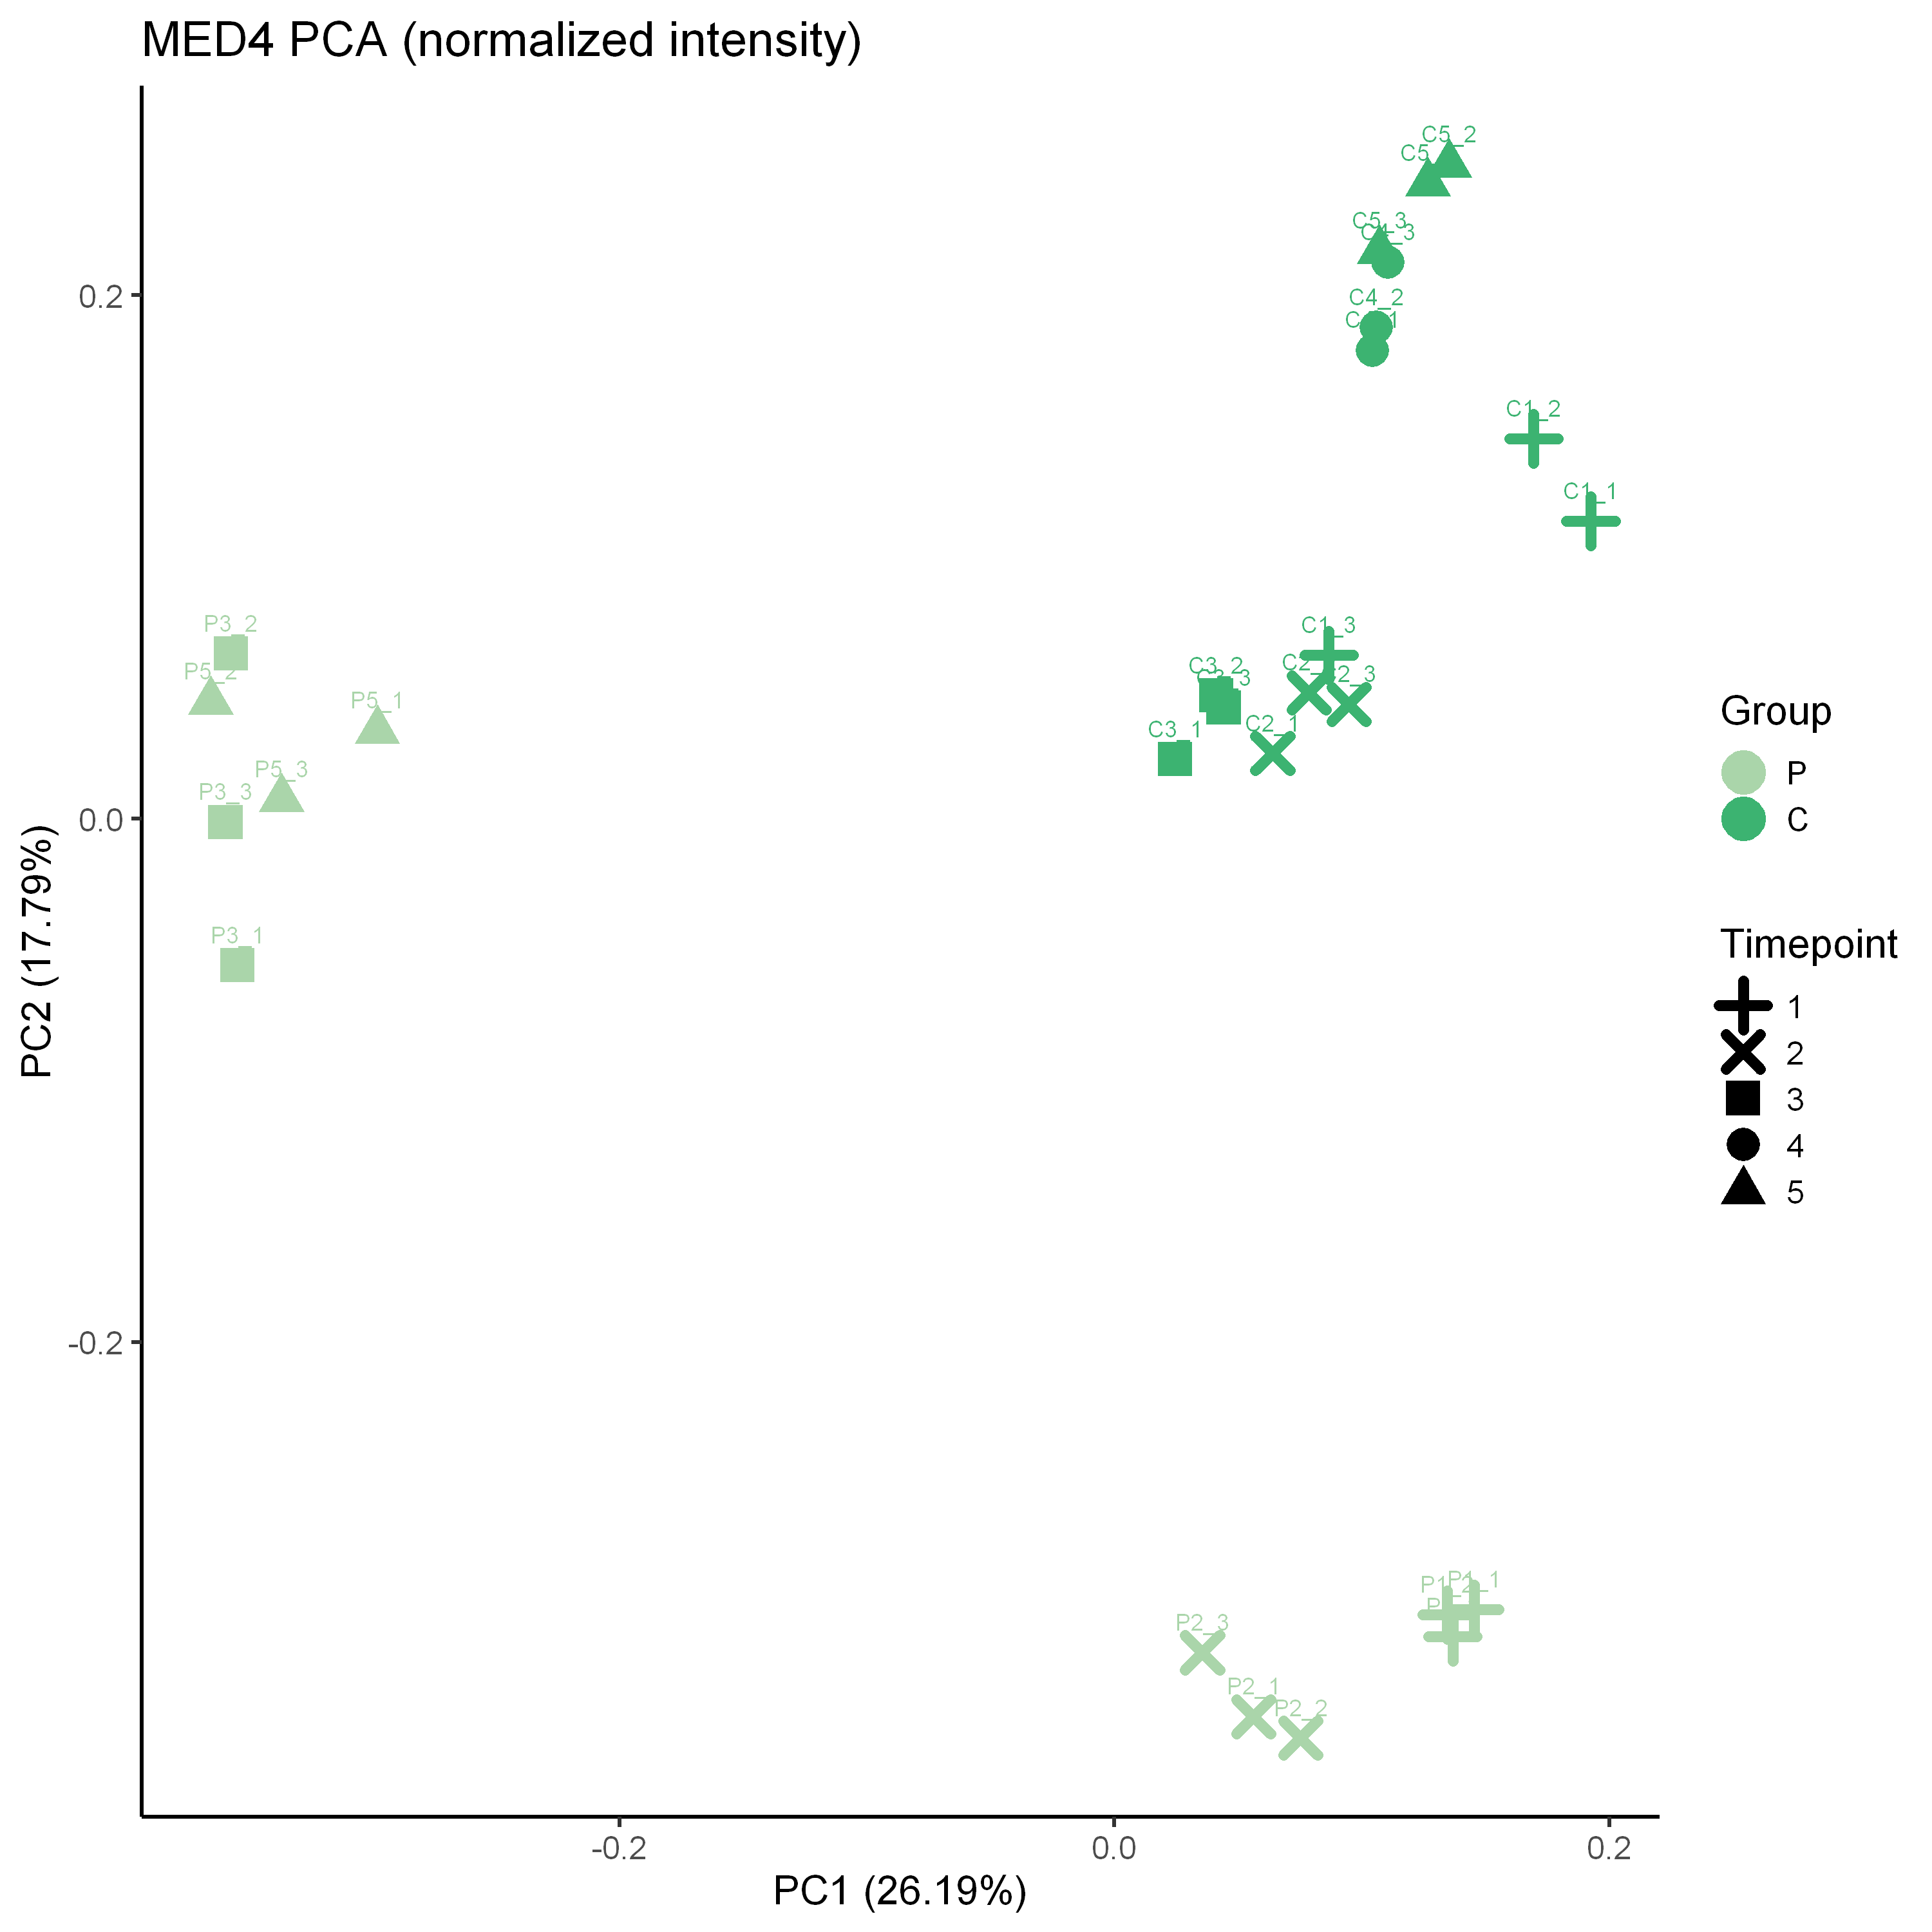

In [39]:
df = pivot_wider(
    mdf, id_cols=c('Sample', 'Group','Timepoint','replicate','Group.Timepoint'), 
    names_from='protein_id', values_from = 'Intensity')
X = df %>% select(starts_with('WP_')) 
row.names(X) = df$Sample
#X
#    as.data.frame
pca_res <- prcomp(X, scale. = TRUE)
p = autoplot(pca_res, data=df, colour='Group', shape='Timepoint', label=TRUE, size =4, stroke=3,
         label.vjust = -1.3, label.size = 3) +
  scale_color_manual(values = ann_colors$Group) +
  scale_shape_manual(values=c(3,4, 15,16,17))+
  ggtitle("MED4 PCA (normalized intensity)") +
  theme_classic(base_size = 15)  

p$layers[[1]]$aes_params$stroke <- 3
p

Warning message:
"Setting row names on a tibble is deprecated."


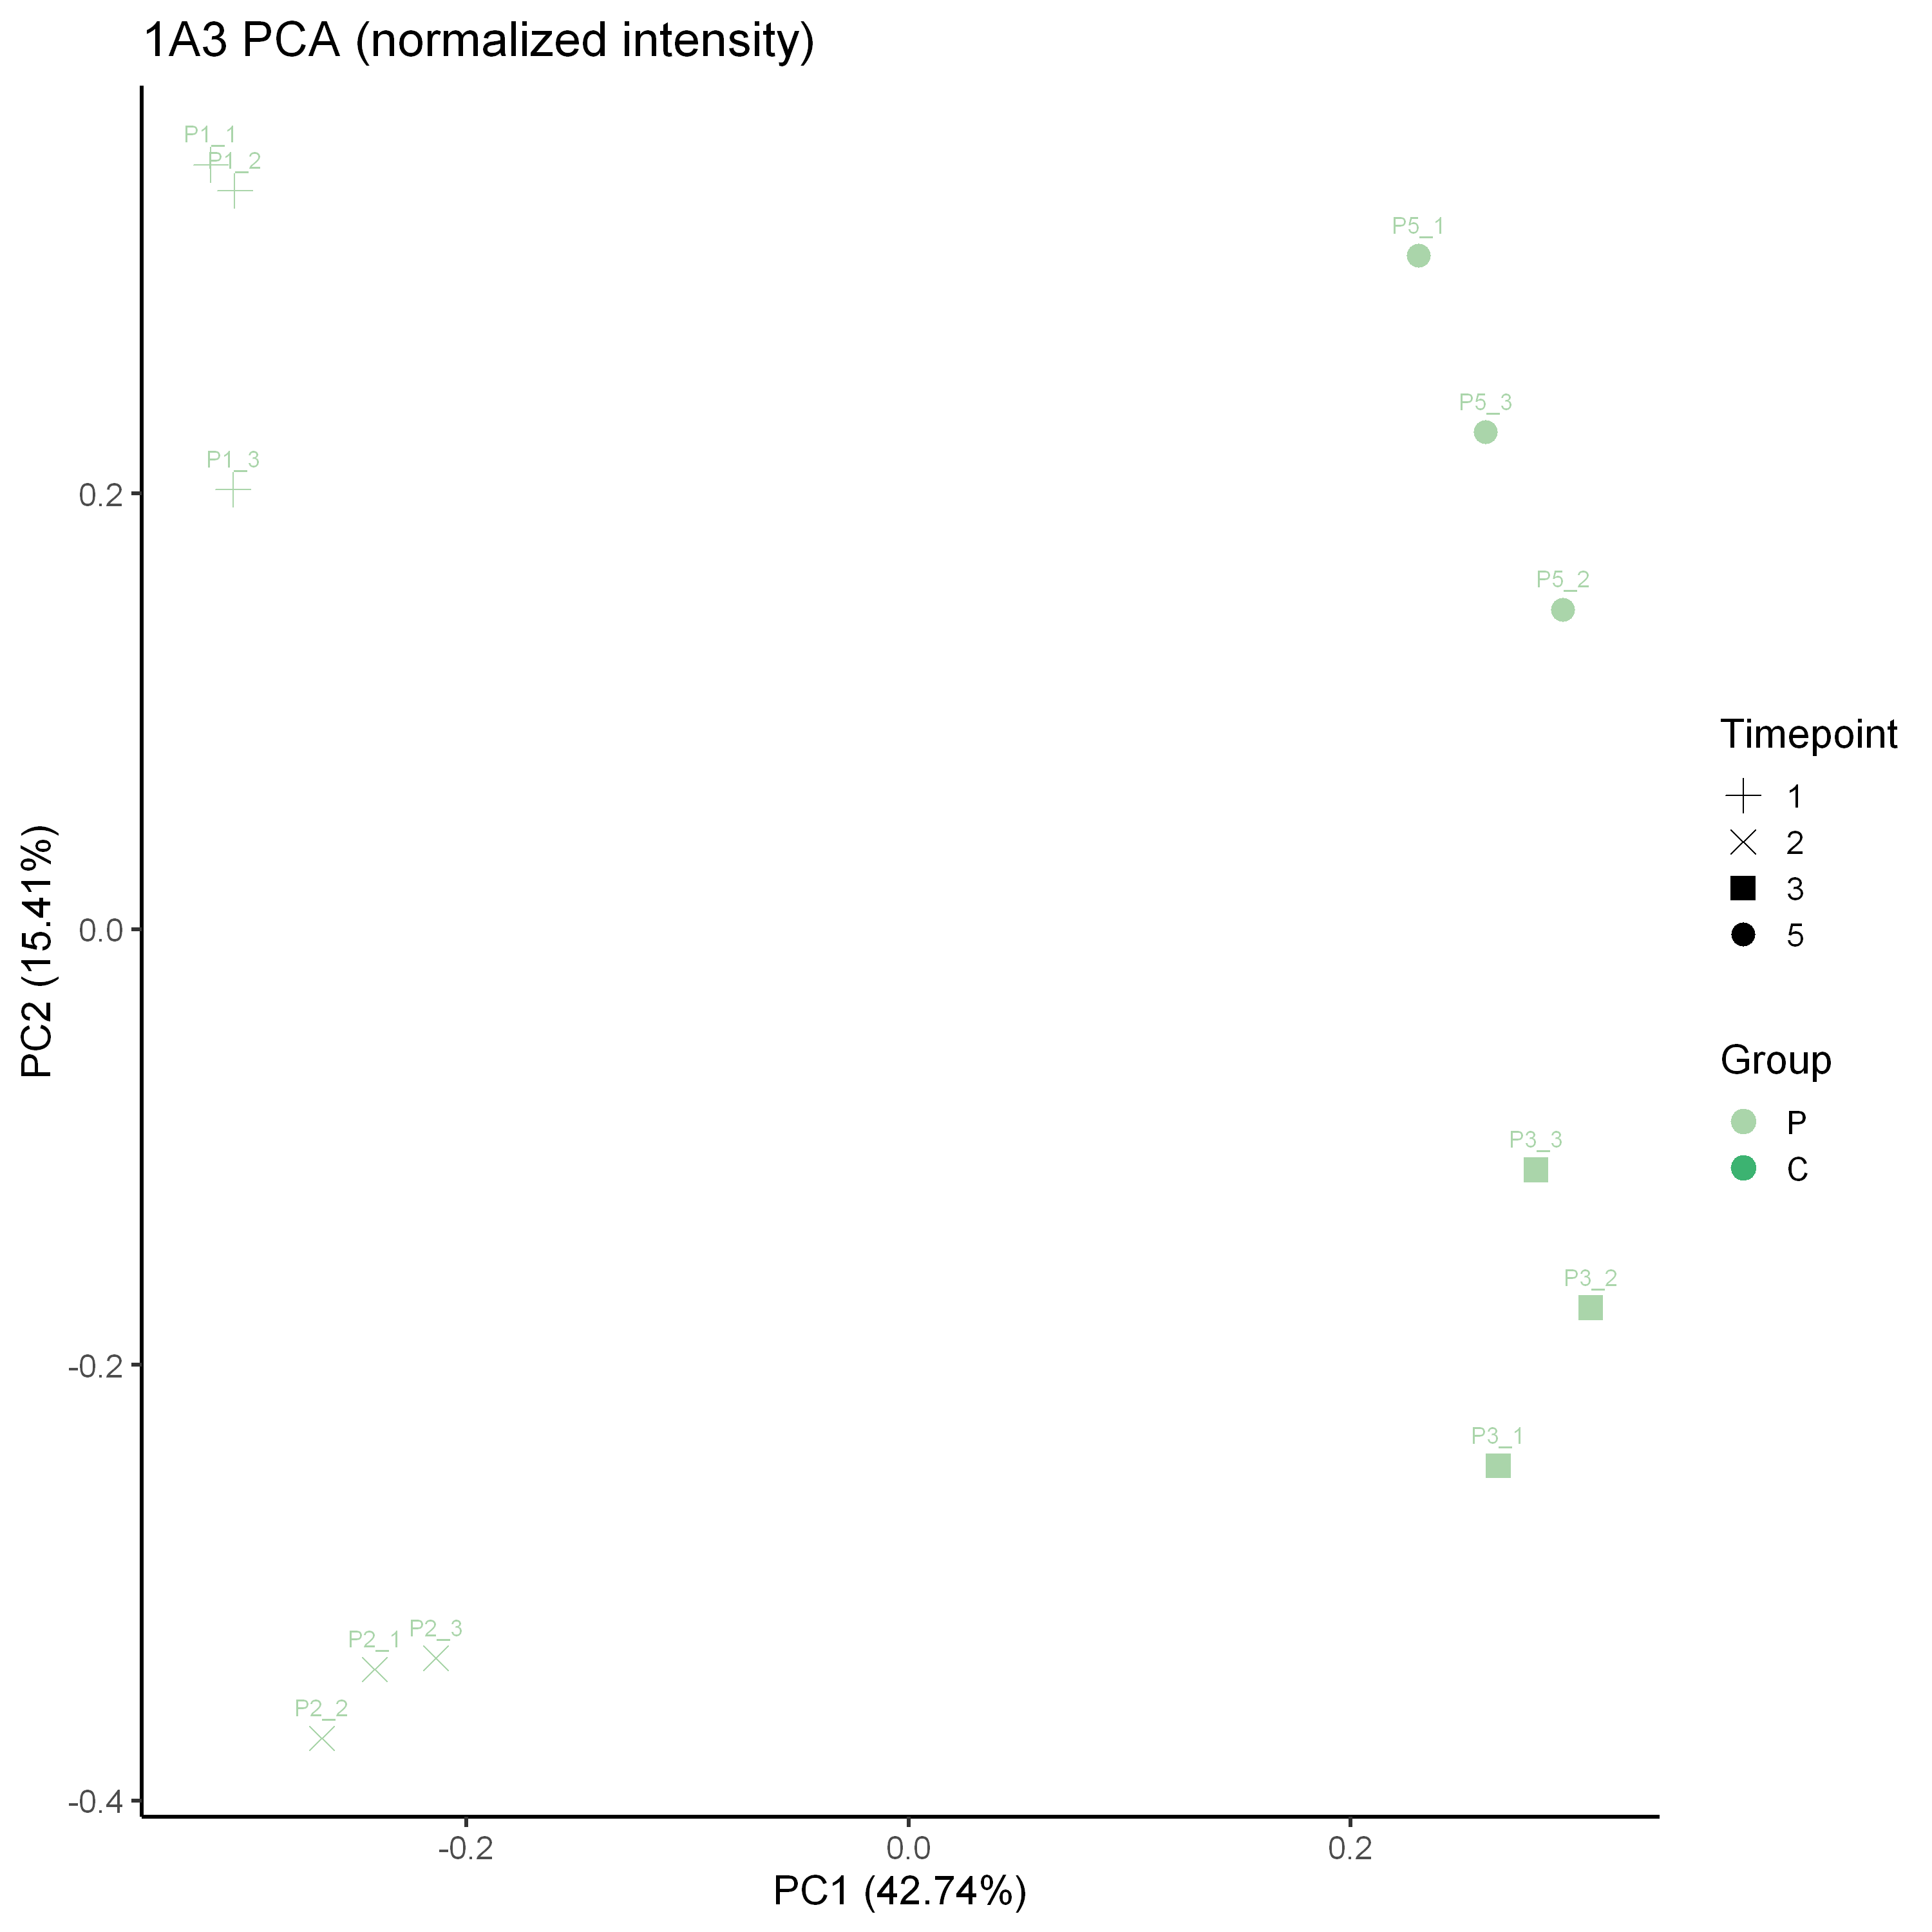

In [40]:
df = pivot_wider(
    mdf, id_cols=c('Sample', 'Group','Timepoint','replicate','Group.Timepoint'), 
    names_from='protein_id', values_from = 'Intensity') 
df = df %>% filter(Group=='P')
X = df %>% select(starts_with('WP_')) 
row.names(X) = df$Sample
#X
#    as.data.frame
pca_res <- prcomp(X, scale. = TRUE)
autoplot(pca_res, data=df, colour='Group', shape='Timepoint', label=TRUE, size =4, 
         label.vjust = -1.3, label.size = 3) +
  scale_color_manual(values = ann_colors$Group) +
  scale_shape_manual(values=c(3,4, 15,16,17))+
  ggtitle("1A3 PCA (normalized intensity)") +
  theme_classic(base_size = 15)  


Warning message:
"Setting row names on a tibble is deprecated."


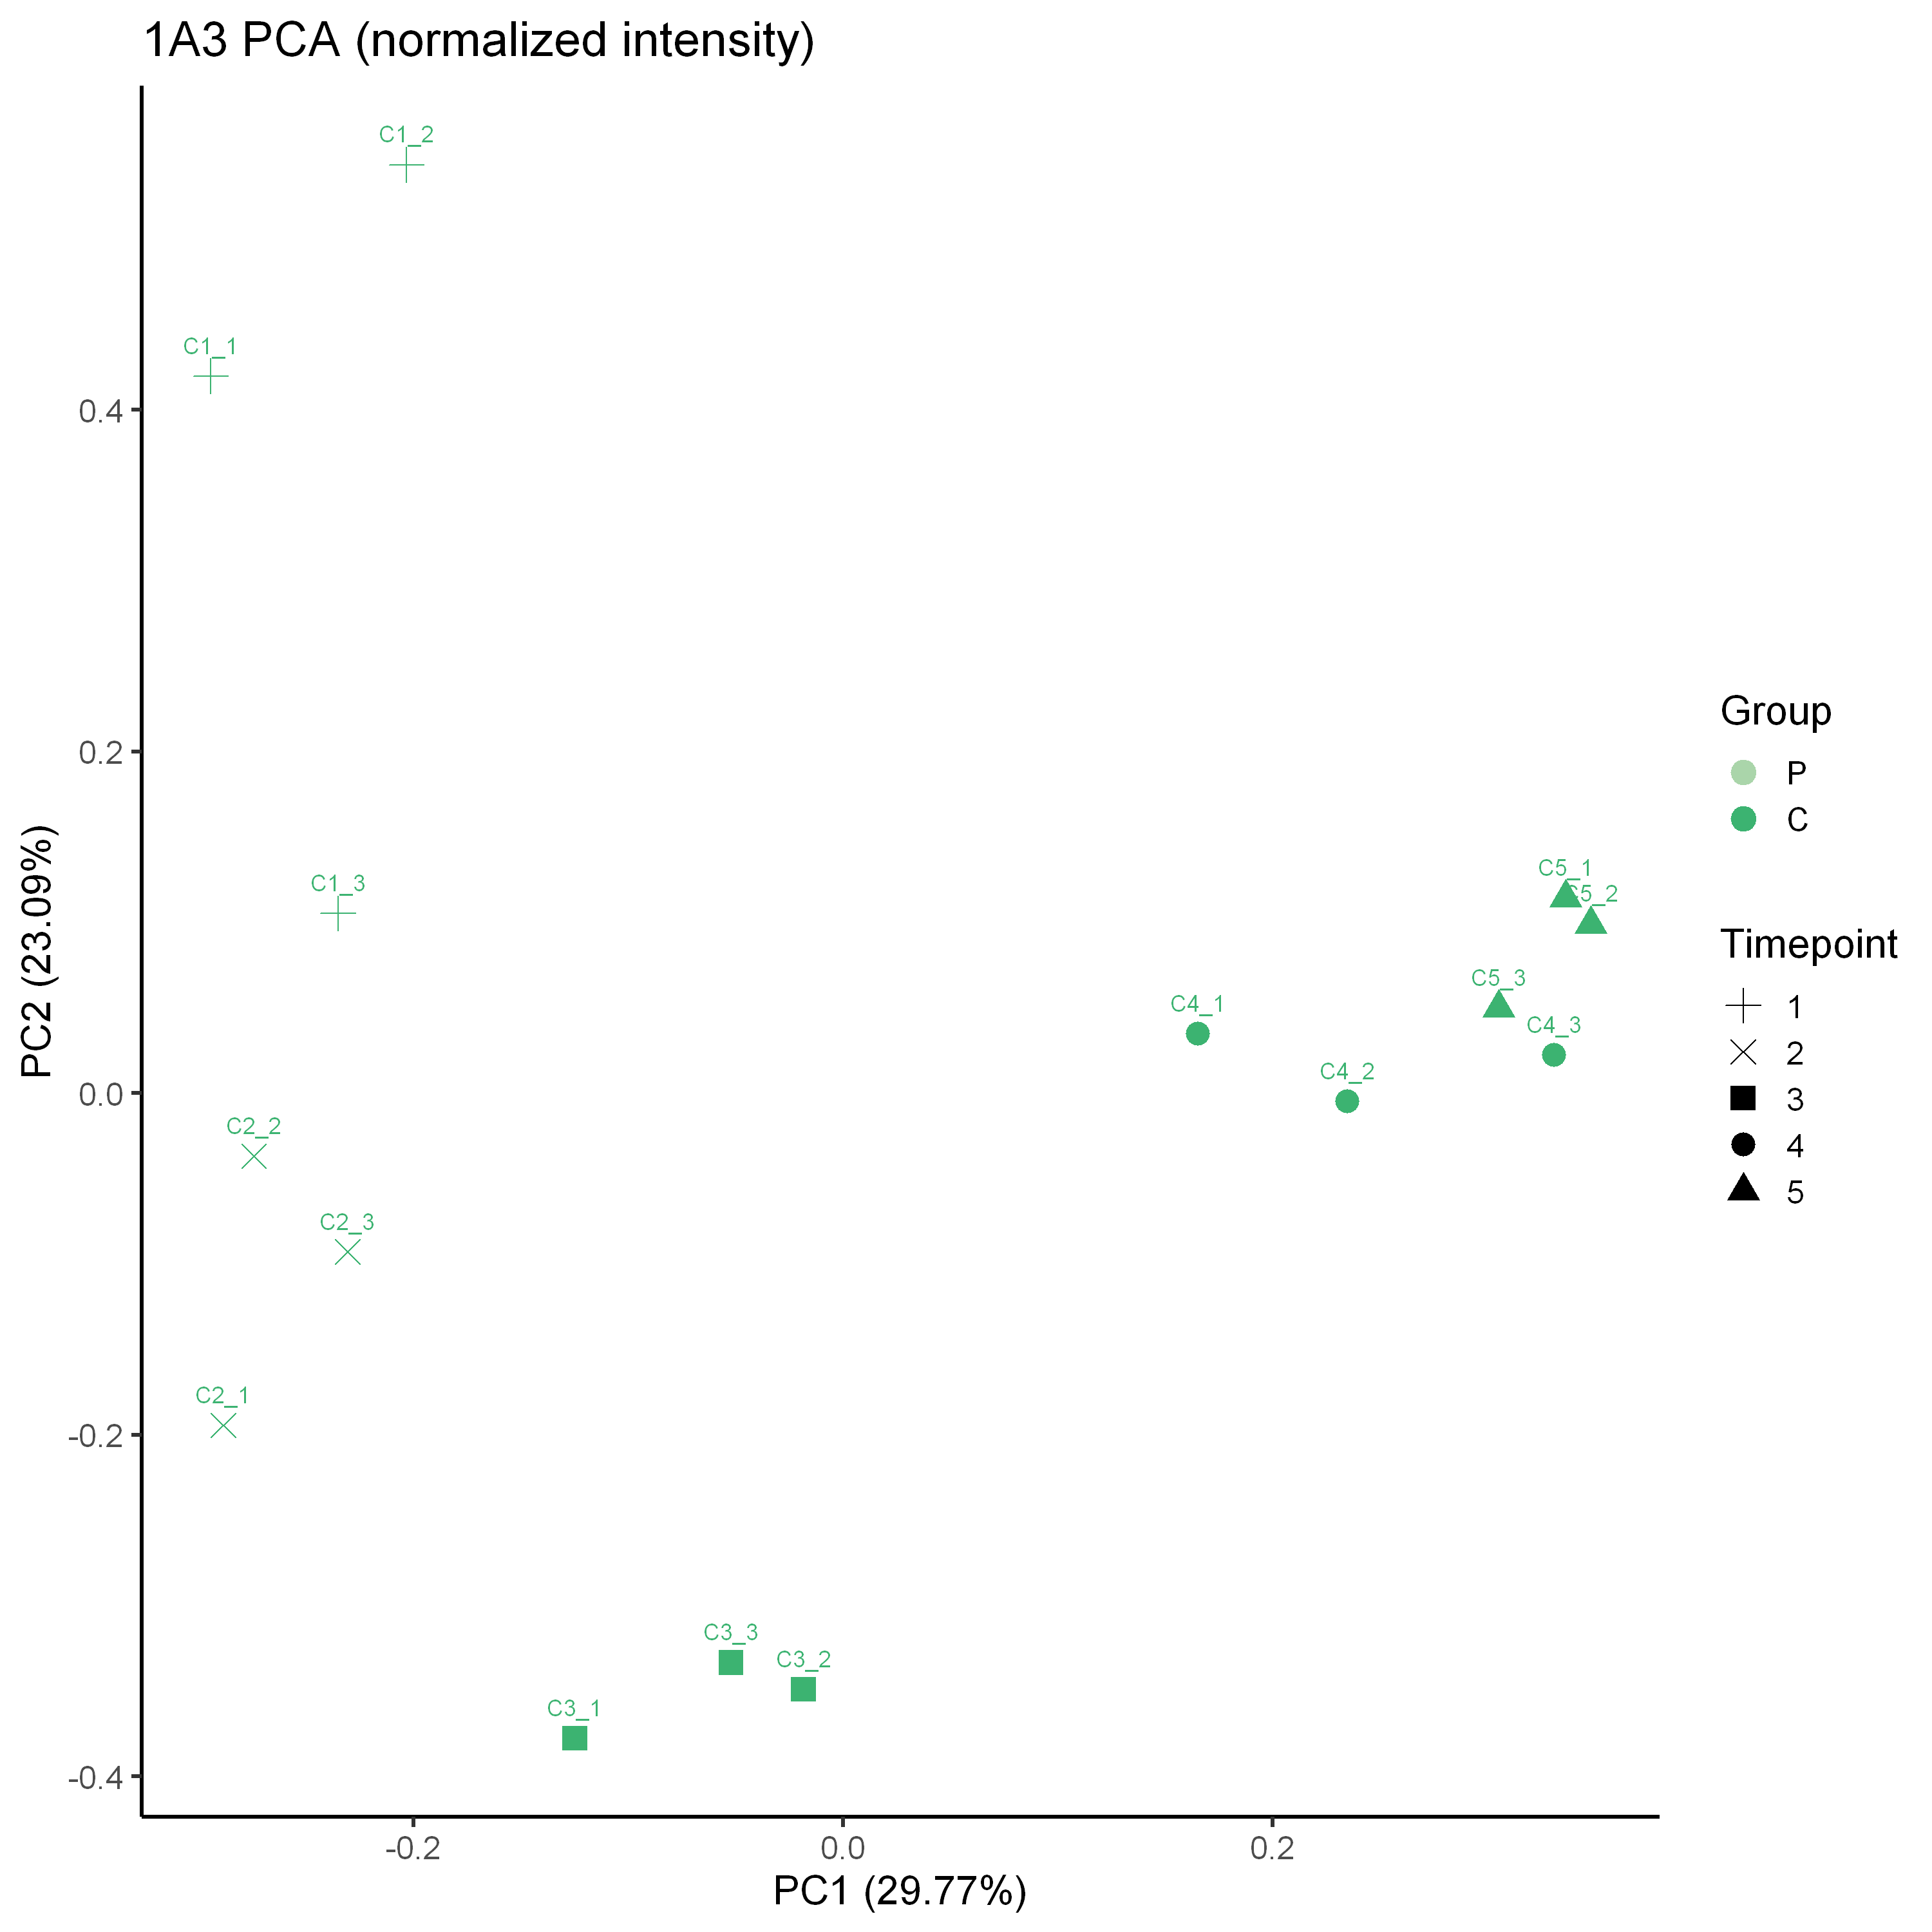

In [41]:
df = pivot_wider(
    mdf, id_cols=c('Sample', 'Group','Timepoint','replicate','Group.Timepoint'), 
    names_from='protein_id', values_from = 'Intensity') 
df = df %>% filter(Group=='C')
X = df %>% select(starts_with('WP_')) 
row.names(X) = df$Sample
#X
#    as.data.frame
pca_res <- prcomp(X, scale. = TRUE)
autoplot(pca_res, data=df, colour='Group', shape='Timepoint', label=TRUE, size =4, 
         label.vjust = -1.3, label.size = 3) +
  scale_color_manual(values = ann_colors$Group) +
  scale_shape_manual(values=c(3,4, 15,16,17))+
  ggtitle("1A3 PCA (normalized intensity)") +
  theme_classic(base_size = 15)  


In [42]:
names(mdf)

[1] "Species"                          "Protein.Decoy.Contaminant.Target"
 [3] "Number.of.Peptides"               "Number.of.Unique.Peptides"       
 [5] "Number.of.PSMs"                   "Sequence.Coverage.Fraction"      
 [7] "name"                             "protein_id"                      
 [9] "Unique.Peptides"                  "Sequence.Coverage"               
[11] "Sample"                           "Intensity"                       
[13] "Group"                            "Timepoint"                       
[15] "replicate"                        "Group.Timepoint"

`summarise()` has grouped output by 'protein_id'. You can override using the `.groups` argument.


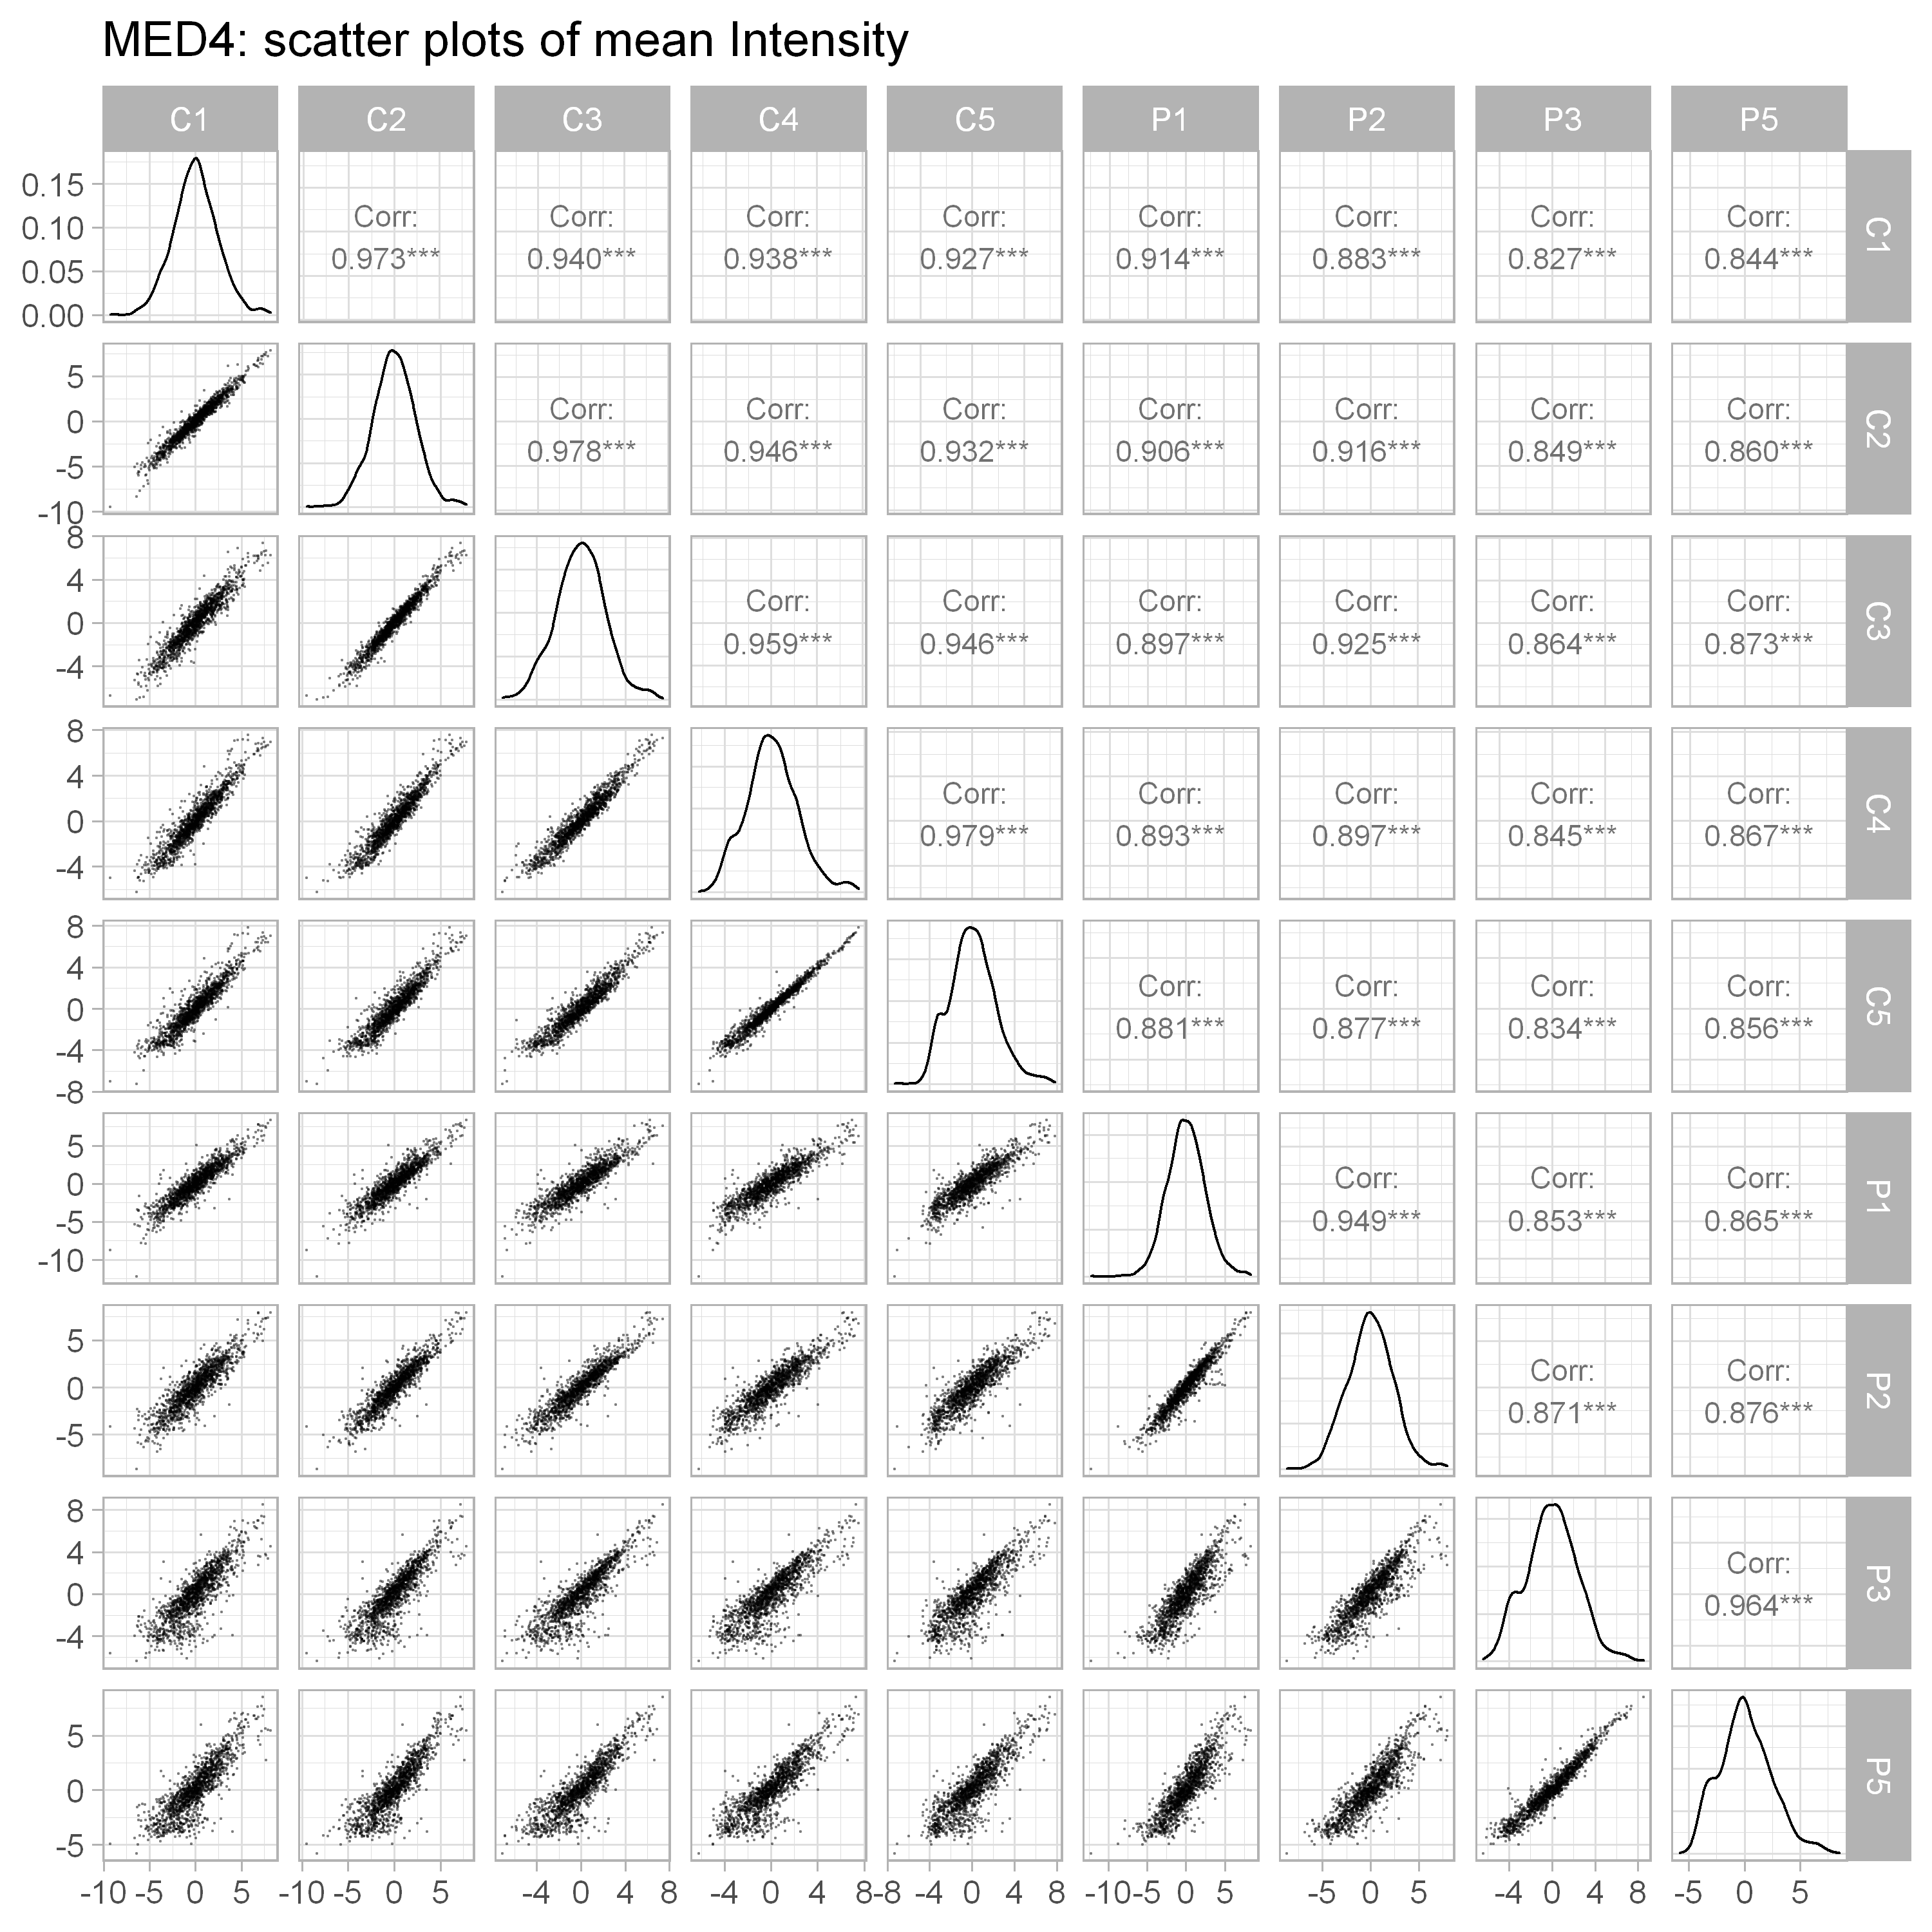

In [43]:
mdf %>%
   group_by(protein_id, Group.Timepoint)  %>%
   summarise(mean_Intensity = mean(Intensity)) %>%
   pivot_wider(names_from = Group.Timepoint, values_from = mean_Intensity) %>%
ggpairs(columns = c(2:10), lower = list(continuous = wrap("points", alpha = 0.3, size=0.1)),
        title='MED4: scatter plots of mean Intensity'
       ) +
  theme_light(base_size = 15)
  
   

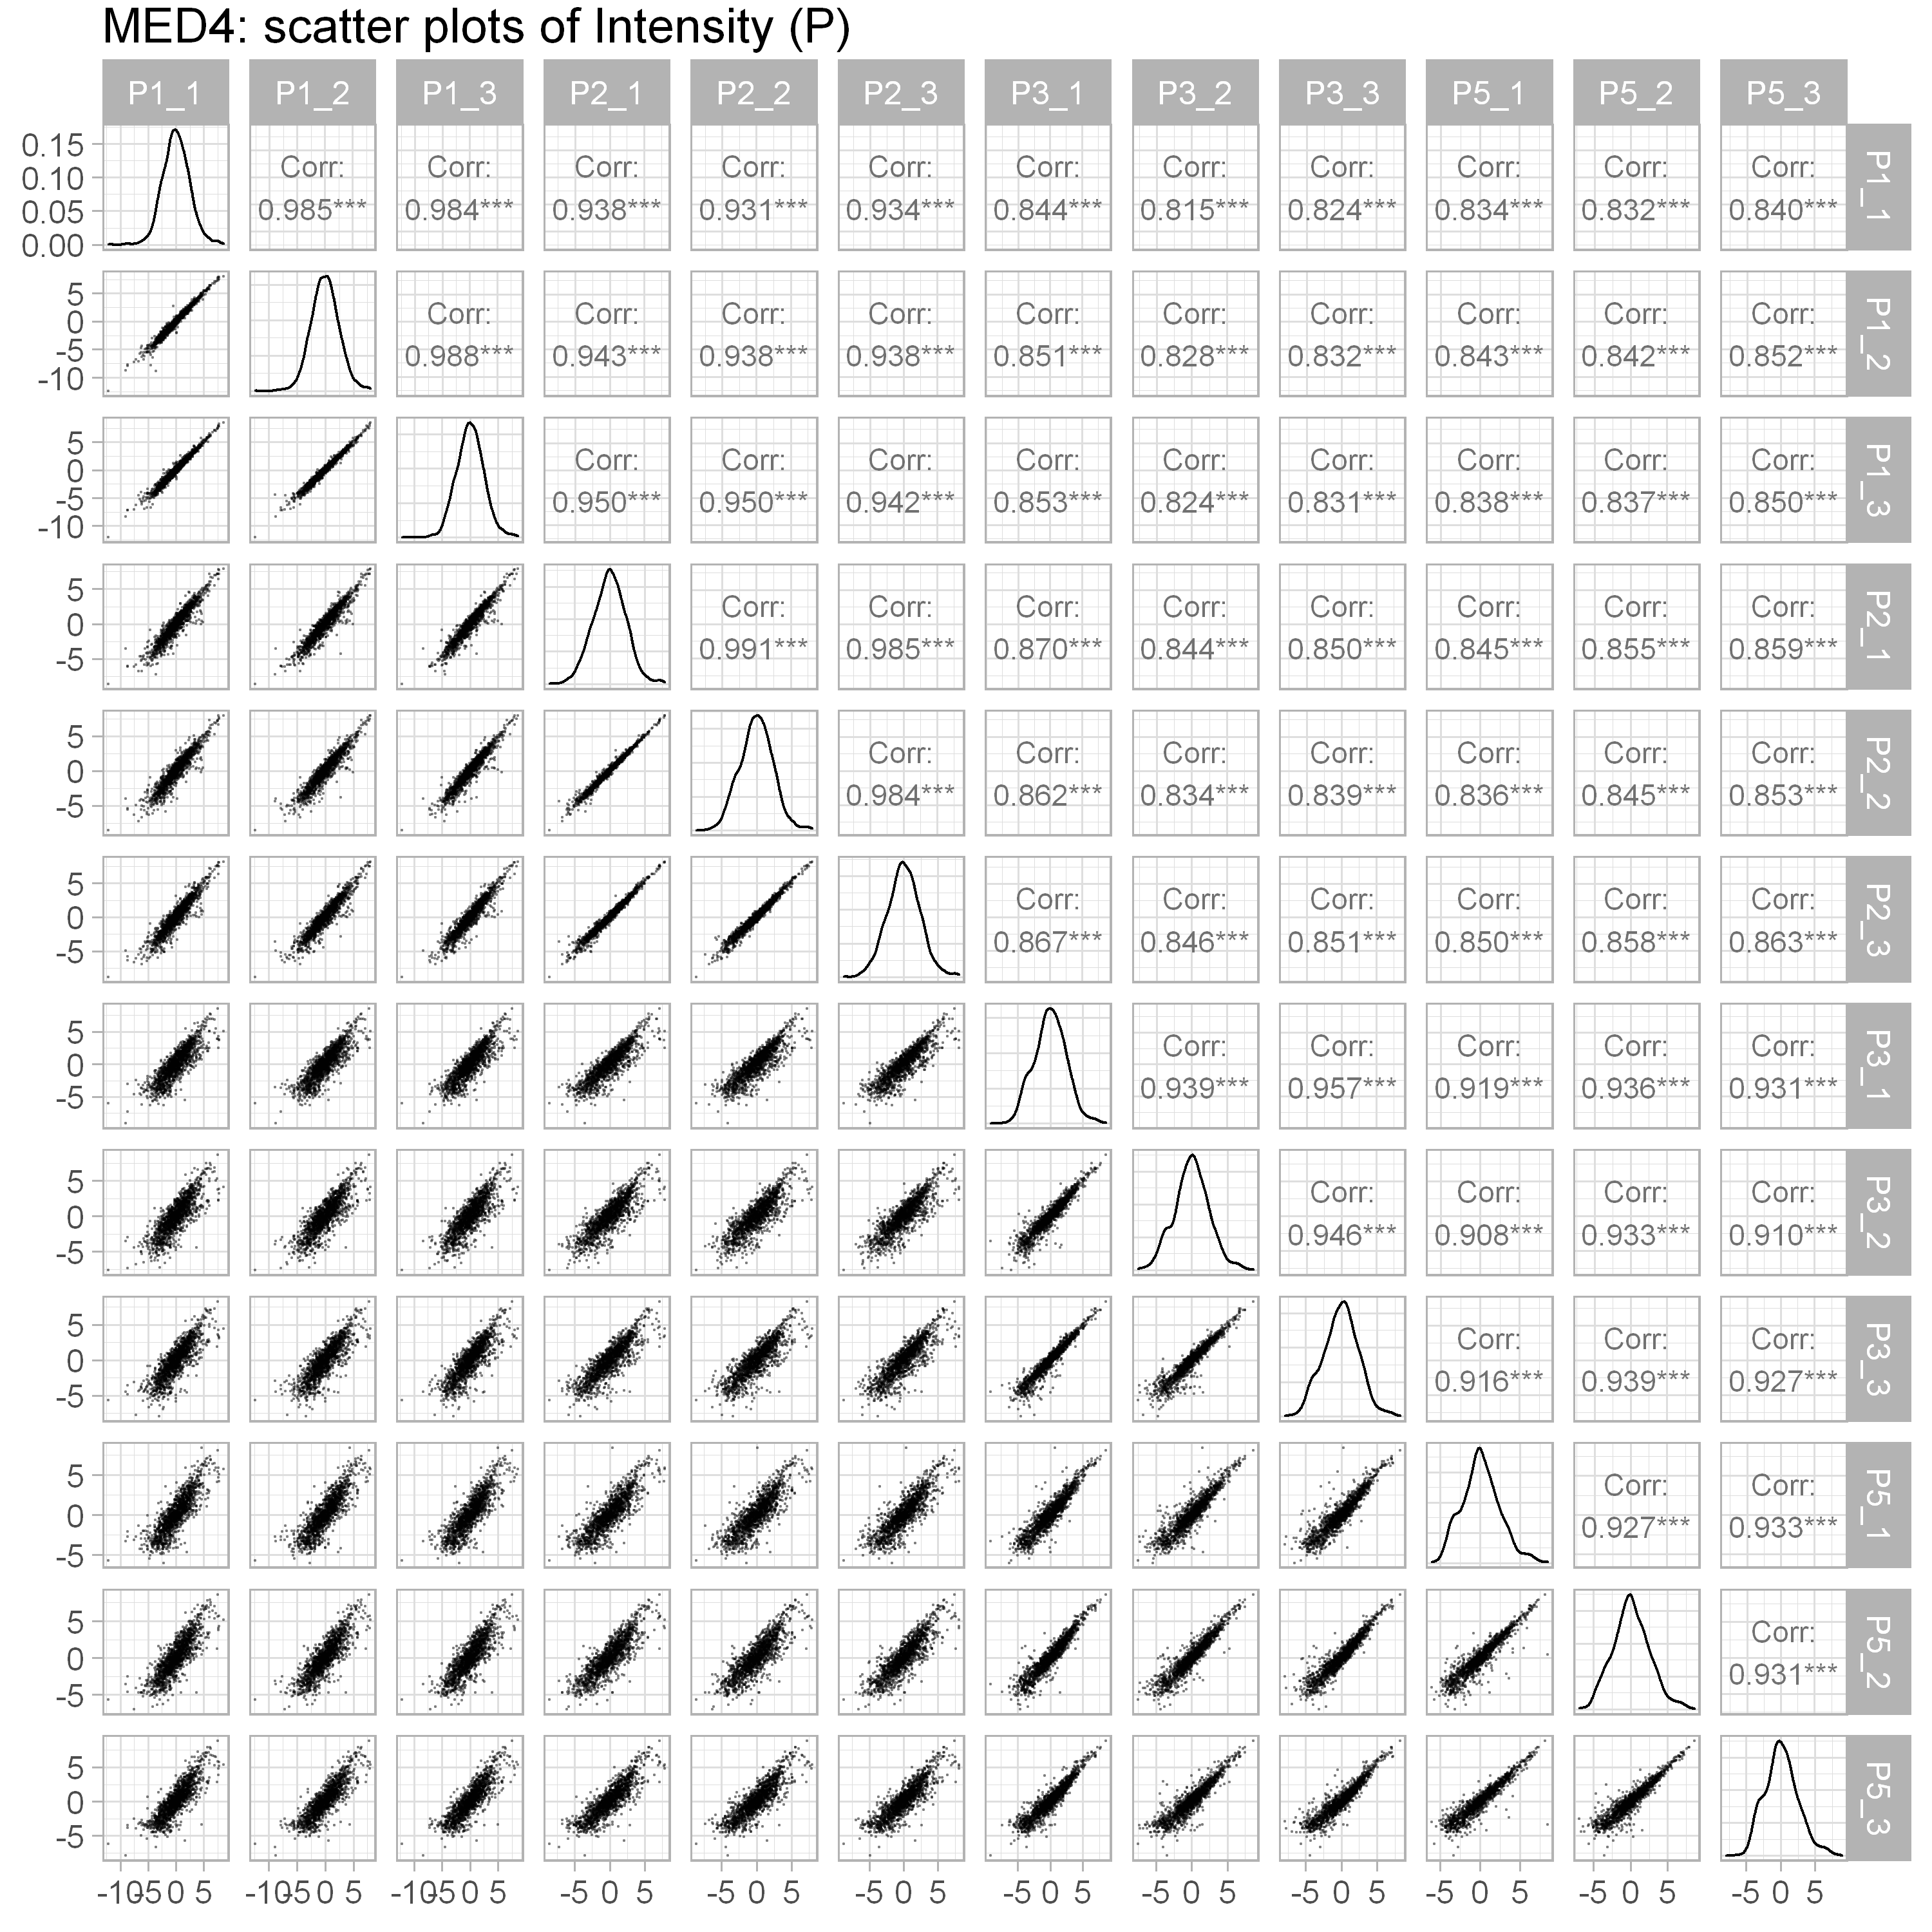

In [44]:
mdf %>%

   filter(Group == 'P') %>%
   select(Sample, Intensity, protein_id) %>%
   #group_by(protein_id, Group.Timepoint)  %>%
   #summarise(mean_Intensity = mean(Intensity)) %>%
   pivot_wider(names_from = Sample, values_from = Intensity) %>%
ggpairs(columns = c(2:13), lower = list(continuous = wrap("points", alpha = 0.3, size=0.1)),
        title='MED4: scatter plots of Intensity (P)'
       ) +
  theme_light(base_size = 15)
  
   

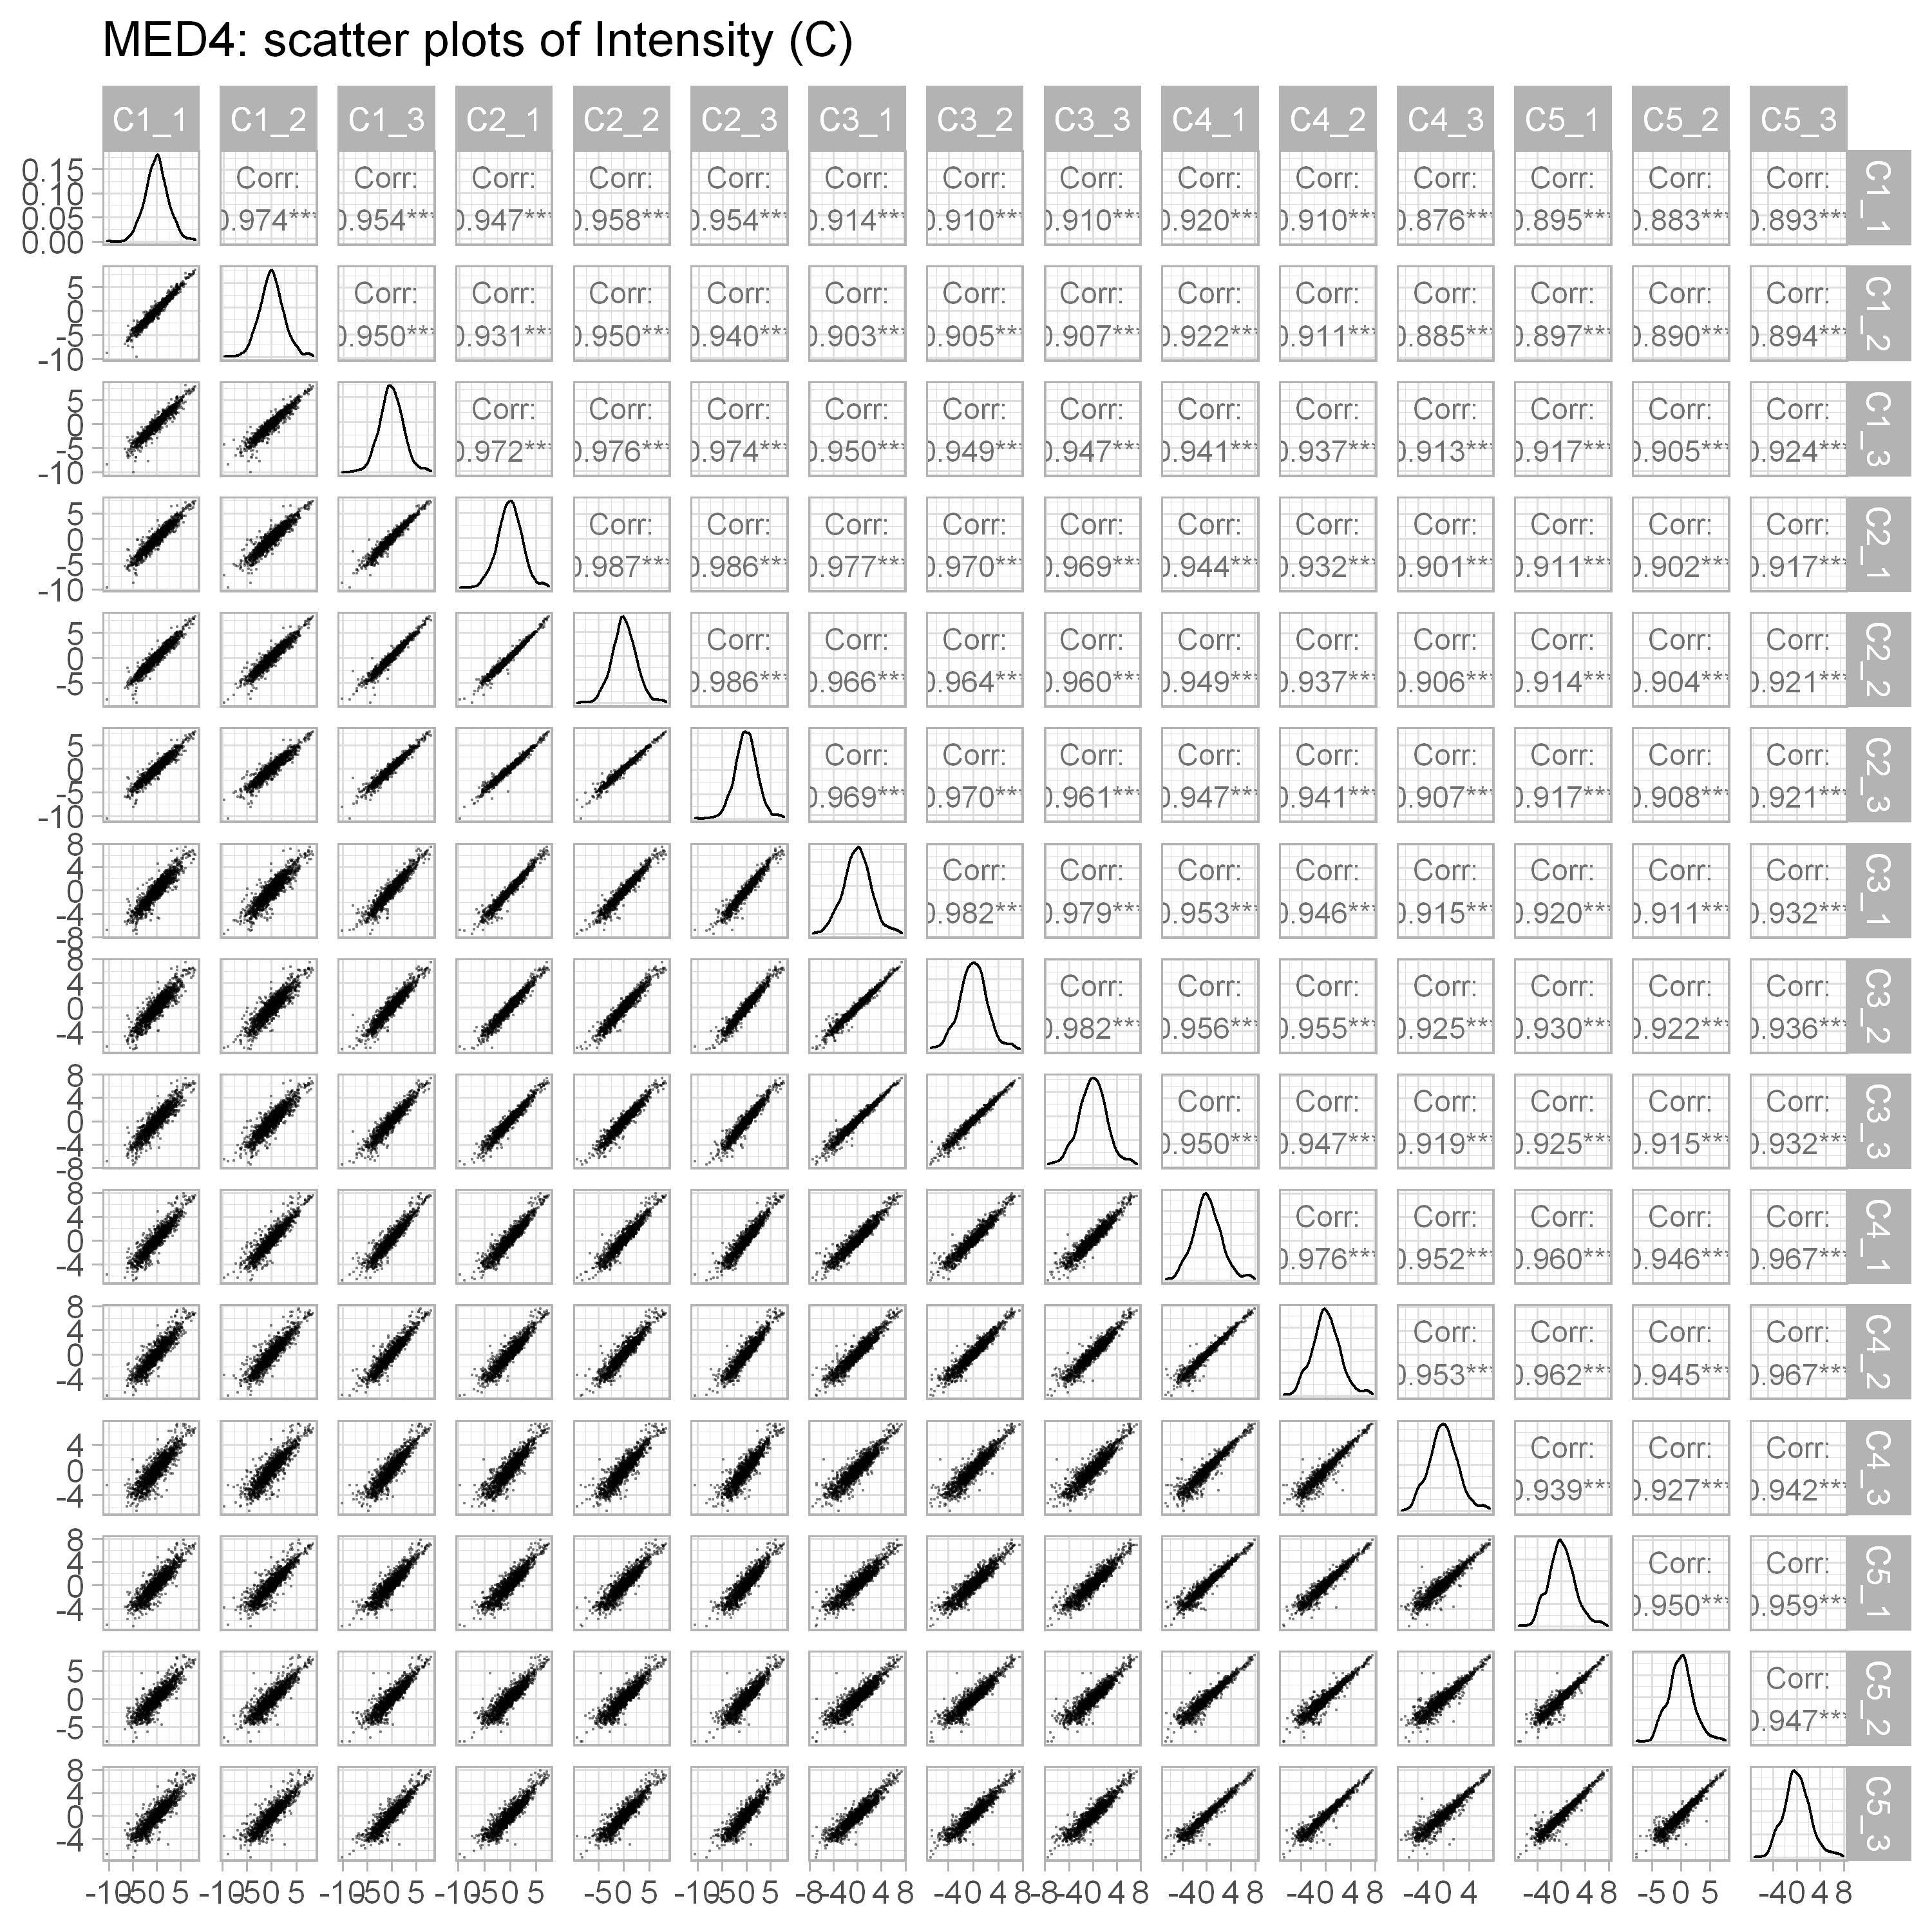

In [45]:
mdf %>%

   filter(Group == 'C') %>%
   select(Sample, Intensity, protein_id) %>%
   #group_by(protein_id, Group.Timepoint)  %>%
   #summarise(mean_Intensity = mean(Intensity)) %>%
   pivot_wider(names_from = Sample, values_from = Intensity) %>%
ggpairs(columns = c(2:16), lower = list(continuous = wrap("points", alpha = 0.3, size=0.1)),
        title='MED4: scatter plots of Intensity (C)'
       ) +
  theme_light(base_size = 15)
  
   

In [46]:
cdf = pivot_wider(
    mdf, id_cols=c('protein_id'), 
    names_from='Sample', values_from = 'Intensity') %>% column_to_rownames('protein_id')

head(cdf)

P1_1      P1_2      P1_3      P2_1     P2_2     P2_3    
WP_011133152.1 7.7386408 7.6203499 7.8481503 7.722785 7.688363 8.083828
WP_011132825.1 4.4848280 4.6353226 4.4711151 4.201722 4.254651 4.773293
WP_011132757.1 0.7538214 0.9428101 0.8554344 1.582704 1.379659 1.445036
WP_011132404.1 2.2156134 2.5591640 2.3943443 3.128482 2.948134 3.065042
WP_011132401.1 4.0907907 4.3361244 4.2792282 3.850692 4.240432 4.517277
WP_011132785.1 3.0735979 3.0963993 2.9183502 2.796327 2.790843 2.911247
               P3_1       P3_2      P3_3      P5_1     ⋯ C2_3      C3_1    
WP_011133152.1 3.64851284 3.8568907 3.3048029 4.251069 ⋯ 7.0471382 5.907307
WP_011132825.1 5.85159779 5.7096605 5.7461901 6.197679 ⋯ 5.4867344 5.422384
WP_011132757.1 0.07066059 0.5794344 0.7629499 1.701085 ⋯ 0.1382465 1.484032
WP_011132404.1 3.25779247 3.4348249 2.9038401 2.852347 ⋯ 2.9582615 3.158932
WP_011132401.1 5.76839542 5.4389696 5.6560545 5.905623 ⋯ 4.5998344 4.815557
WP_011132785.1 1.70523548 1.3716097 1.2683039 1.072383 ⋯ 2.1962414 2.331039
               C3_2     C3_3     C4_1     C4_2     C4_3     C5_1     C5_2    
WP_011133152.1 5.681726 6.013789 6.442933 6.190625 5.869986 5.631097 5.622811
WP_011132825.1 5.119414 5.350366 5.525350 5.311805 5.217323 5.225019 5.131183
WP_011132757.1 1.172555 1.623282 1.796254 1.768653 1.249804 2.396539 1.805673
WP_011132404.1 3.071734 3.098945 1.987695 2.223659 2.166729 1.655236 1.797973
WP_011132401.1 4.387527 4.878127 4.769757 5.128566 4.540539 4.226443 4.322953
WP_011132785.1 2.069285 2.243299 2.438903 2.340068 1.867512 2.295159 2.215280
               C5_3    
WP_011133152.1 5.790801
WP_011132825.1 5.484208
WP_011132757.1 1.867908
WP_011132404.1 1.505015
WP_011132401.1 4.435864
WP_011132785.1 2.061799

In [47]:
spearman_cor = cor(cdf, method='spearman')
pearson_cor = cor(cdf, method='pearson')


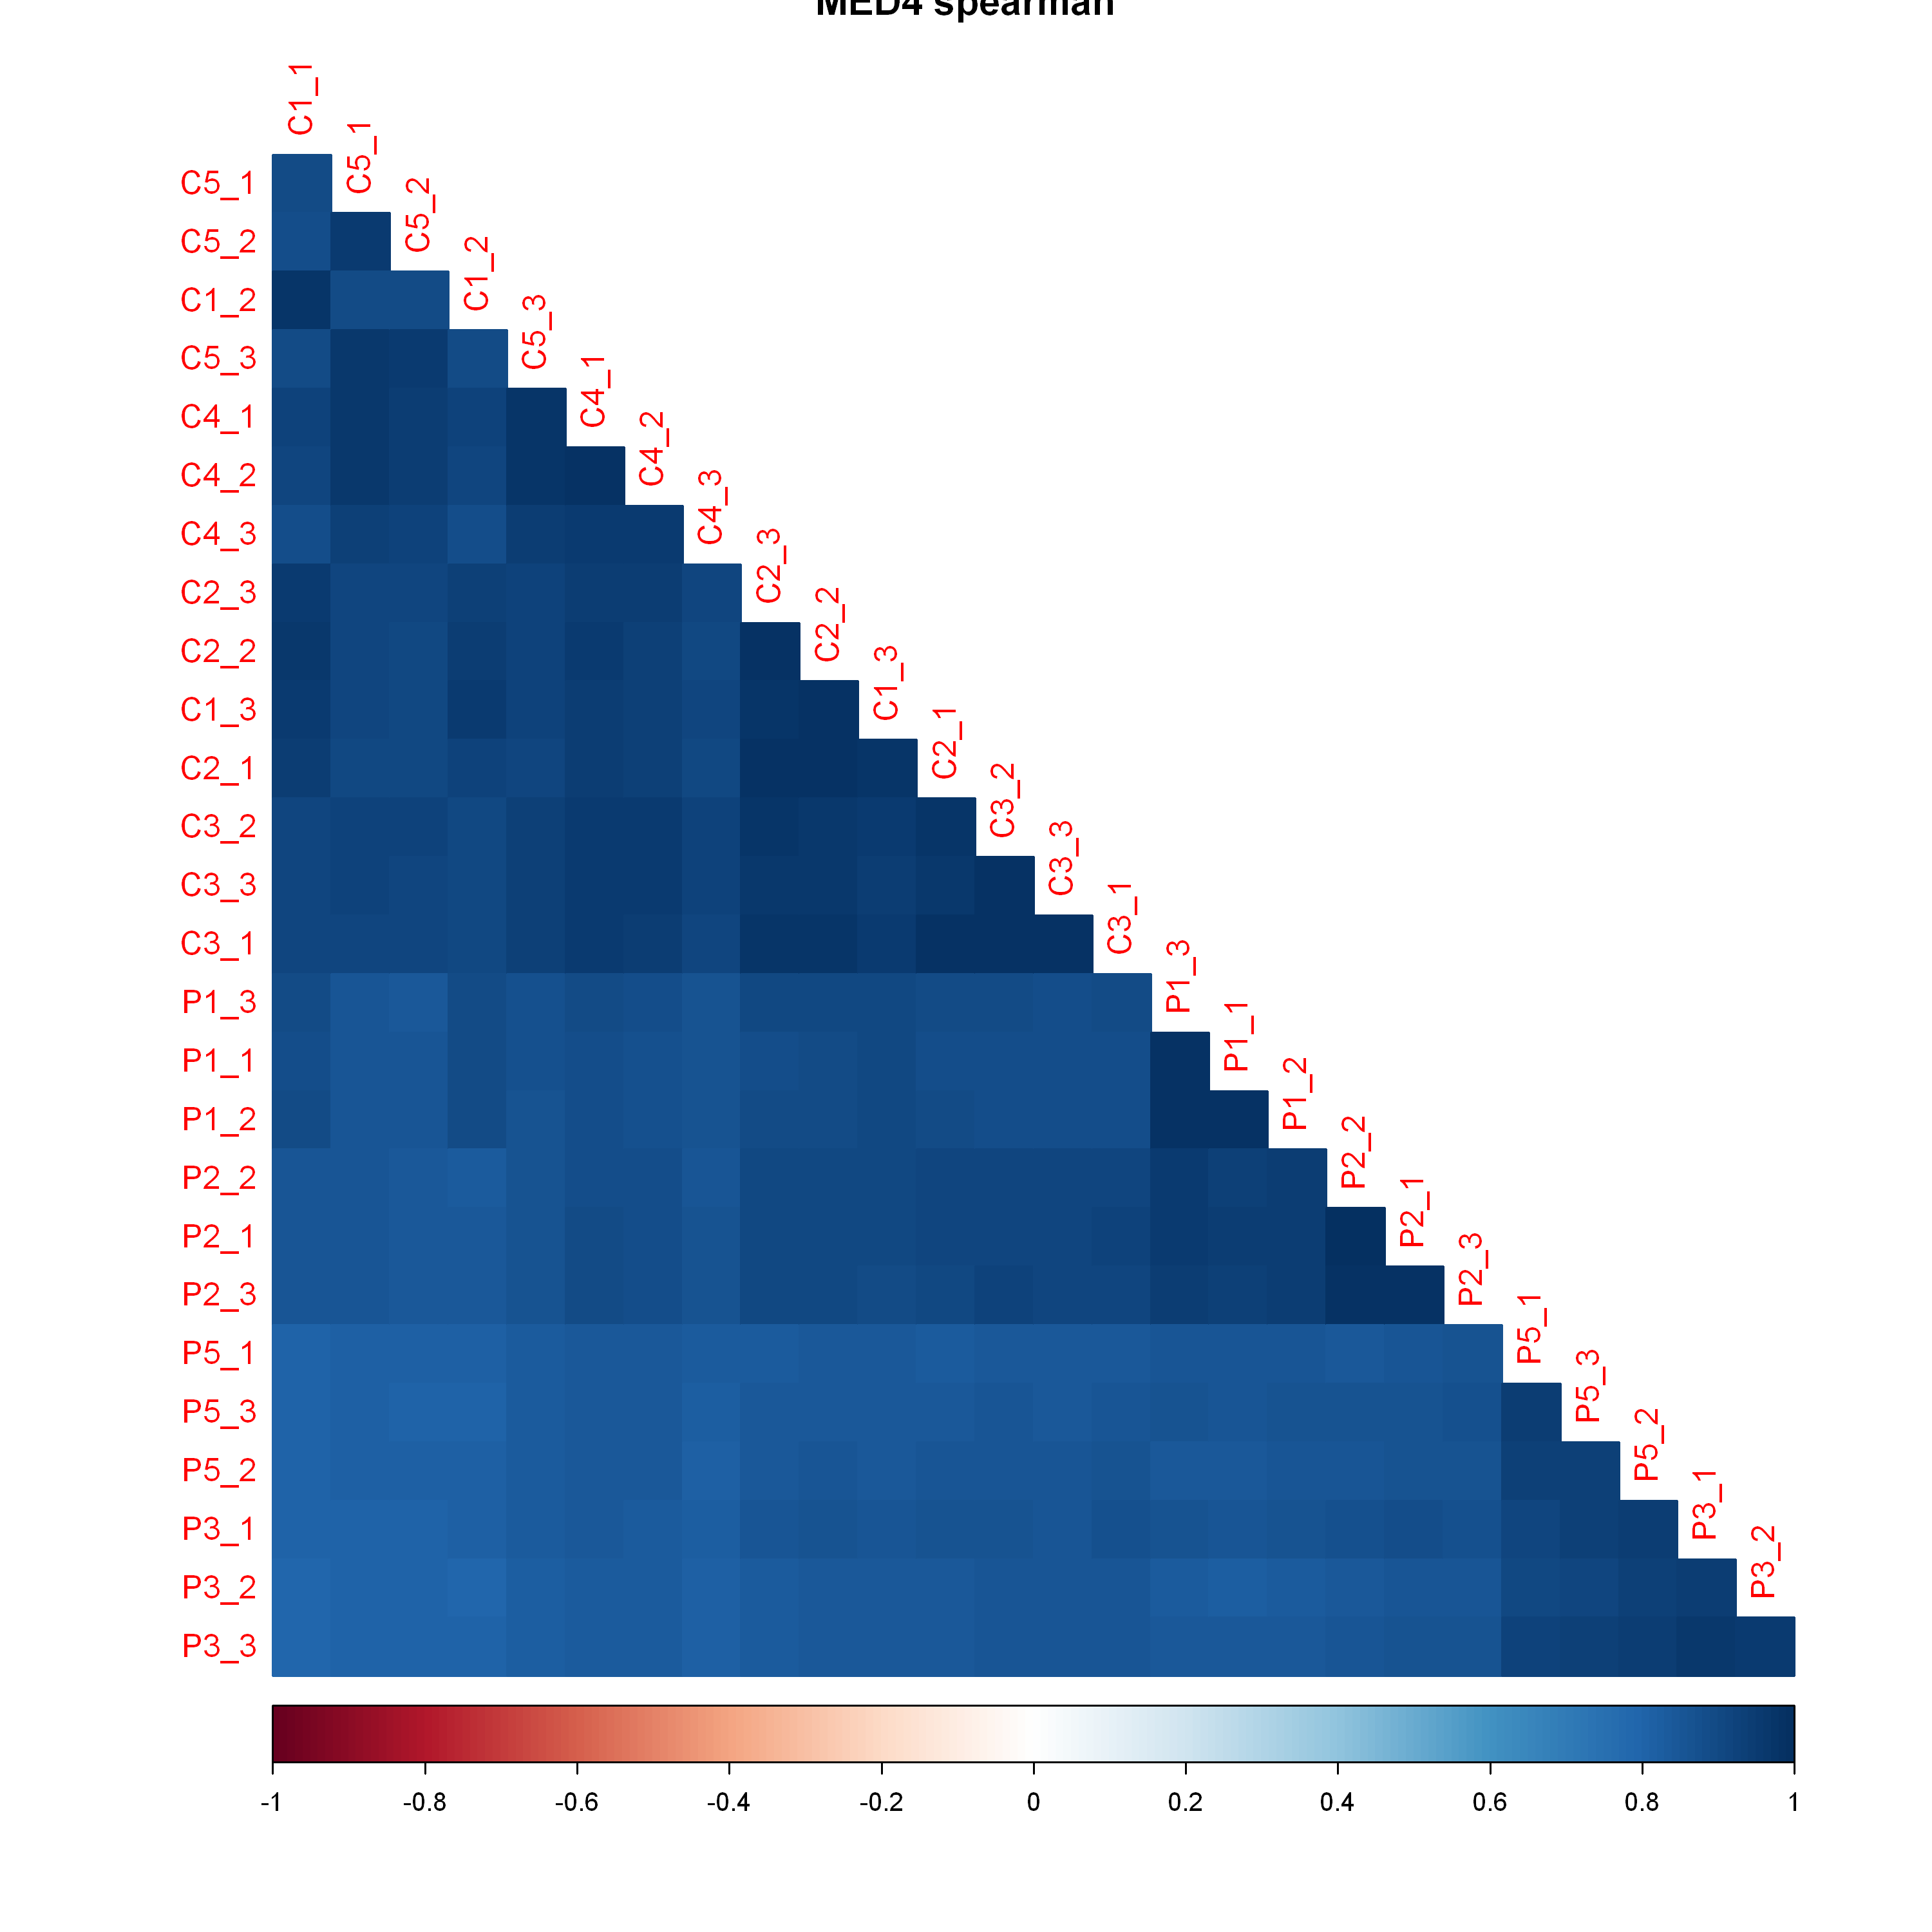

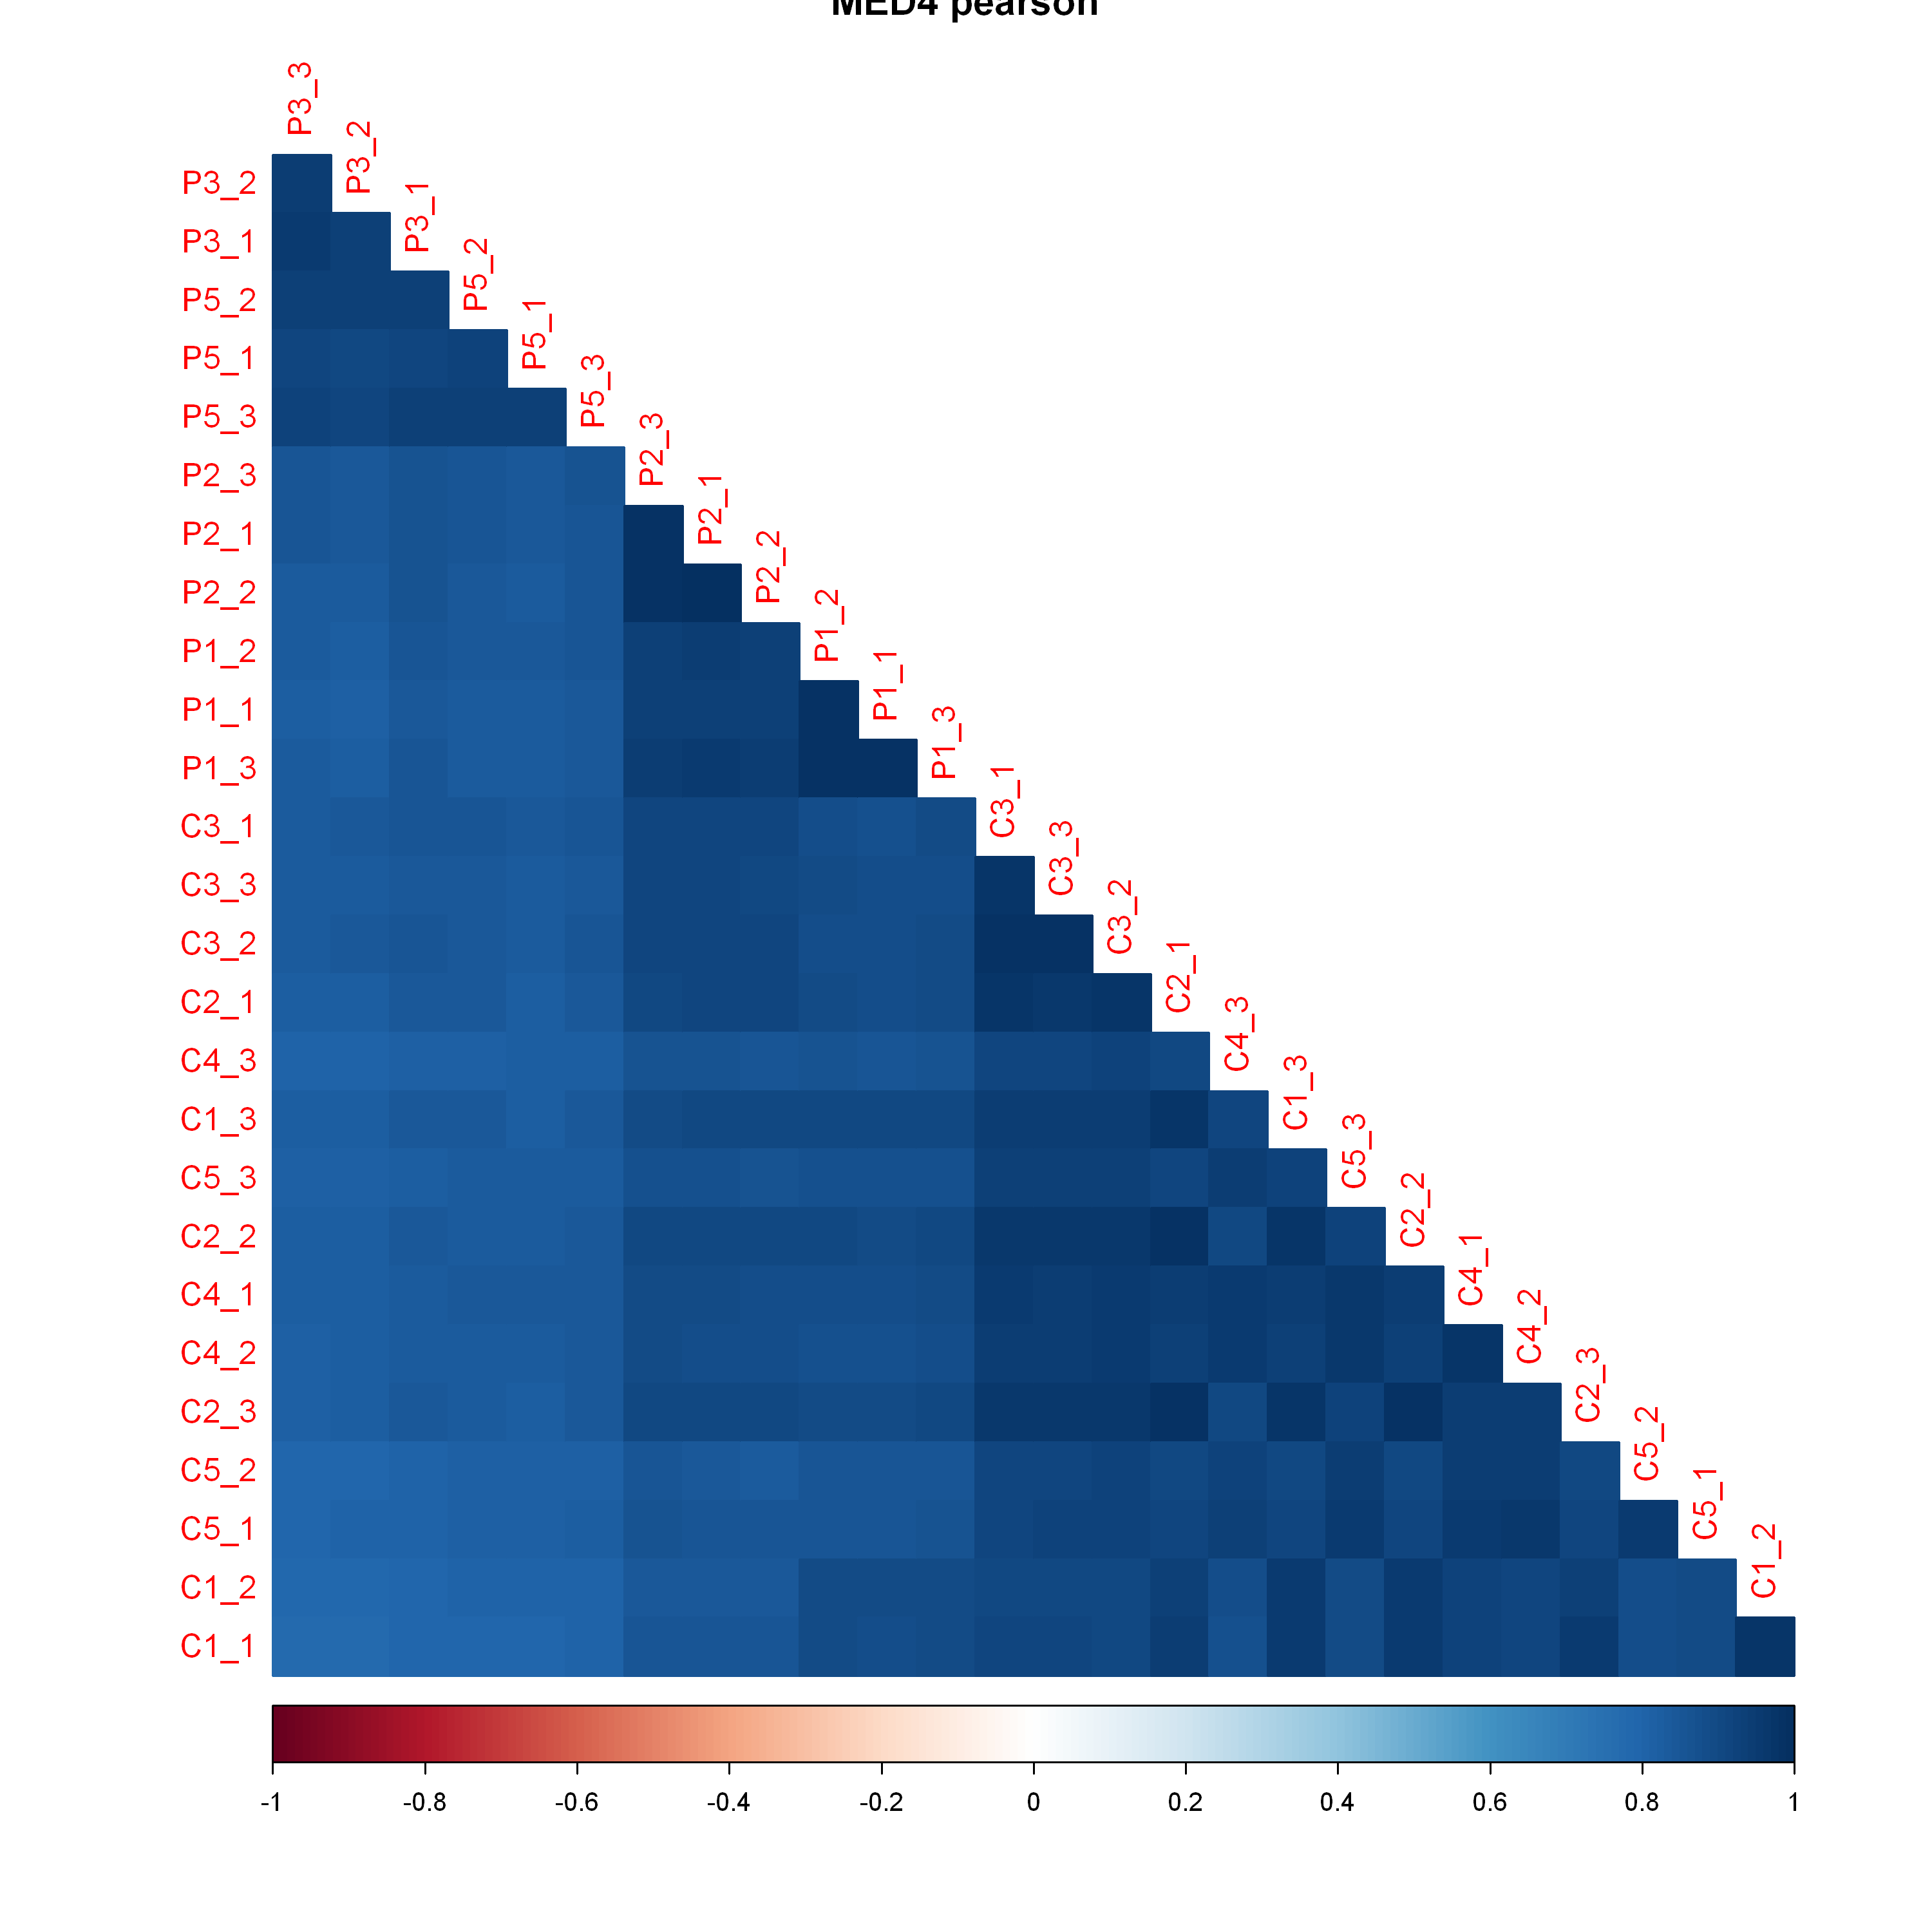

In [48]:
corrplot(spearman_cor, method="color", #tl.cex = .35, 
         order = 'AOE', diag = FALSE, type = 'lower', title='MED4 spearman')
corrplot(pearson_cor, method="color", #tl.cex = .35, 
         order = 'AOE', diag = FALSE, type = 'lower',title='MED4 pearson')


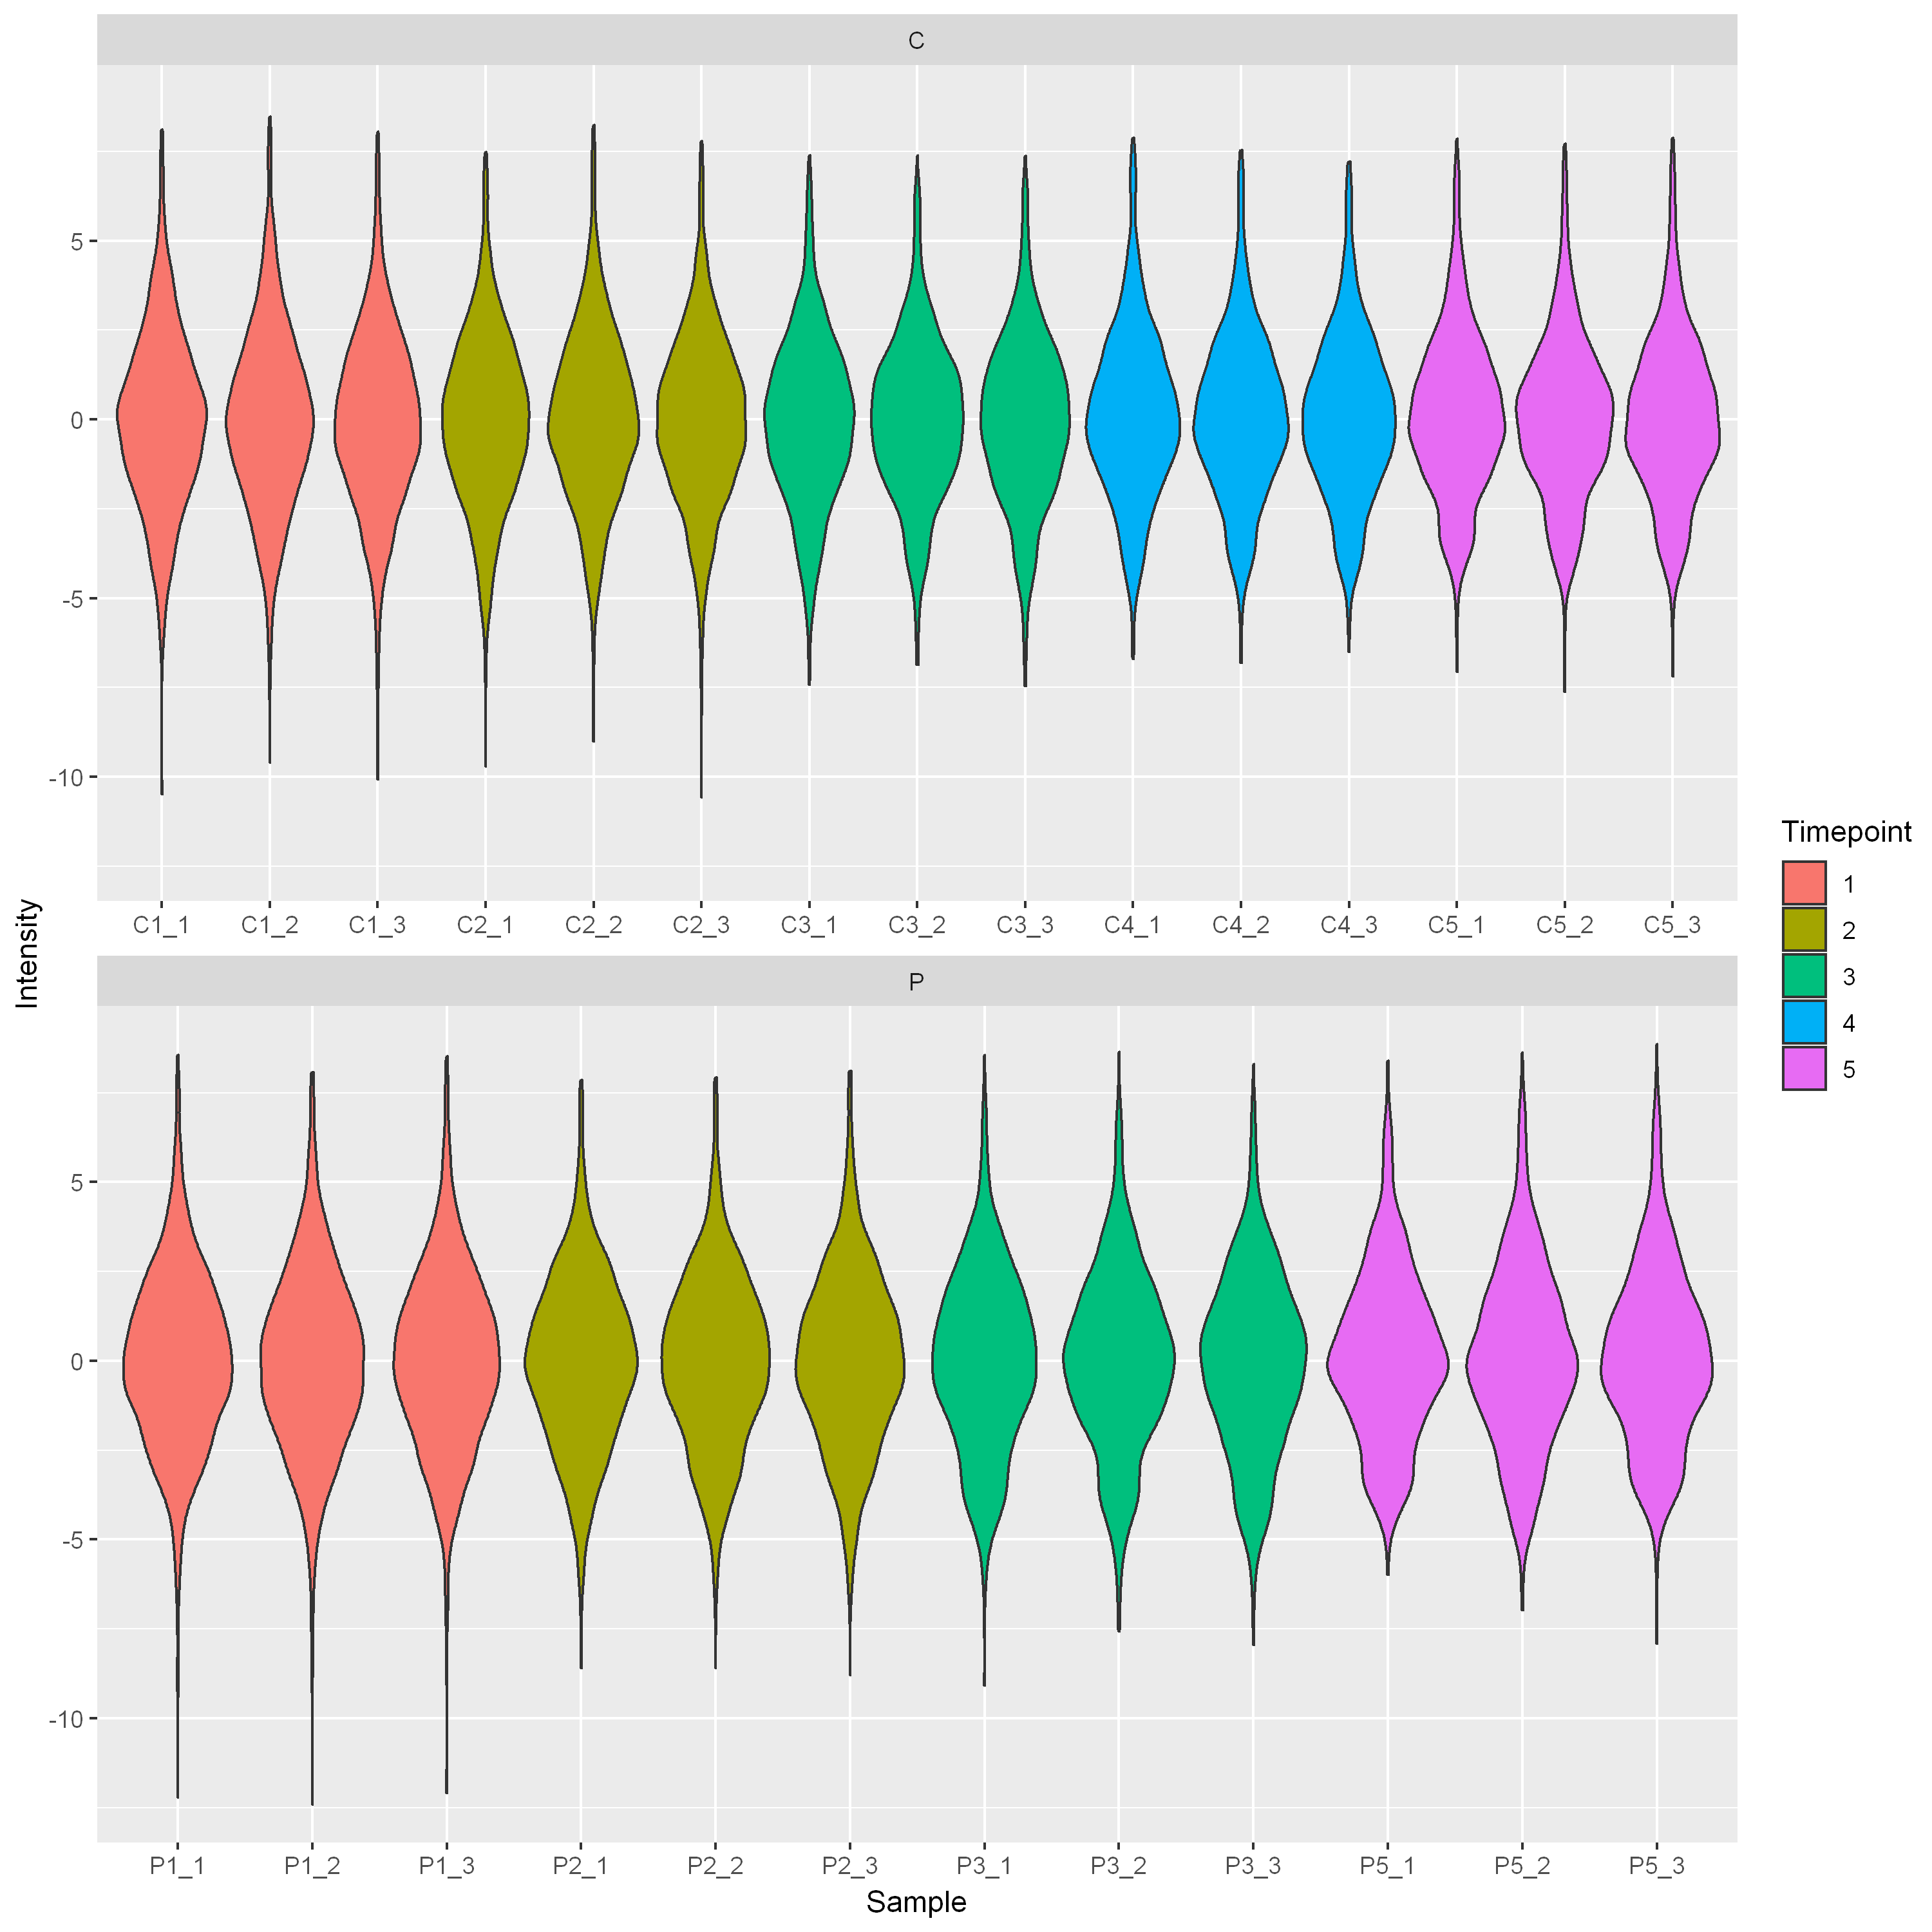

In [49]:
mdf %>%
ggplot(aes(x=Sample, y=Intensity, fill=Timepoint)) +
   geom_violin() +
facet_wrap(~Group, scales = "free_x", ncol=1)

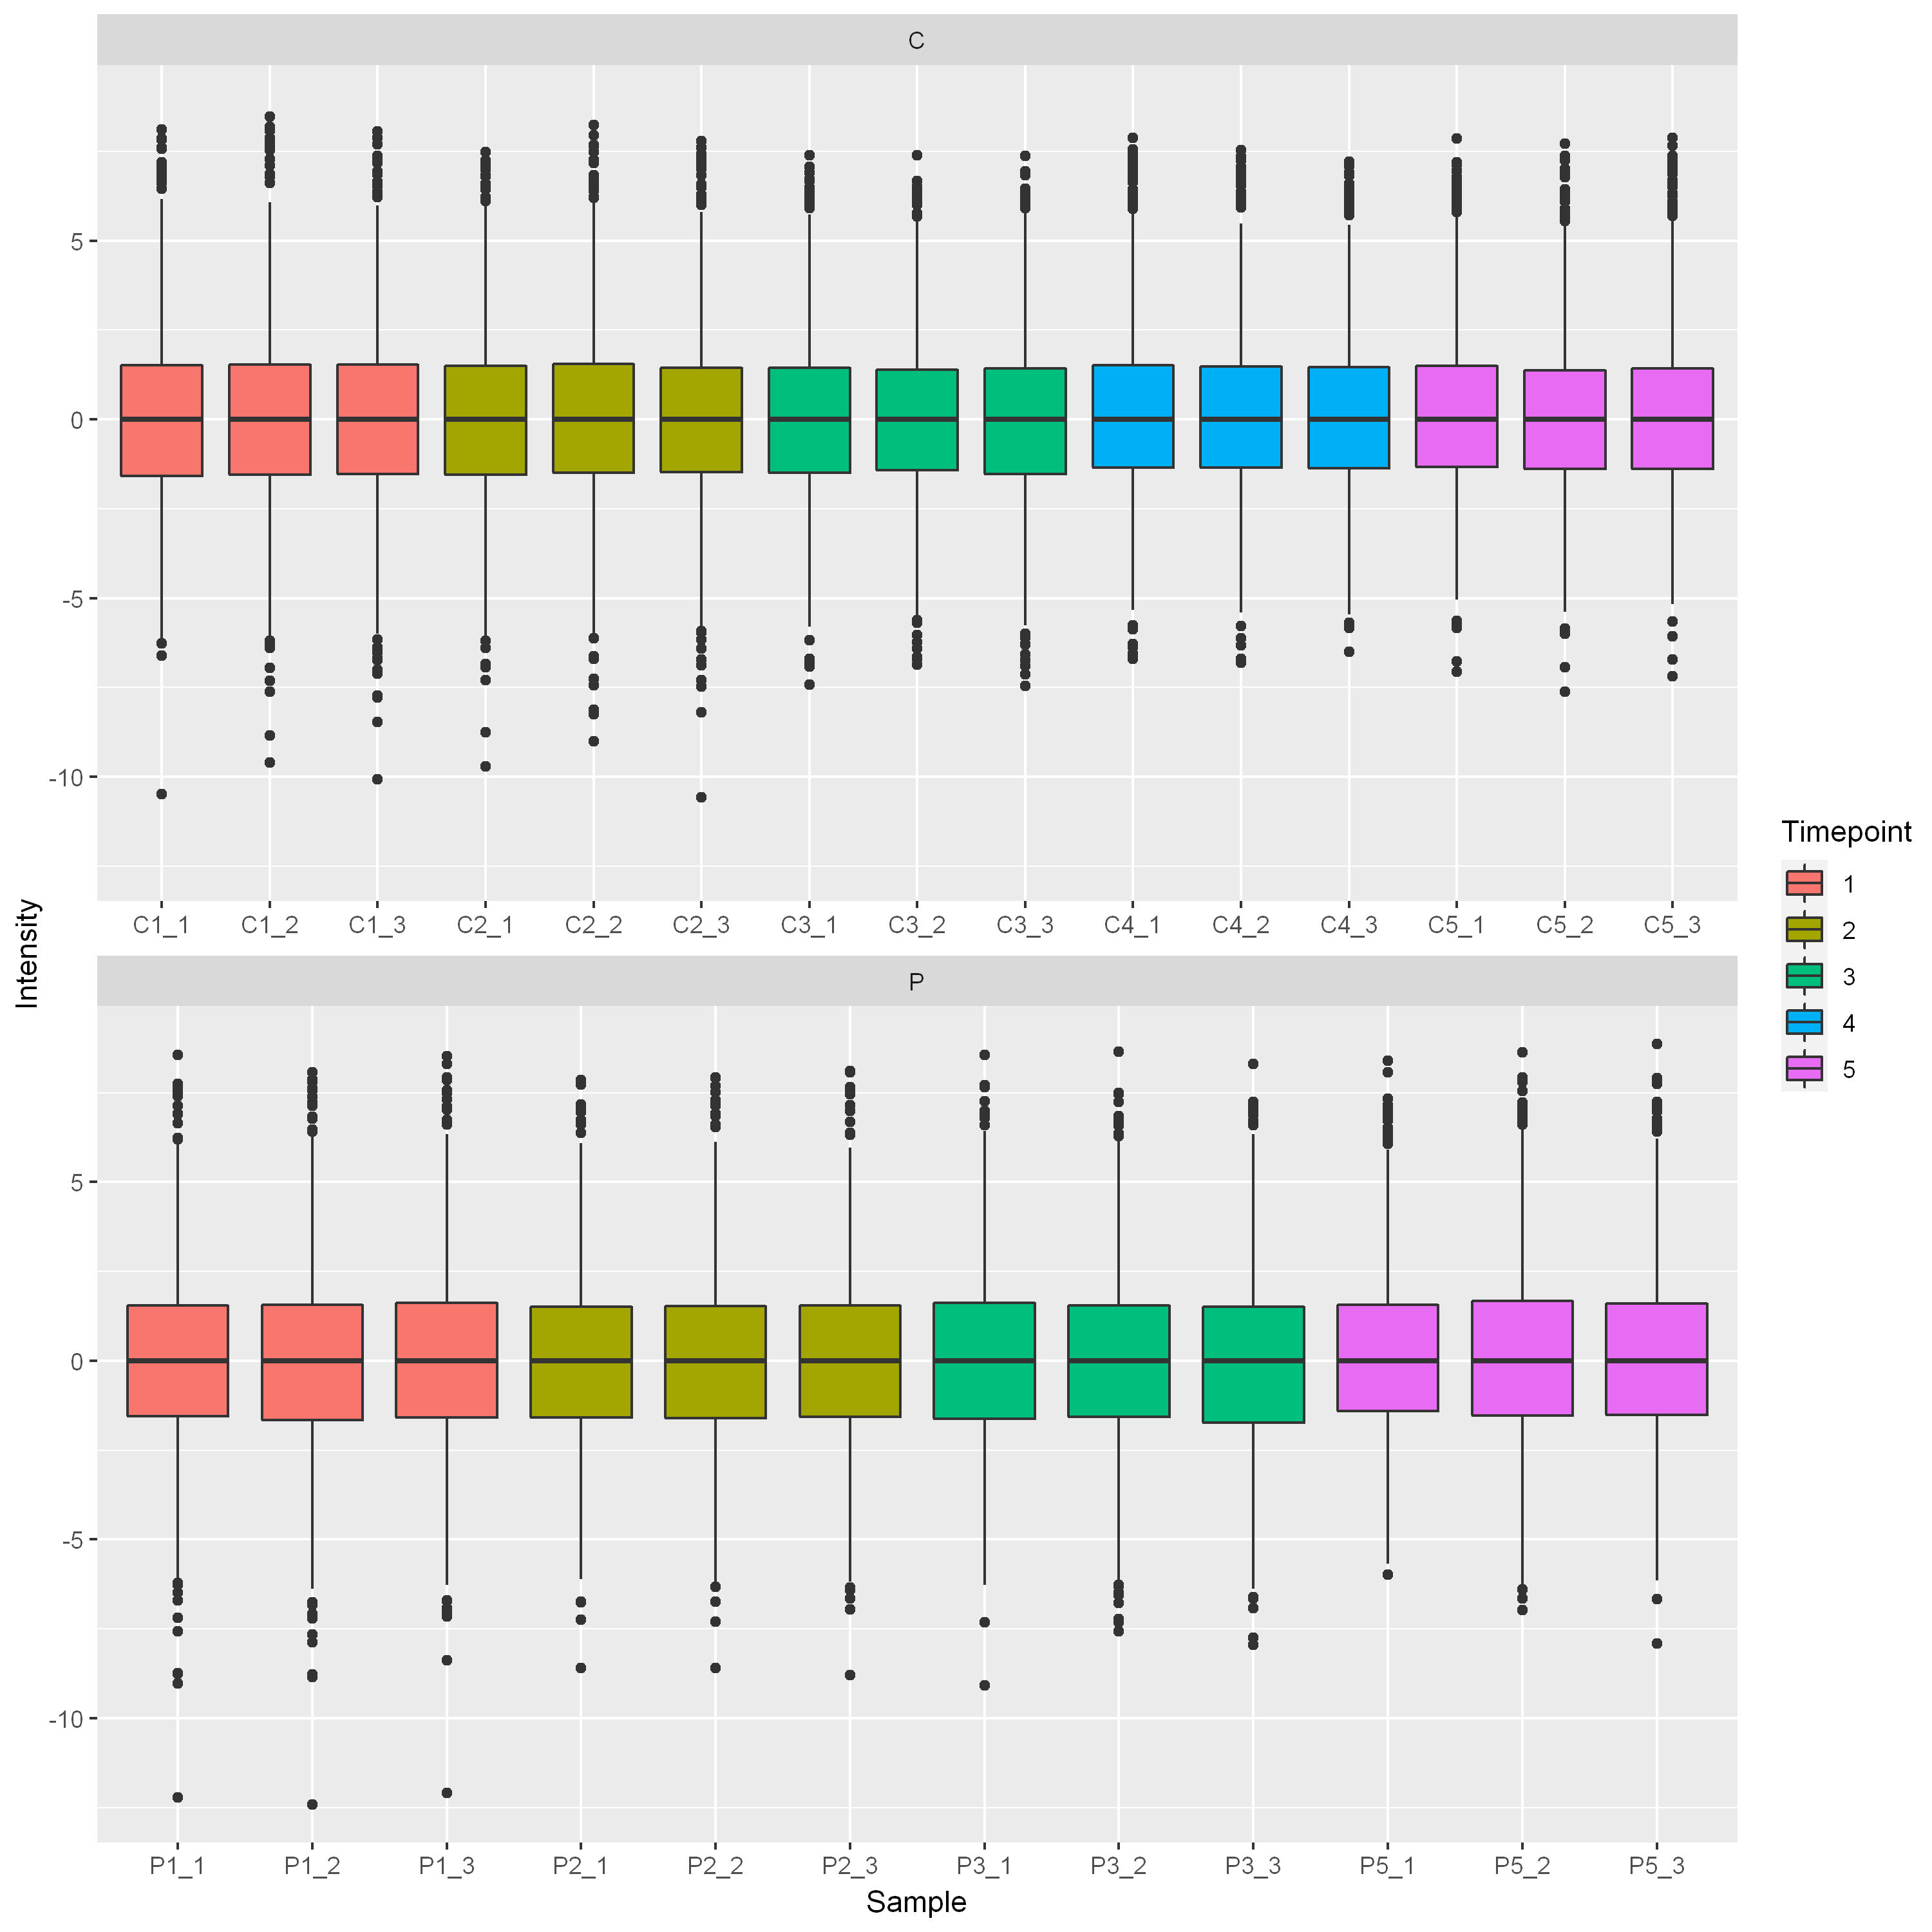

In [50]:
mdf %>%
ggplot(aes(x=Sample, y=Intensity, fill=Timepoint)) +
   geom_boxplot() +
facet_wrap(~Group, scales = "free_x", ncol=1)

# Axenic MED4 DE

In [51]:
library(DEqMS)

In [52]:
cdf = mdf %>% filter(Group == 'P') %>% 
pivot_wider(id_cols=c('protein_id'), 
    names_from='Sample', values_from = 'Intensity') %>% column_to_rownames('protein_id')

head(cdf)

P1_1      P1_2      P1_3      P2_1     P2_2     P2_3    
WP_011133152.1 7.7386408 7.6203499 7.8481503 7.722785 7.688363 8.083828
WP_011132825.1 4.4848280 4.6353226 4.4711151 4.201722 4.254651 4.773293
WP_011132757.1 0.7538214 0.9428101 0.8554344 1.582704 1.379659 1.445036
WP_011132404.1 2.2156134 2.5591640 2.3943443 3.128482 2.948134 3.065042
WP_011132401.1 4.0907907 4.3361244 4.2792282 3.850692 4.240432 4.517277
WP_011132785.1 3.0735979 3.0963993 2.9183502 2.796327 2.790843 2.911247
               P3_1       P3_2      P3_3      P5_1     P5_2     P5_3     
WP_011133152.1 3.64851284 3.8568907 3.3048029 4.251069 4.318355 5.1921253
WP_011132825.1 5.85159779 5.7096605 5.7461901 6.197679 6.612435 6.6124439
WP_011132757.1 0.07066059 0.5794344 0.7629499 1.701085 1.039477 0.8612823
WP_011132404.1 3.25779247 3.4348249 2.9038401 2.852347 3.032043 2.8461647
WP_011132401.1 5.76839542 5.4389696 5.6560545 5.905623 5.898013 6.4046650
WP_011132785.1 1.70523548 1.3716097 1.2683039 1.072383 1.064094 1.0586700

In [53]:
num_unique = mdf %>% filter(Group == 'P') %>% # take out timepoint 5 - too different from everything else
    distinct(protein_id, Number.of.Unique.Peptides) %>% column_to_rownames('protein_id')

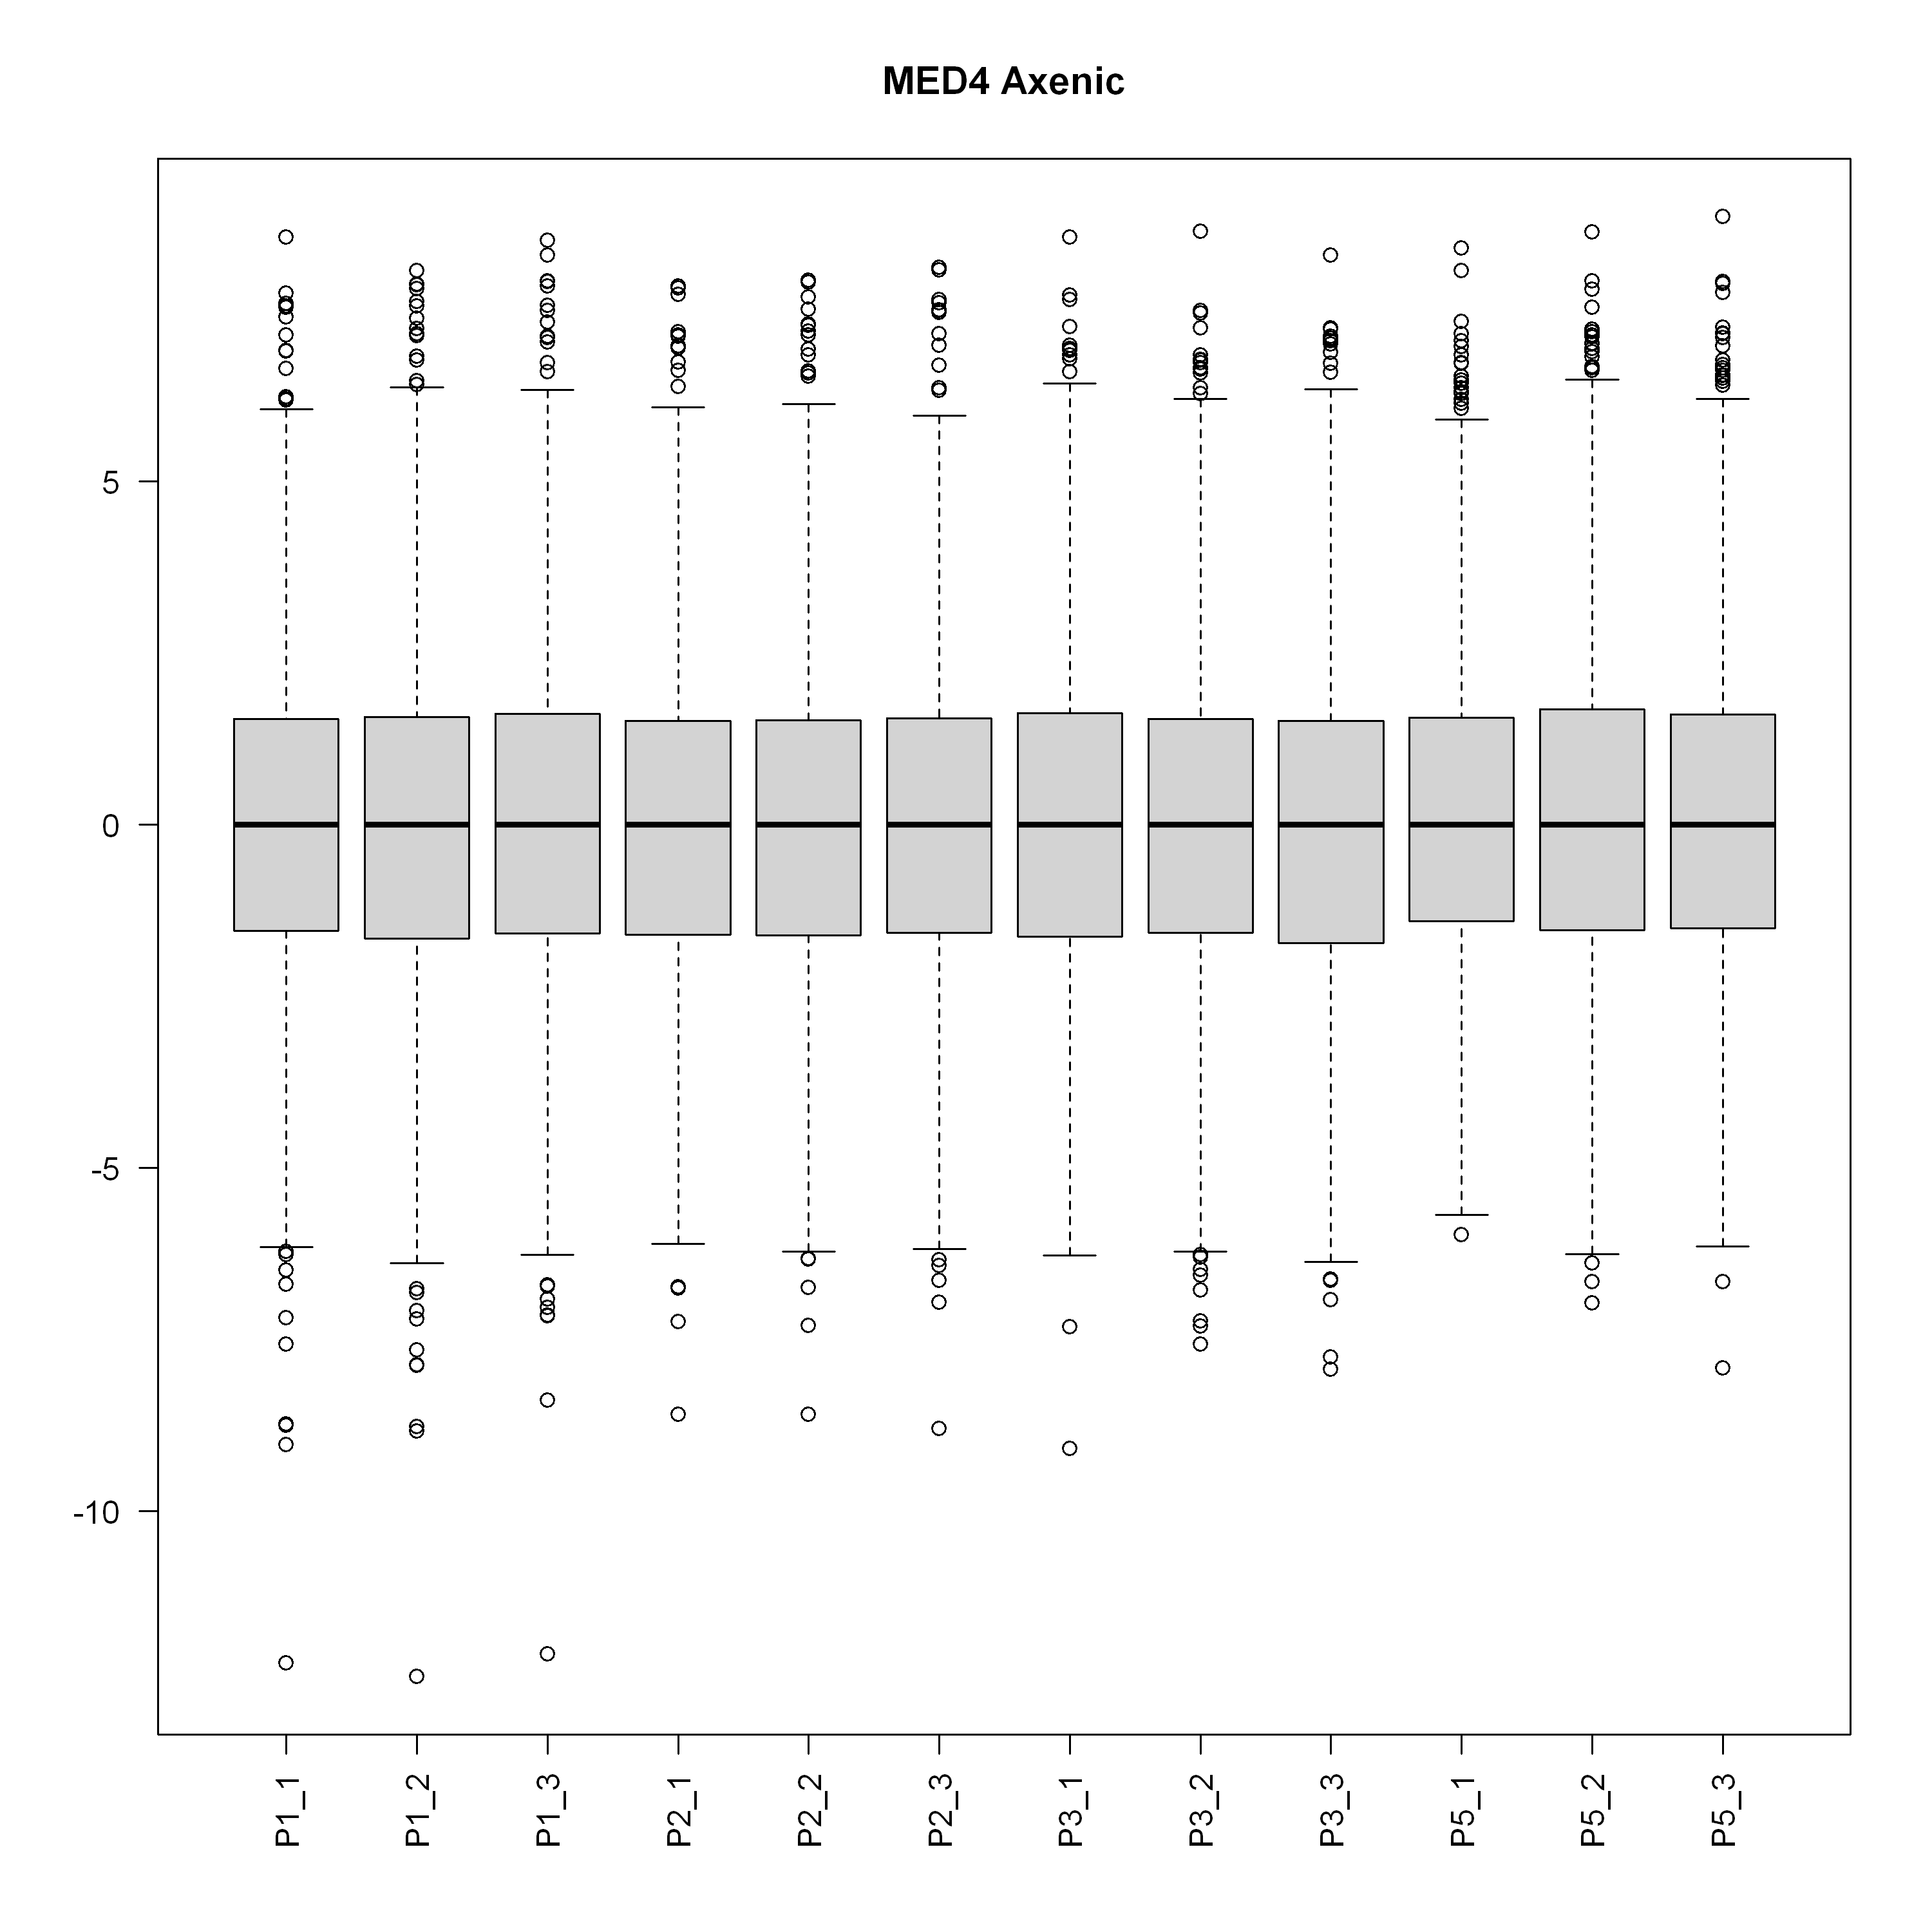

In [54]:
boxplot(cdf,las=2,main="MED4 Axenic")

In [55]:
names(cdf)

[1] "P1_1" "P1_2" "P1_3" "P2_1" "P2_2" "P2_3" "P3_1" "P3_2" "P3_3" "P5_1"
[11] "P5_2" "P5_3"

In [56]:
P = as.factor(substr(names(cdf), 2,2))
design = model.matrix(~0+P) # fitting without intercept
design

P1 P2 P3 P5
1  1  0  0  0 
2  1  0  0  0 
3  1  0  0  0 
4  0  1  0  0 
5  0  1  0  0 
6  0  1  0  0 
7  0  0  1  0 
8  0  0  1  0 
9  0  0  1  0 
10 0  0  0  1 
11 0  0  0  1 
12 0  0  0  1

In [57]:
fit1 = lmFit(cdf,design = design)
cont <- makeContrasts(P2-P1, P3-P1, P5-P1, levels = design)
fit2 = contrasts.fit(fit1,contrasts = cont)
fit3 <- eBayes(fit2)

In [58]:
fit3$count = num_unique[rownames(fit3$coefficients),"Number.of.Unique.Peptides"]

#check the values in the vector fit3$count
#if min(fit3$count) return NA or 0, you should troubleshoot the error first
min(fit3$count)

[1] 1

In [59]:
fit4 = spectraCounteBayes(fit3)

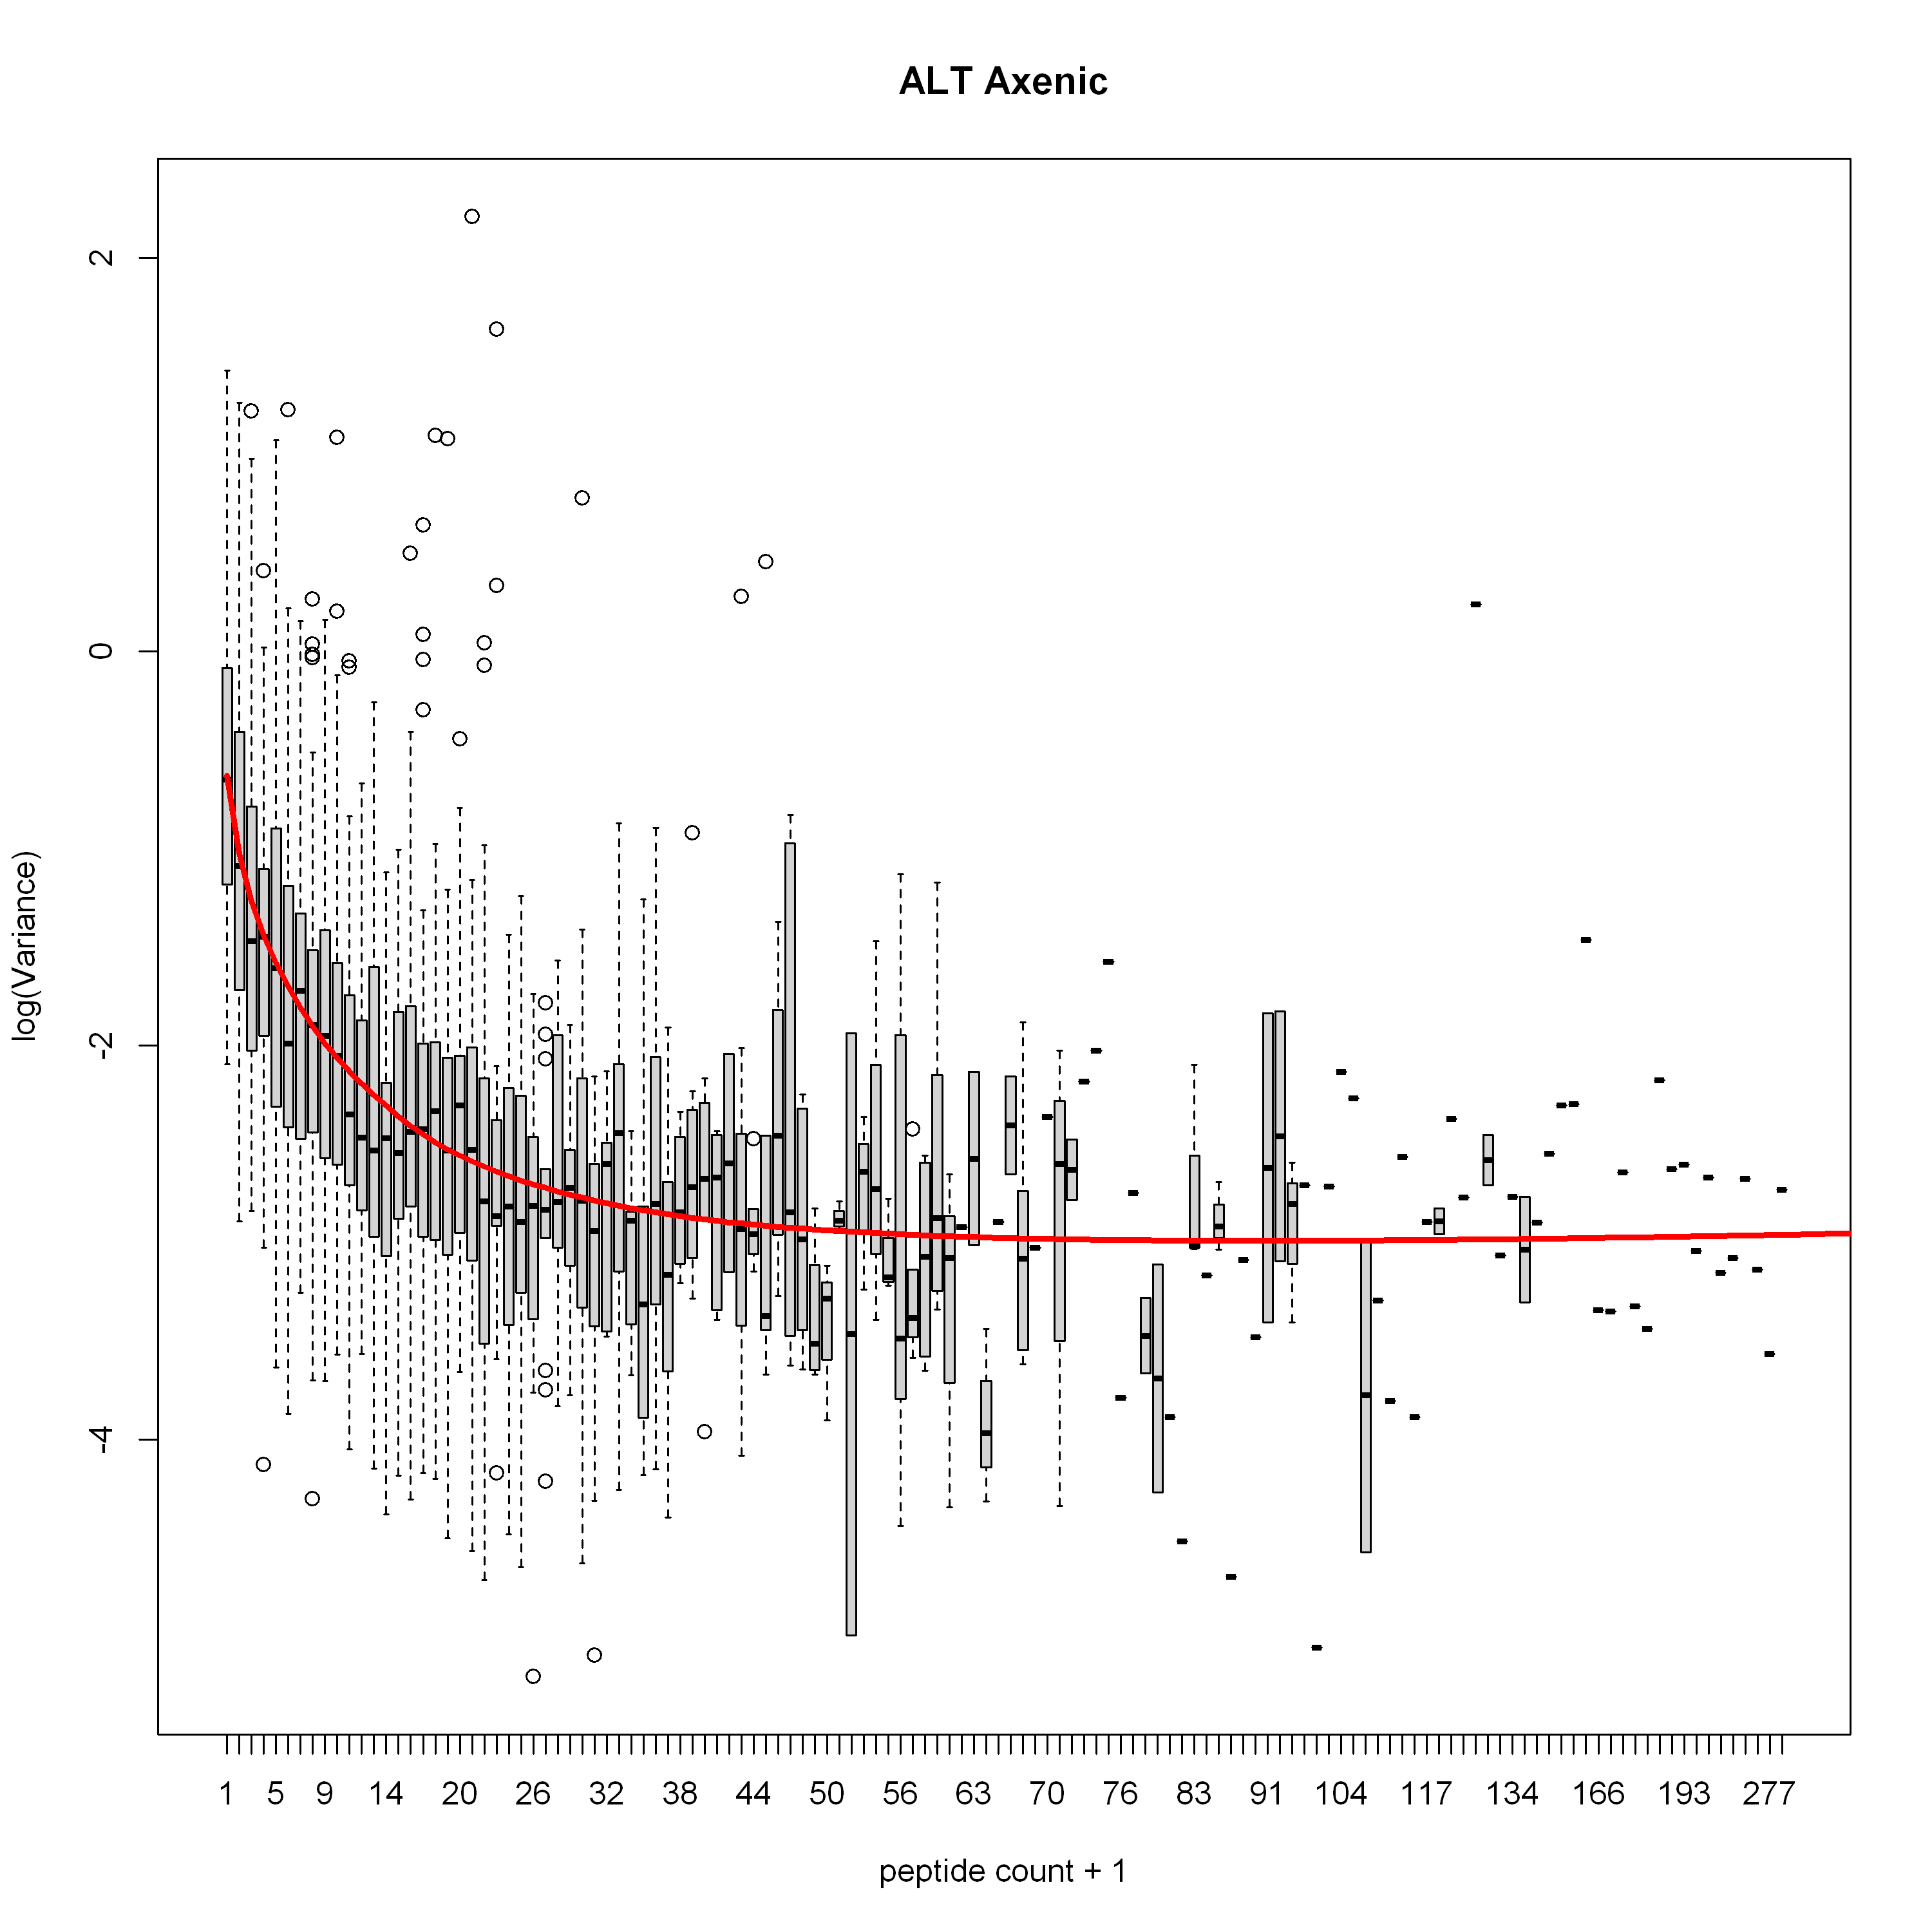

In [60]:
VarianceBoxplot(fit4, n=500, main = "ALT Axenic",
                xlab="peptide count + 1")

In [61]:
colnames(fit4$coefficients)

[1] "P2 - P1" "P3 - P1" "P5 - P1"

In [62]:
P2P1.results = outputResult(fit4,coef_col = 1) %>% mutate(contrast = 'P2 - P1')
P3P1.results = outputResult(fit4,coef_col = 2) %>% mutate(contrast = 'P3 - P1')
P5P1.results = outputResult(fit4,coef_col = 3) %>% mutate(contrast = 'P5 - P1')

P.results = bind_rows(P2P1.results, P3P1.results, P5P1.results)

In [63]:
P.results = left_join(P.results, hpath_df_to_export, by=c(gene='protein_id'))

In [103]:
P.results  = P.results %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 
P.results$Category = factor(P.results$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))
my.cols <- c(brewer.pal(7, "Set2"), 'grey34')

Warning message:
"ggrepel: 37 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


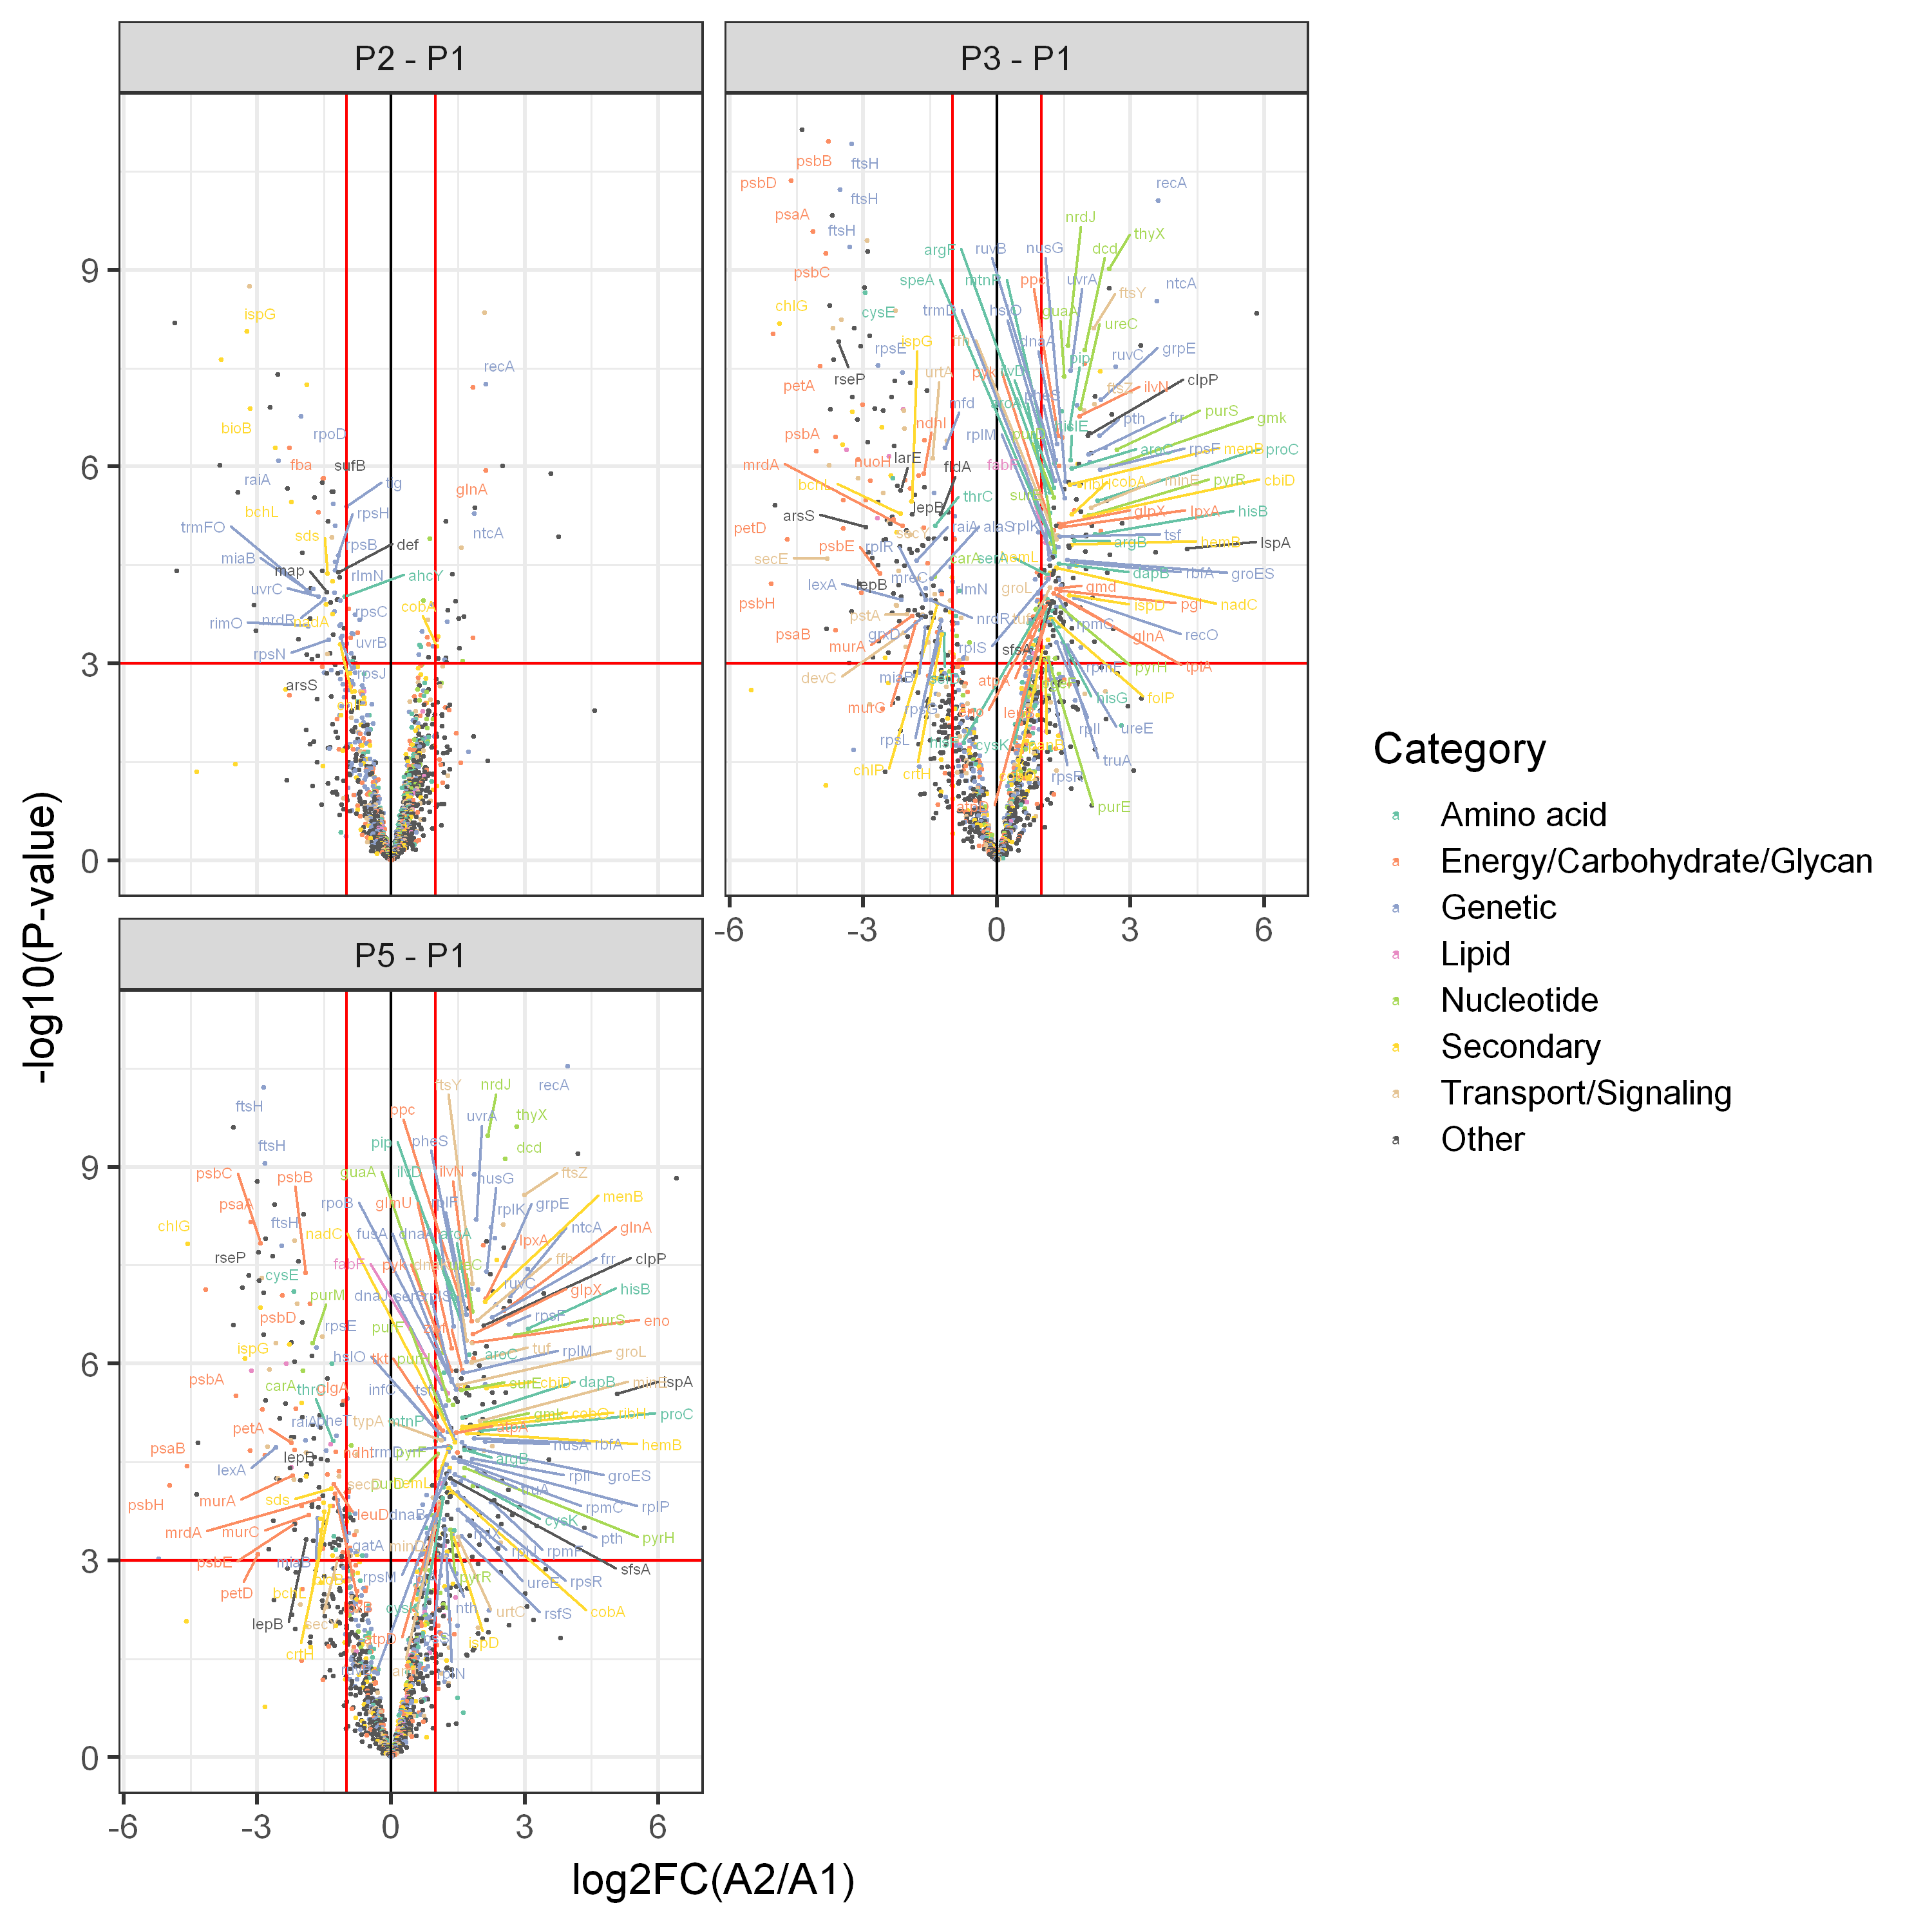

In [116]:
library(ggrepel)
# Use ggplot2 allows more flexibility in plotting

P.results$log.sca.pval = -log10(P.results$sca.P.Value)
ggplot(P.results, aes(x = logFC, y =log.sca.pval, color=Category )) + 
    geom_point(size=0.5 )+
    theme_bw(base_size = 16) + # change theme
    xlab(expression("log2FC(A2/A1)")) + # x-axis label
    ylab(expression(" -log10(P-value)")) + # y-axis label
    geom_vline(xintercept = c(-1,1), colour = "red") + # Add fold change cutoffs
    geom_hline(yintercept = 3, colour = "red") + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black") + # Add 0 lines
    scale_colour_manual(values = my.cols)+
    geom_text_repel(data=subset(P.results, abs(logFC)>1&log.sca.pval > 3),
                    aes( logFC, log.sca.pval ,label=gene.y), size=2, max.overlaps=100)  + # add gene label
    facet_wrap(~contrast, ncol=2)

# CC MED4 DE

In [71]:
cdf = mdf %>% filter(Group == 'C') %>% 
pivot_wider(id_cols=c('protein_id'), 
    names_from='Sample', values_from = 'Intensity') %>% column_to_rownames('protein_id')

head(cdf)

C1_1     C1_2     C1_3     C2_1     C2_2     C2_3     C3_1    
WP_036930312.1 4.315192 3.904885 5.643631 6.592691 6.199080 6.069427 7.060764
WP_011132553.1 3.012233 2.490735 5.221550 6.429291 5.938936 6.009636 6.731760
WP_011133065.1 6.097384 7.786138 8.062645 7.142181 7.485416 7.019489 7.381798
WP_002805854.1 5.676785 5.820374 5.627089 5.524055 5.622326 5.657085 6.047516
WP_011133136.1 6.456103 6.871163 6.935638 6.593880 6.829687 6.576691 6.343586
WP_011133111.1 4.967328 5.436225 5.507900 5.092224 5.207661 4.755415 4.856405
               C3_2     C3_3     C4_1     C4_2     C4_3     C5_1     C5_2    
WP_036930312.1 6.669080 6.943257 7.363750 7.065671 6.874102 6.949040 6.998334
WP_011132553.1 6.419105 6.410733 6.177835 6.141454 6.116852 5.814738 5.596951
WP_011133065.1 7.382258 7.379933 7.442105 7.240170 7.172518 6.933459 7.373826
WP_002805854.1 6.028348 6.140056 7.355660 7.056380 6.902369 7.135177 7.320560
WP_011133136.1 6.008561 6.145251 6.628970 6.361516 6.209372 6.304336 6.273396
WP_011133111.1 4.556363 4.772334 5.145514 4.894708 4.929260 4.845759 4.710584
               C5_3    
WP_036930312.1 7.350987
WP_011132553.1 5.960504
WP_011133065.1 7.659724
WP_002805854.1 7.245799
WP_011133136.1 6.621615
WP_011133111.1 5.266555

In [72]:
num_unique = mdf %>% filter(Group == 'C') %>% # take out timepoint 5 - too different from everything else
    distinct(protein_id, Number.of.Unique.Peptides) %>% column_to_rownames('protein_id')

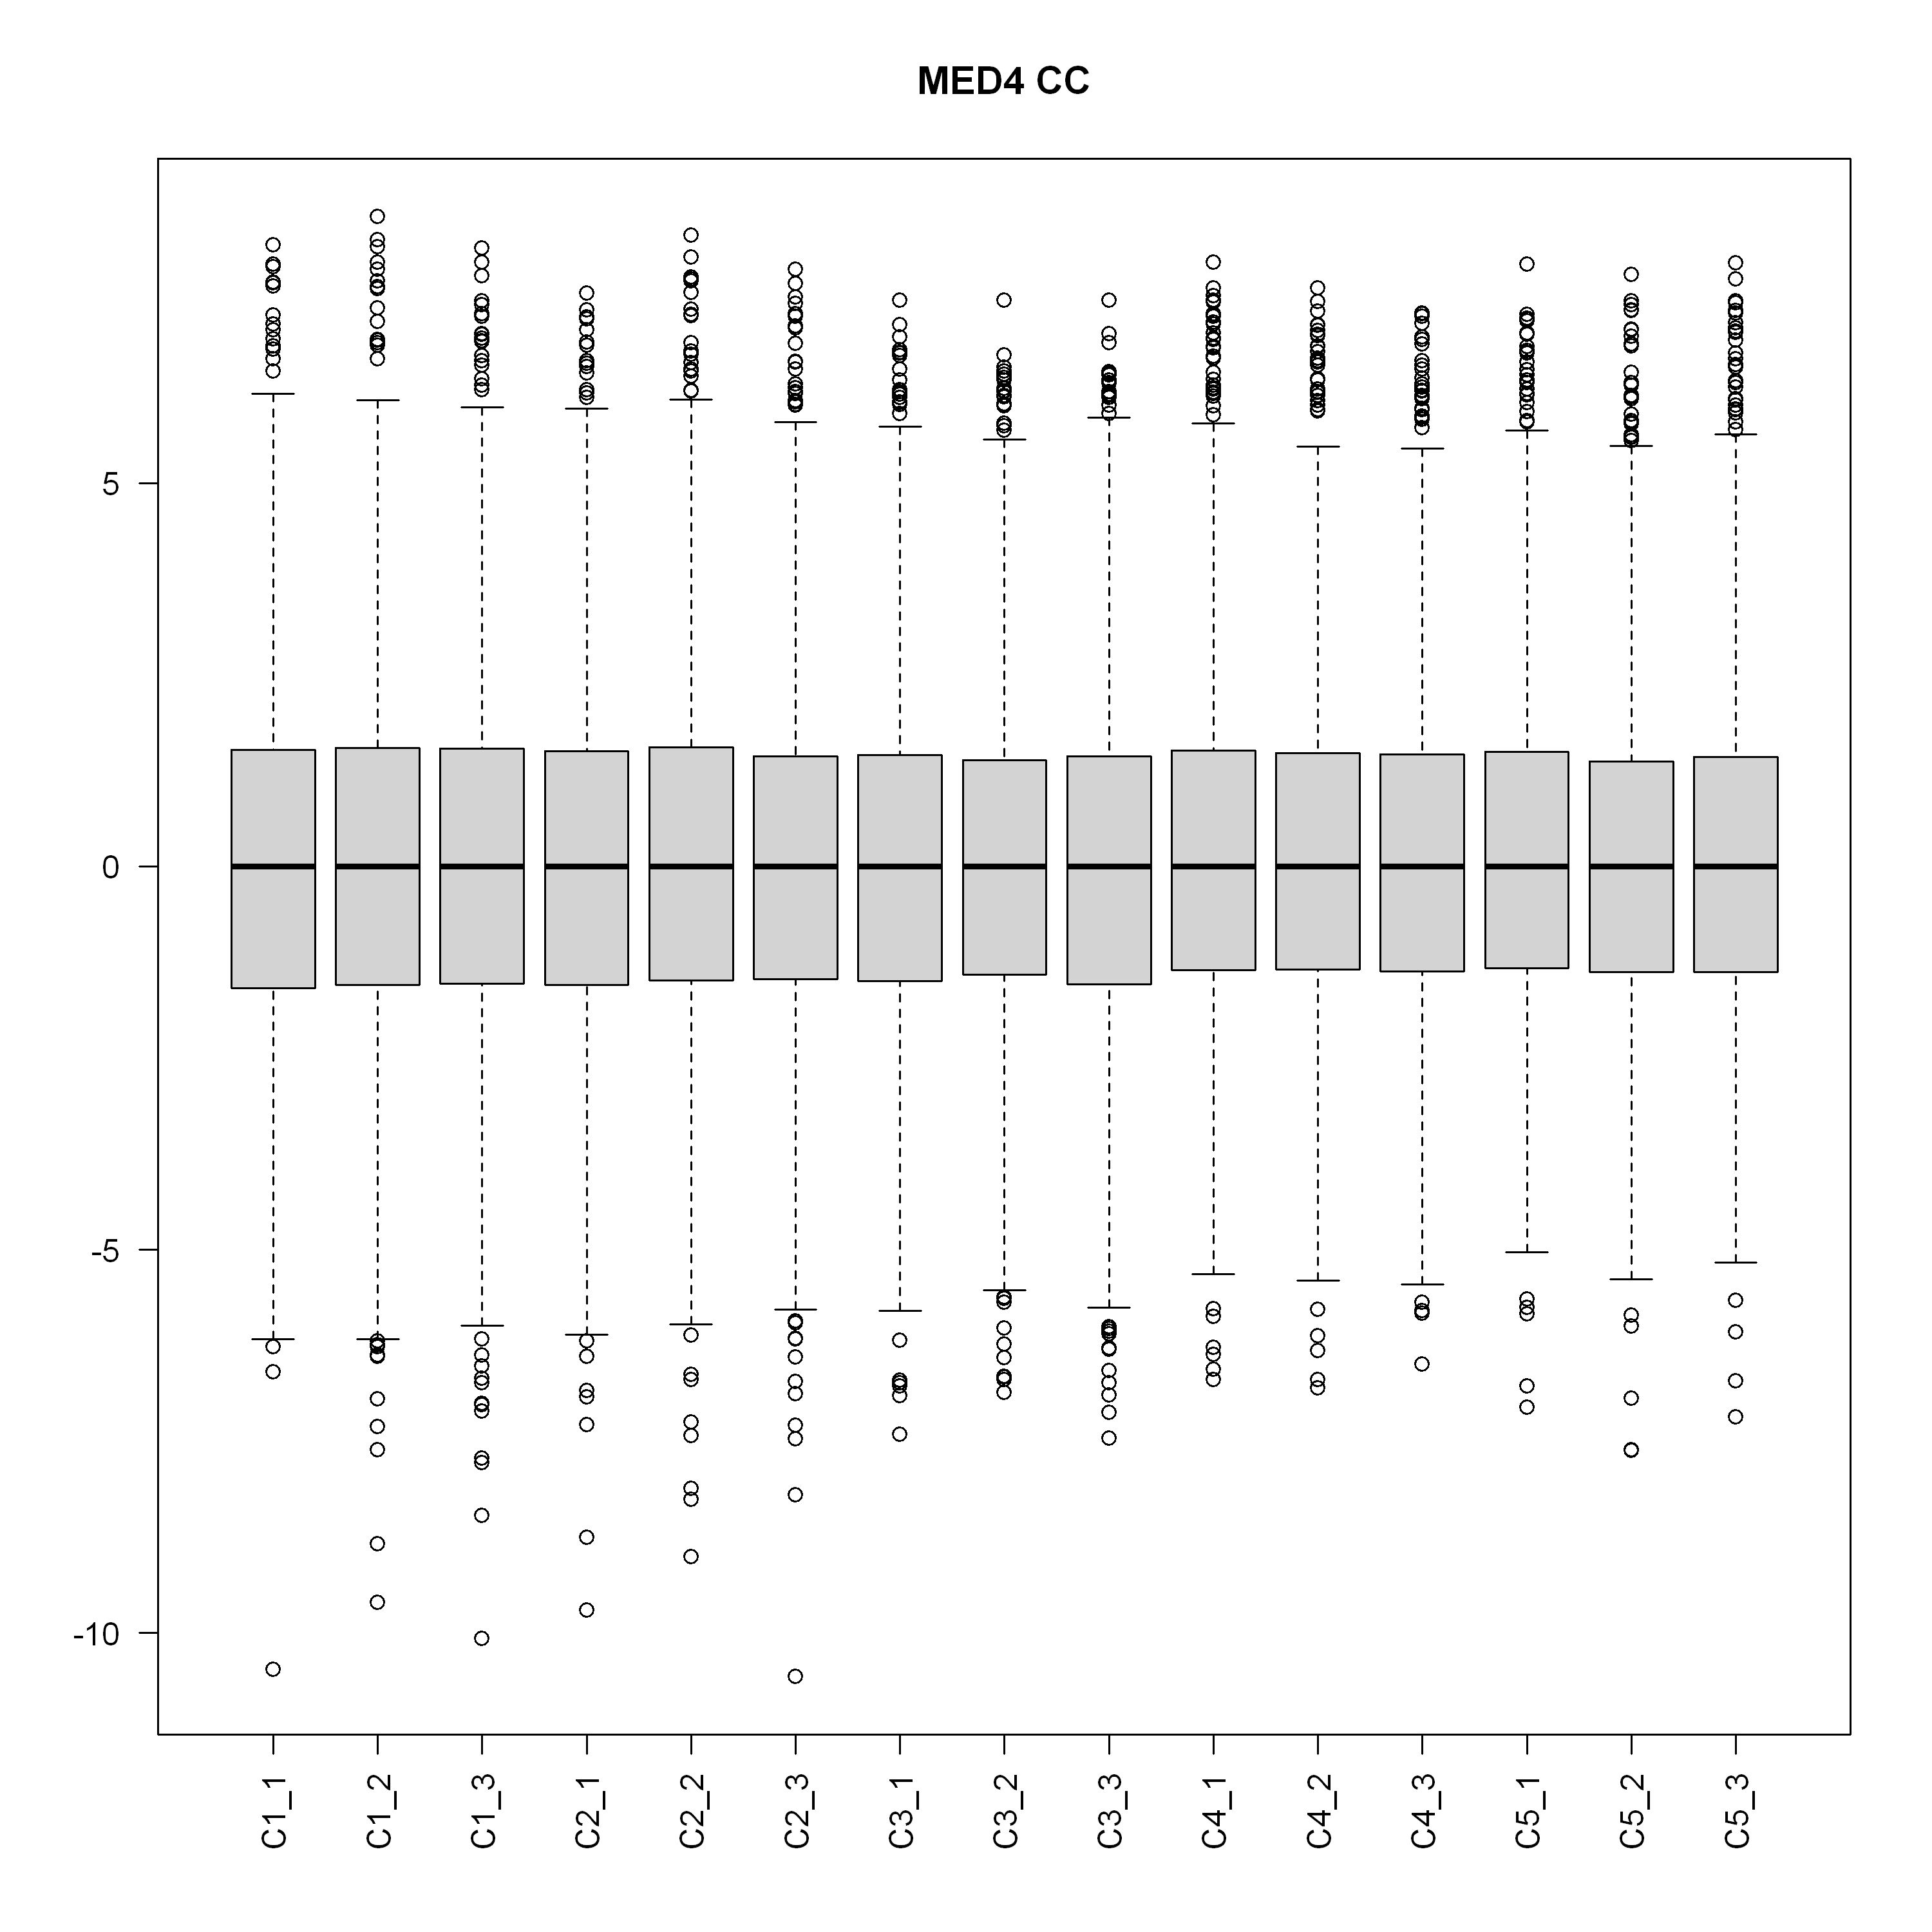

In [73]:
boxplot(cdf,las=2,main="MED4 CC")

In [74]:
names(cdf)

[1] "C1_1" "C1_2" "C1_3" "C2_1" "C2_2" "C2_3" "C3_1" "C3_2" "C3_3" "C4_1"
[11] "C4_2" "C4_3" "C5_1" "C5_2" "C5_3"

In [75]:
C = as.factor(substr(names(cdf), 2,2))
design = model.matrix(~0+C) # fitting without intercept
design

C1 C2 C3 C4 C5
1  1  0  0  0  0 
2  1  0  0  0  0 
3  1  0  0  0  0 
4  0  1  0  0  0 
5  0  1  0  0  0 
6  0  1  0  0  0 
7  0  0  1  0  0 
8  0  0  1  0  0 
9  0  0  1  0  0 
10 0  0  0  1  0 
11 0  0  0  1  0 
12 0  0  0  1  0 
13 0  0  0  0  1 
14 0  0  0  0  1 
15 0  0  0  0  1

In [76]:
fit1 = lmFit(cdf,design = design)
cont <- makeContrasts(C2-C1, C3-C1, C4 - C1, C5 - C1, levels = design)
fit2 = contrasts.fit(fit1,contrasts = cont)
fit3 <- eBayes(fit2)

In [77]:
fit3$count = num_unique[rownames(fit3$coefficients),"Number.of.Unique.Peptides"]

#check the values in the vector fit3$count
#if min(fit3$count) return NA or 0, you should troubleshoot the error first
min(fit3$count)

[1] 1

In [78]:
fit4 = spectraCounteBayes(fit3)

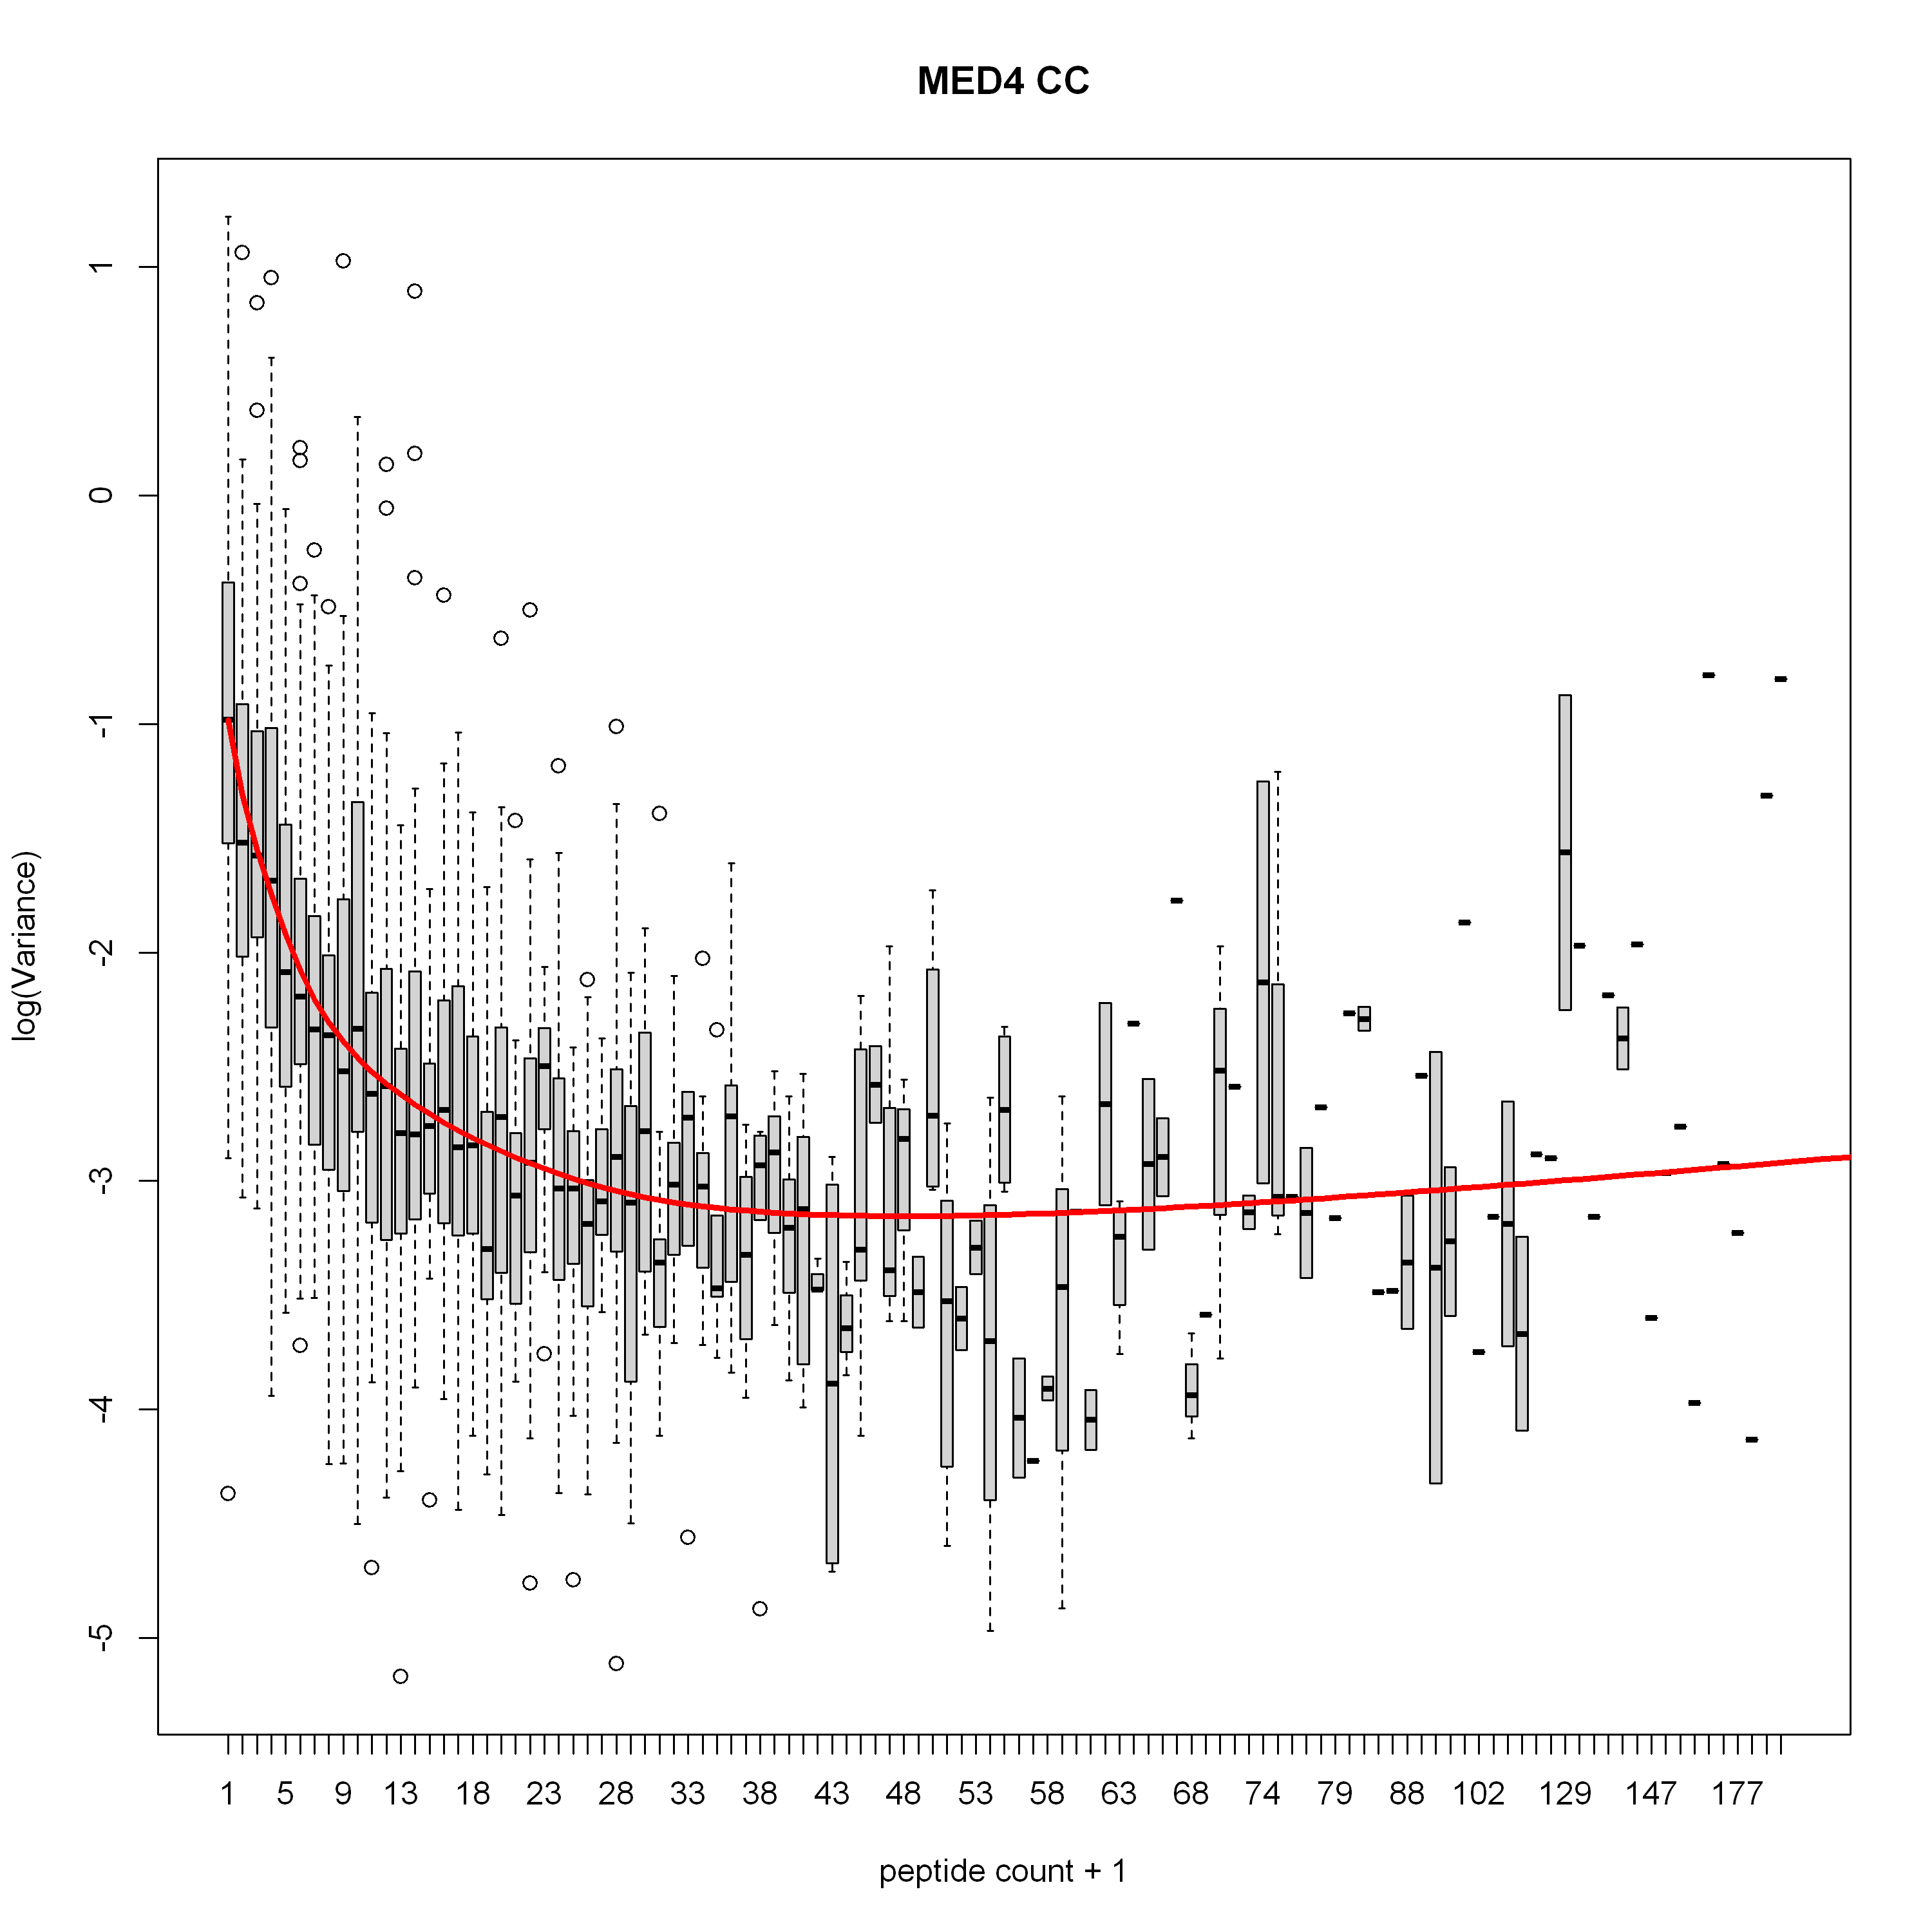

In [80]:
VarianceBoxplot(fit4, n=500, main = "MED4 CC",
                xlab="peptide count + 1")

In [81]:
colnames(fit4$coefficients)

[1] "C2 - C1" "C3 - C1" "C4 - C1" "C5 - C1"

In [82]:
C2C1.results = outputResult(fit4,coef_col = 1) %>% mutate(contrast = 'C2 - C1')
C3C1.results = outputResult(fit4,coef_col = 2) %>% mutate(contrast = 'C3 - C1')
C4C1.results = outputResult(fit4,coef_col = 3) %>% mutate(contrast = 'C4 - C1')
C5C1.results = outputResult(fit4,coef_col = 4) %>% mutate(contrast = 'C5 - C1')

C.results = bind_rows(C2C1.results, C3C1.results, C4C1.results, C5C1.results)

In [83]:
C.results = left_join(C.results, hpath_df_to_export, by=c(gene='protein_id'))

In [100]:
C.results  = C.results %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 
C.results$Category = factor(C.results$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))
my.cols <- c(brewer.pal(7, "Set2"), 'grey34')

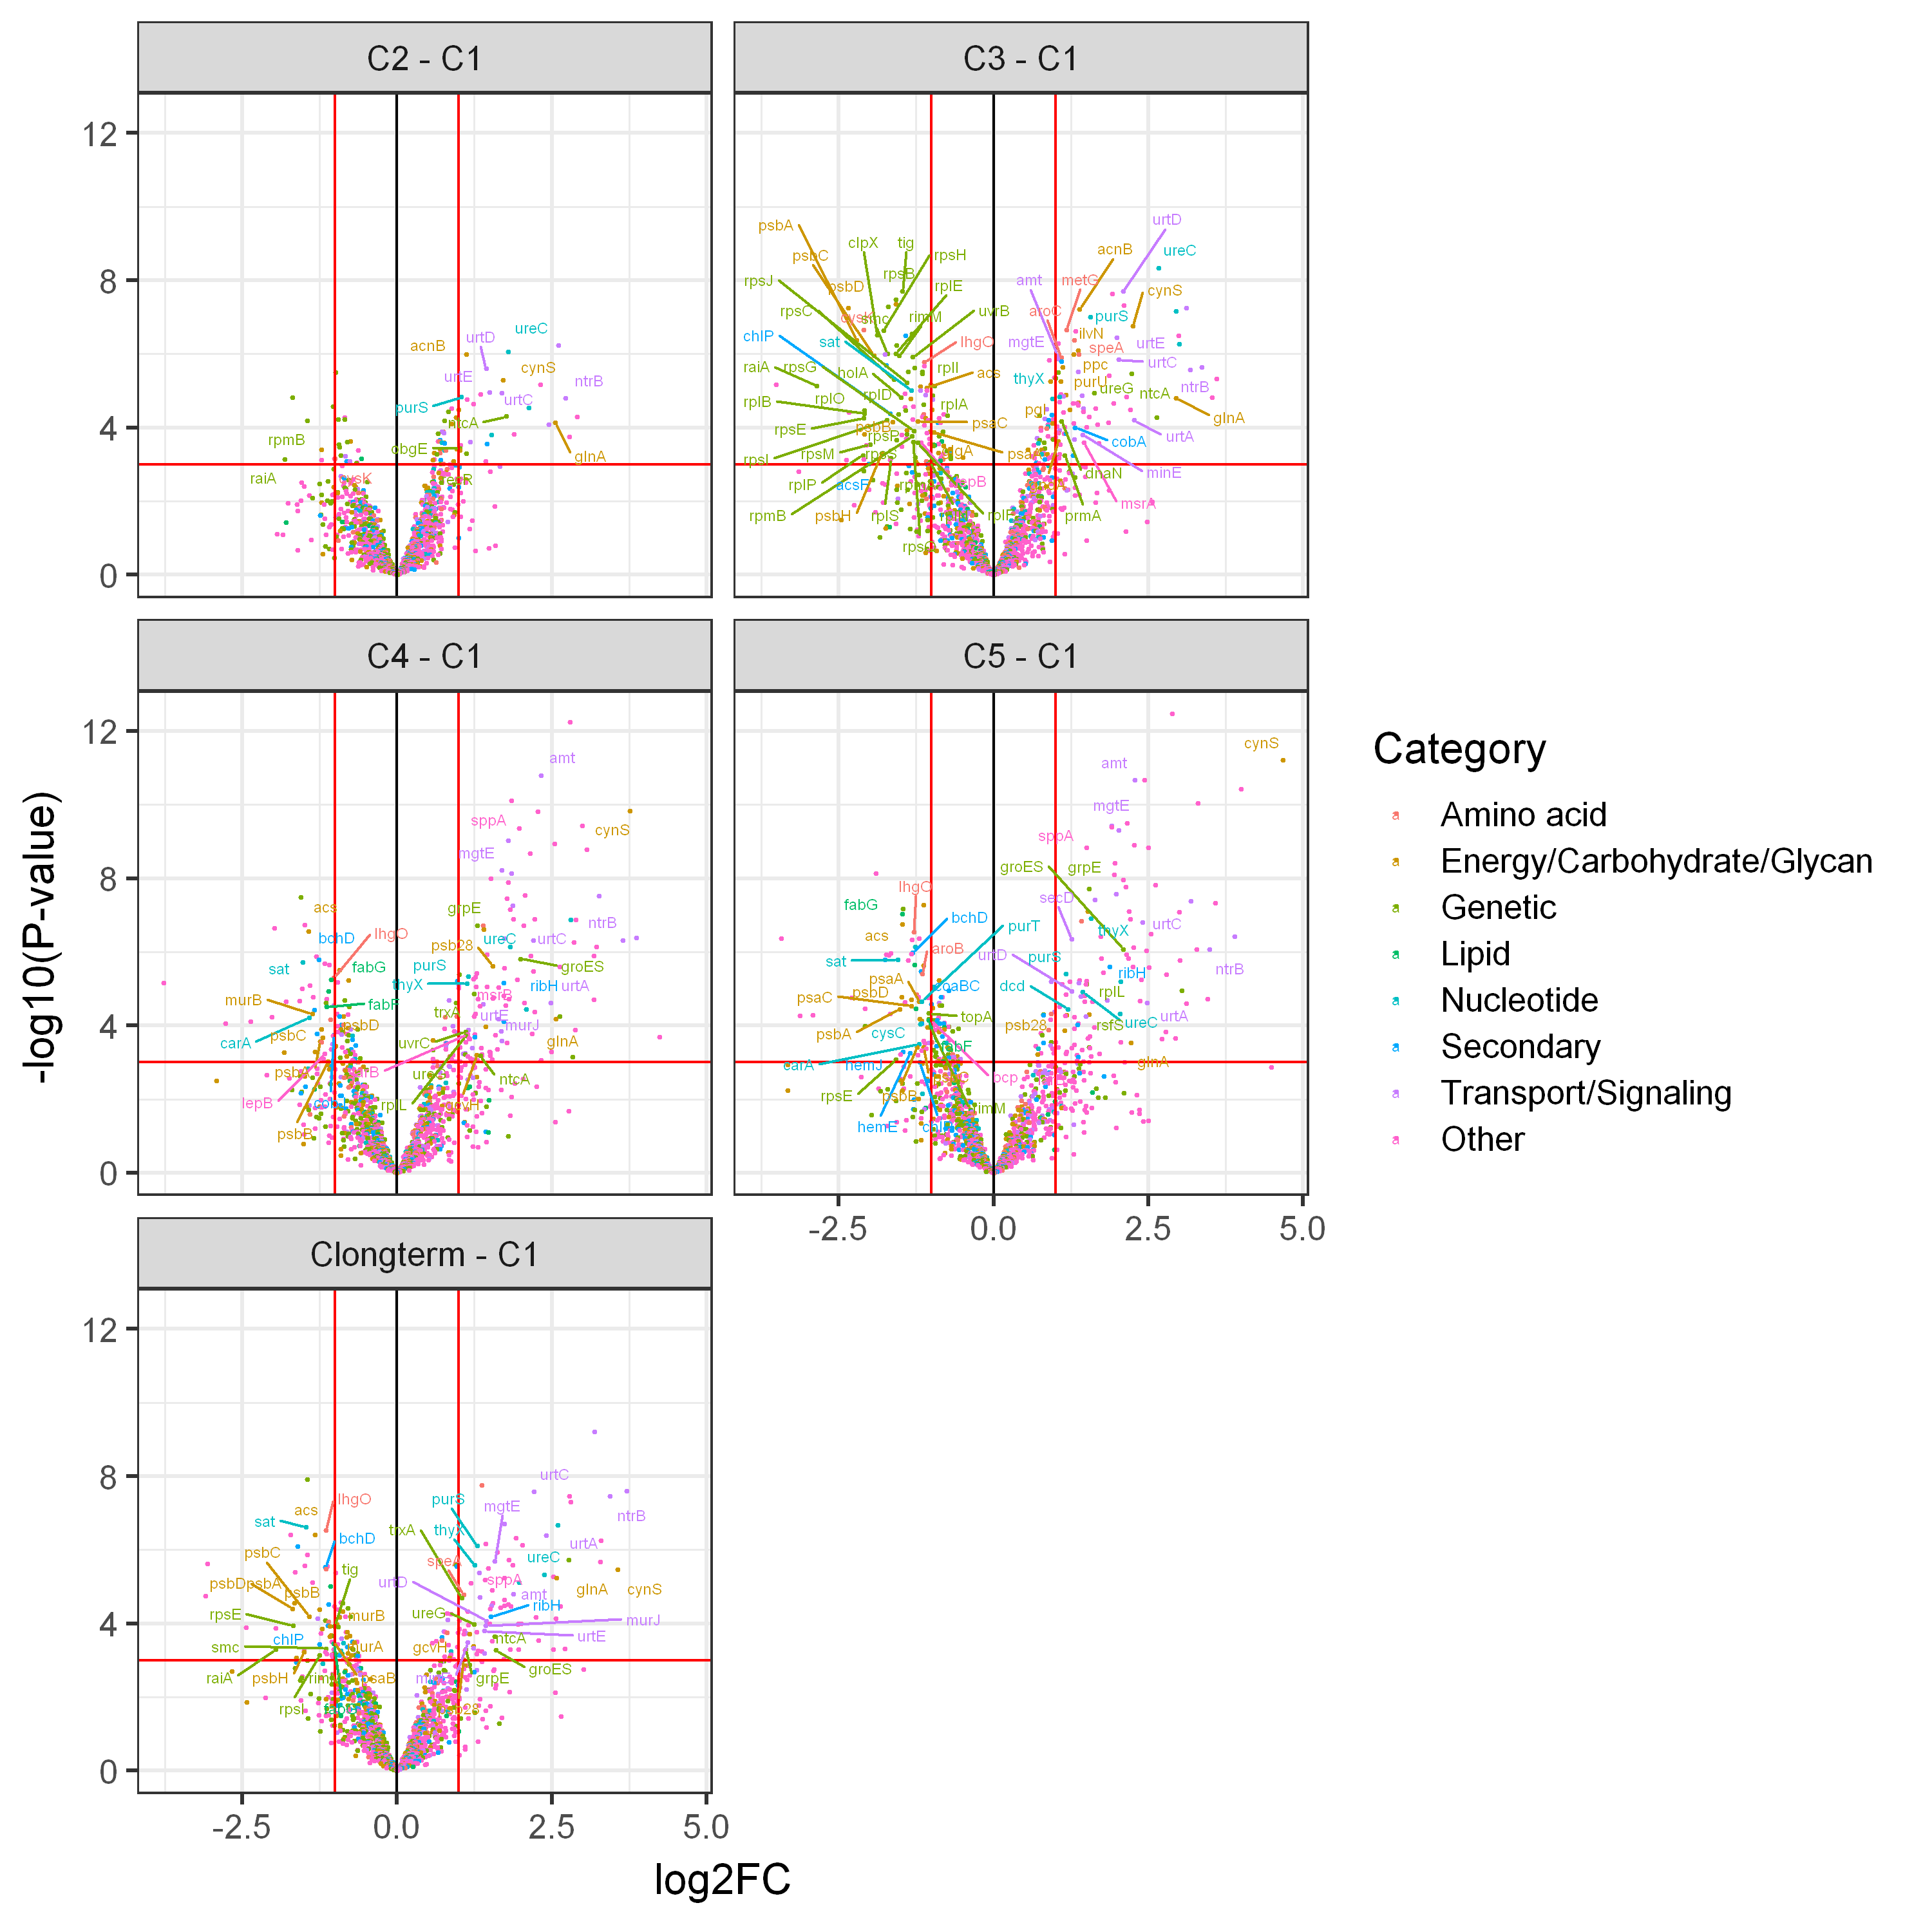

In [115]:
library(ggrepel)
# Use ggplot2 allows more flexibility in plotting

C.results$log.sca.pval = -log10(C.results$sca.P.Value)
ggplot(C.results, aes(x = logFC, y =log.sca.pval, color=Category )) + 
    geom_point(size=0.5 )+
    theme_bw(base_size = 16) + # change theme
    xlab(expression("log2FC")) + # x-axis label
    ylab(expression(" -log10(P-value)")) + # y-axis label
    geom_vline(xintercept = c(-1,1), colour = "red") + # Add fold change cutoffs
    geom_hline(yintercept = 3, colour = "red") + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black") + # Add 0 lines
    #scale_colour_gradient(low = "black", high = "black", guide = 'none')+
    geom_text_repel(data=subset(C.results, abs(logFC)>1&log.sca.pval > 3),
                    aes( logFC, log.sca.pval ,label=gene.y), max.overlaps = Inf,size=2)  + # add gene label
    facet_wrap(~contrast, ncol=2)

# Limma - CC PRO longterm 

In [85]:
cdf = mdf %>% filter(Group == 'C') %>%
pivot_wider(id_cols=c('protein_id'), 
    names_from='Sample', values_from = 'Intensity') %>% column_to_rownames('protein_id')

head(cdf)

C1_1     C1_2     C1_3     C2_1     C2_2     C2_3     C3_1    
WP_036930312.1 4.315192 3.904885 5.643631 6.592691 6.199080 6.069427 7.060764
WP_011132553.1 3.012233 2.490735 5.221550 6.429291 5.938936 6.009636 6.731760
WP_011133065.1 6.097384 7.786138 8.062645 7.142181 7.485416 7.019489 7.381798
WP_002805854.1 5.676785 5.820374 5.627089 5.524055 5.622326 5.657085 6.047516
WP_011133136.1 6.456103 6.871163 6.935638 6.593880 6.829687 6.576691 6.343586
WP_011133111.1 4.967328 5.436225 5.507900 5.092224 5.207661 4.755415 4.856405
               C3_2     C3_3     C4_1     C4_2     C4_3     C5_1     C5_2    
WP_036930312.1 6.669080 6.943257 7.363750 7.065671 6.874102 6.949040 6.998334
WP_011132553.1 6.419105 6.410733 6.177835 6.141454 6.116852 5.814738 5.596951
WP_011133065.1 7.382258 7.379933 7.442105 7.240170 7.172518 6.933459 7.373826
WP_002805854.1 6.028348 6.140056 7.355660 7.056380 6.902369 7.135177 7.320560
WP_011133136.1 6.008561 6.145251 6.628970 6.361516 6.209372 6.304336 6.273396
WP_011133111.1 4.556363 4.772334 5.145514 4.894708 4.929260 4.845759 4.710584
               C5_3    
WP_036930312.1 7.350987
WP_011132553.1 5.960504
WP_011133065.1 7.659724
WP_002805854.1 7.245799
WP_011133136.1 6.621615
WP_011133111.1 5.266555

In [86]:
num_unique = mdf %>% filter(Group == 'C') %>% 
    distinct(protein_id, Number.of.Unique.Peptides) %>% column_to_rownames('protein_id')

In [87]:
n =substr(names(cdf), 2,2)
n[n %in% c('3', '4', '5')] = 'longterm'
C = as.factor(n)
design = model.matrix(~0+C) # fitting without intercept
design

C1 C2 Clongterm
1  1  0  0        
2  1  0  0        
3  1  0  0        
4  0  1  0        
5  0  1  0        
6  0  1  0        
7  0  0  1        
8  0  0  1        
9  0  0  1        
10 0  0  1        
11 0  0  1        
12 0  0  1        
13 0  0  1        
14 0  0  1        
15 0  0  1

In [88]:
fit1 = lmFit(cdf,design = design)
cont <- makeContrasts(Clongterm-C1, levels = design)
fit2 = contrasts.fit(fit1,contrasts = cont)
fit3 <- eBayes(fit2)

In [89]:
fit3$count = num_unique[rownames(fit3$coefficients),"Number.of.Unique.Peptides"]

#check the values in the vector fit3$count
#if min(fit3$count) return NA or 0, you should troubleshoot the error first
min(fit3$count)

[1] 1

In [90]:
fit4 = spectraCounteBayes(fit3)

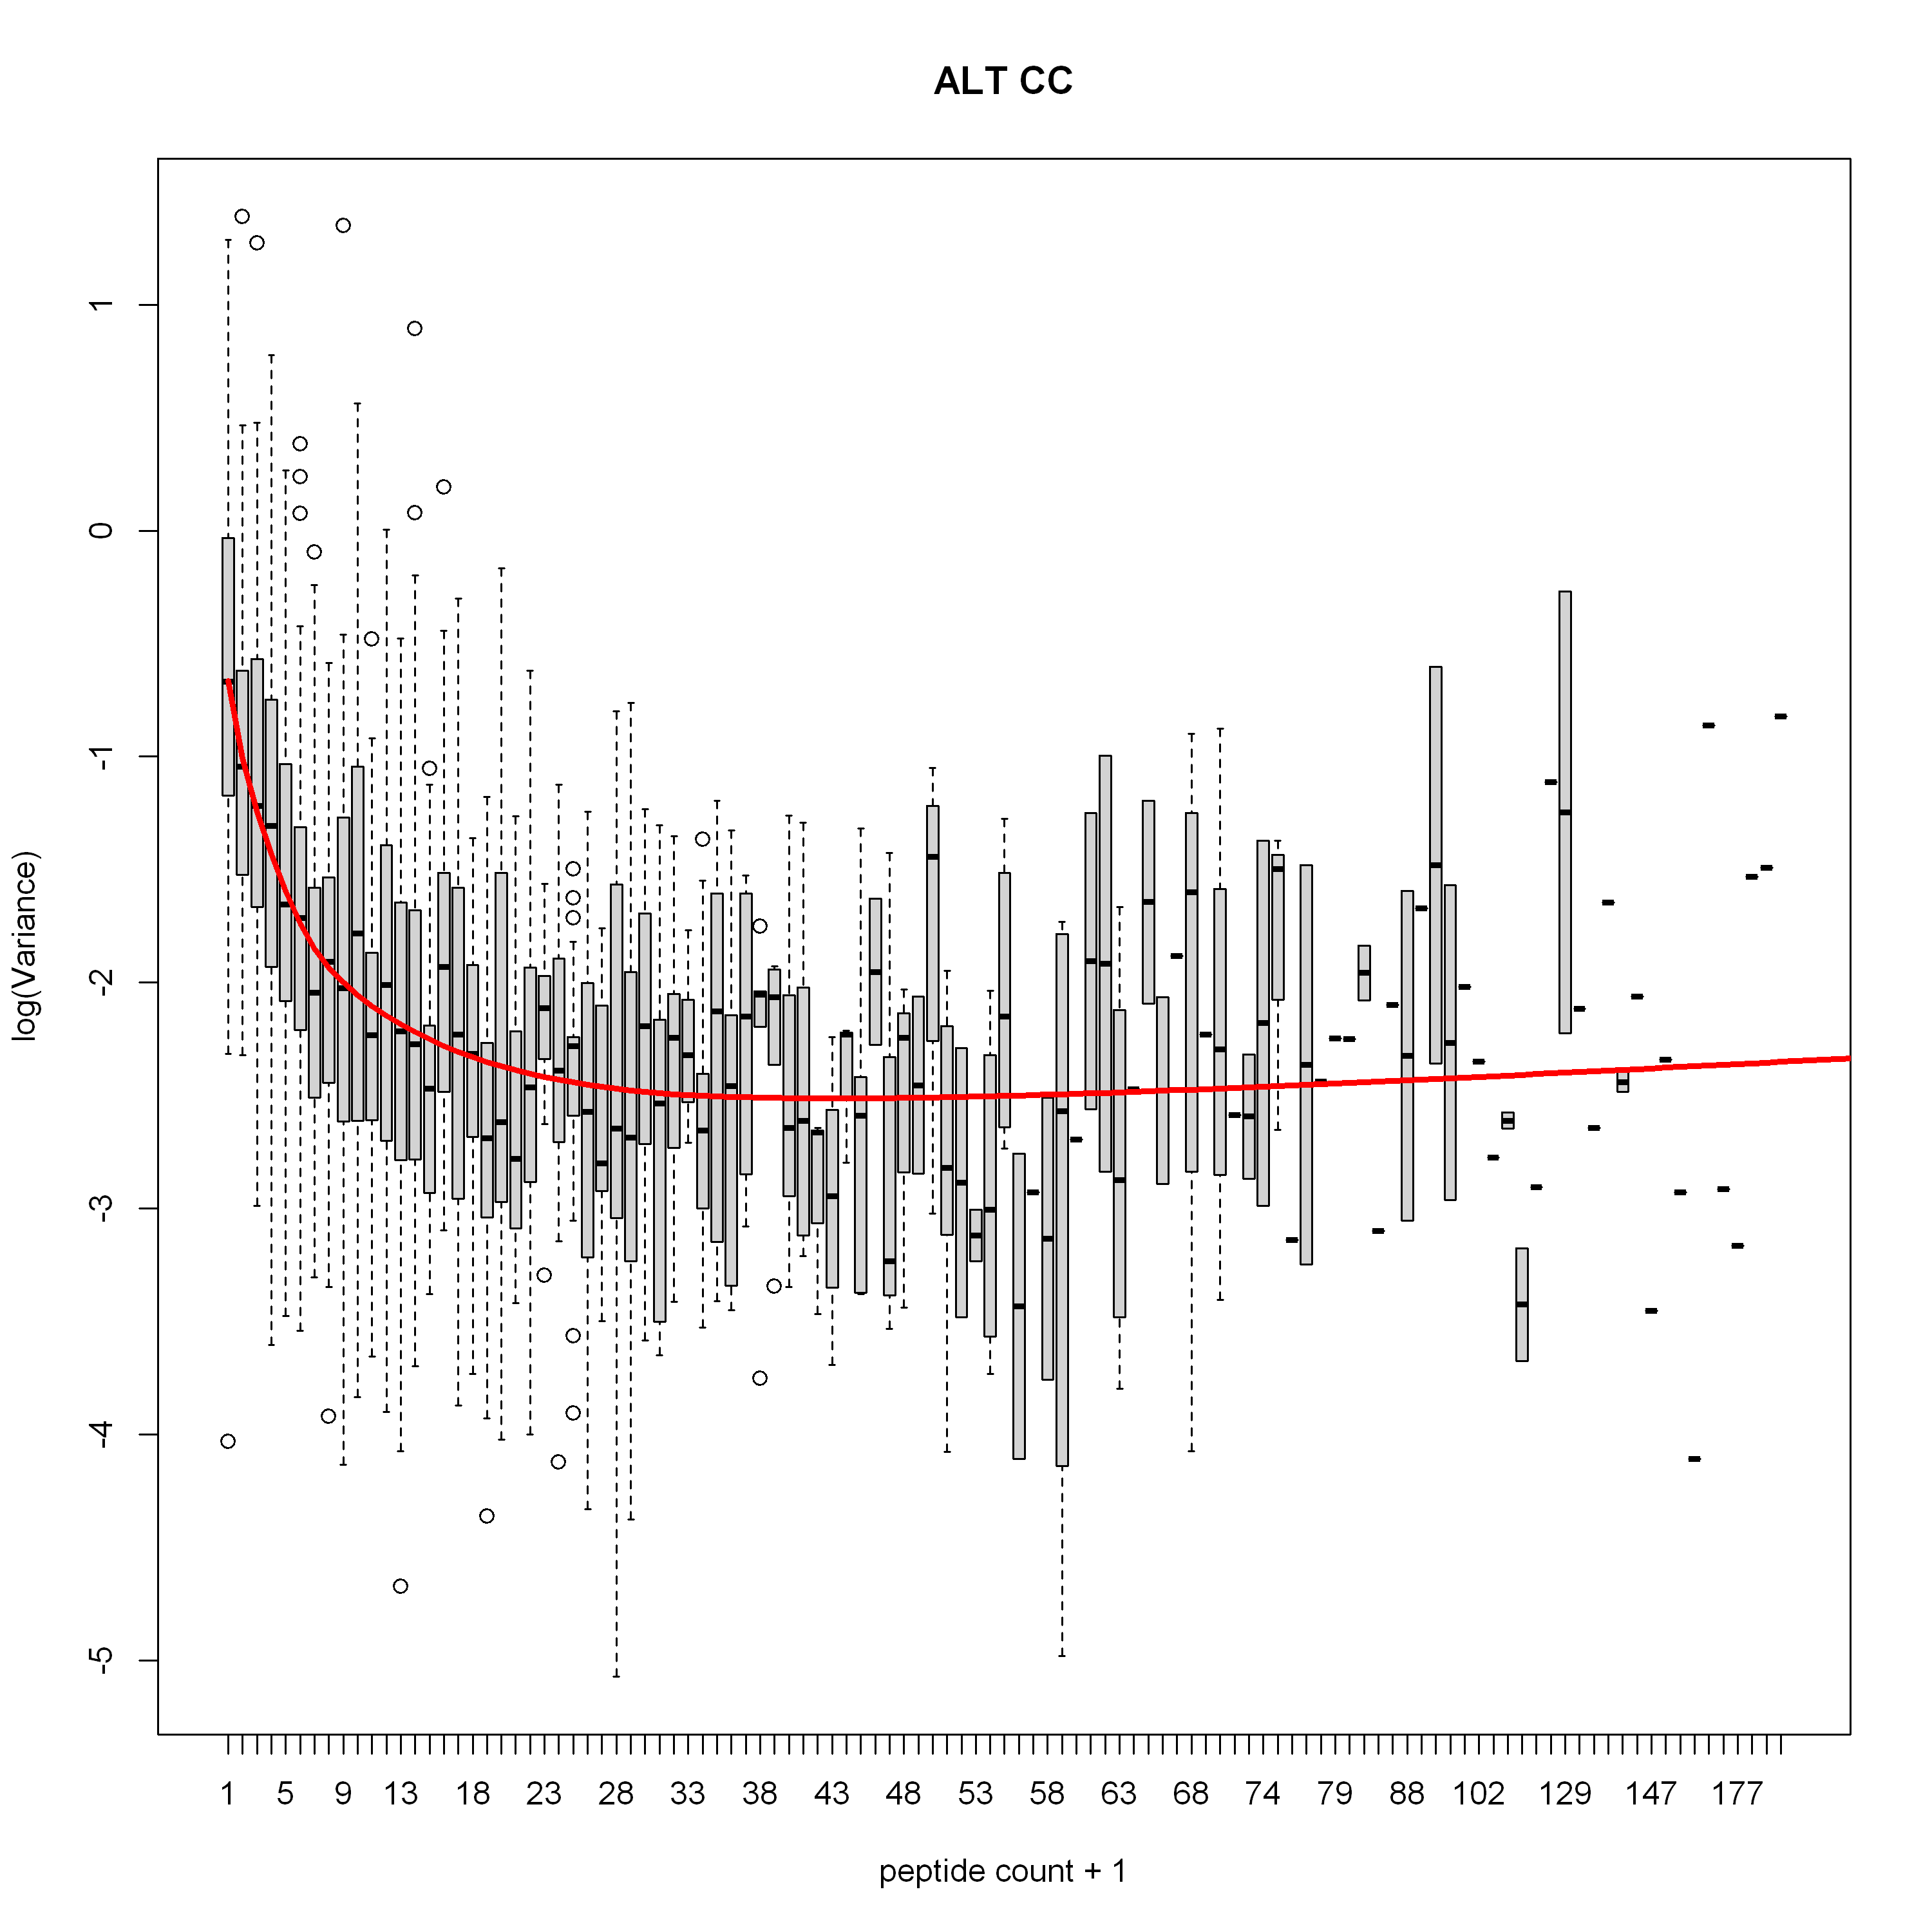

In [91]:
VarianceBoxplot(fit4, n=500, main = "ALT CC",
                xlab="peptide count + 1")

In [92]:
colnames(fit4$coefficients)

[1] "Clongterm - C1"

In [93]:
Clt.results = outputResult(fit4,coef_col = 1) %>% mutate(contrast = 'Clongterm - C1')

In [94]:
Clt.results = left_join(Clt.results, hpath_df_to_export, by=c(gene='protein_id'))

In [95]:
C.results = bind_rows(C.results, Clt.results)

In [112]:
C.results  = C.results %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 
C.results$Category = factor(C.results$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))
my.cols <- c(brewer.pal(7, "Set2"), 'grey34')

In [107]:
Clt.results  = Clt.results %>% 
    mutate(Category = case_when(
           grepl('09103 Lipid metabolism', sub)~'Lipid',
           grepl('09131 Membrane transport', sub)~'Transport/Signaling',
           grepl('09104 Nucleotide metabolism', sub)~'Nucleotide',
           grepl('09101 Carbohydrate metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09105 Amino acid metabolism', sub)~'Amino acid',
           grepl('09106 Metabolism of other amino acids', sub)~'Amino acid',
            
           grepl('09108 Metabolism of cofactors and vitamins', sub)~'Secondary',
           grepl('09107 Glycan biosynthesis and metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09109 Metabolism of terpenoids and polyketides', sub)~'Secondary',

           grepl('09183 Protein families: signaling and cellular processes', sub)~'Transport/Signaling',
           grepl('09193 Unclassified: signaling and cellular processes', sub)~'Transport/Signaling',
        
           grepl('09182 Protein families: genetic information processing', sub)~'Genetic',
           grepl('09192 Unclassified: genetic information processing', sub)~'Genetic',
        
           grepl('09102 Energy metabolism', sub)~'Energy/Carbohydrate/Glycan',
           grepl('09124 Replication and repair', sub)~'Replication',
        
            TRUE~'Other'
           )) 
Clt.results$Category = factor(Clt.results$Category, levels = c("Amino acid", "Energy/Carbohydrate/Glycan", 
"Genetic", "Lipid", "Nucleotide",  "Secondary", "Transport/Signaling", "Other"))
my.cols <- c(brewer.pal(7, "Set2"), 'grey34')

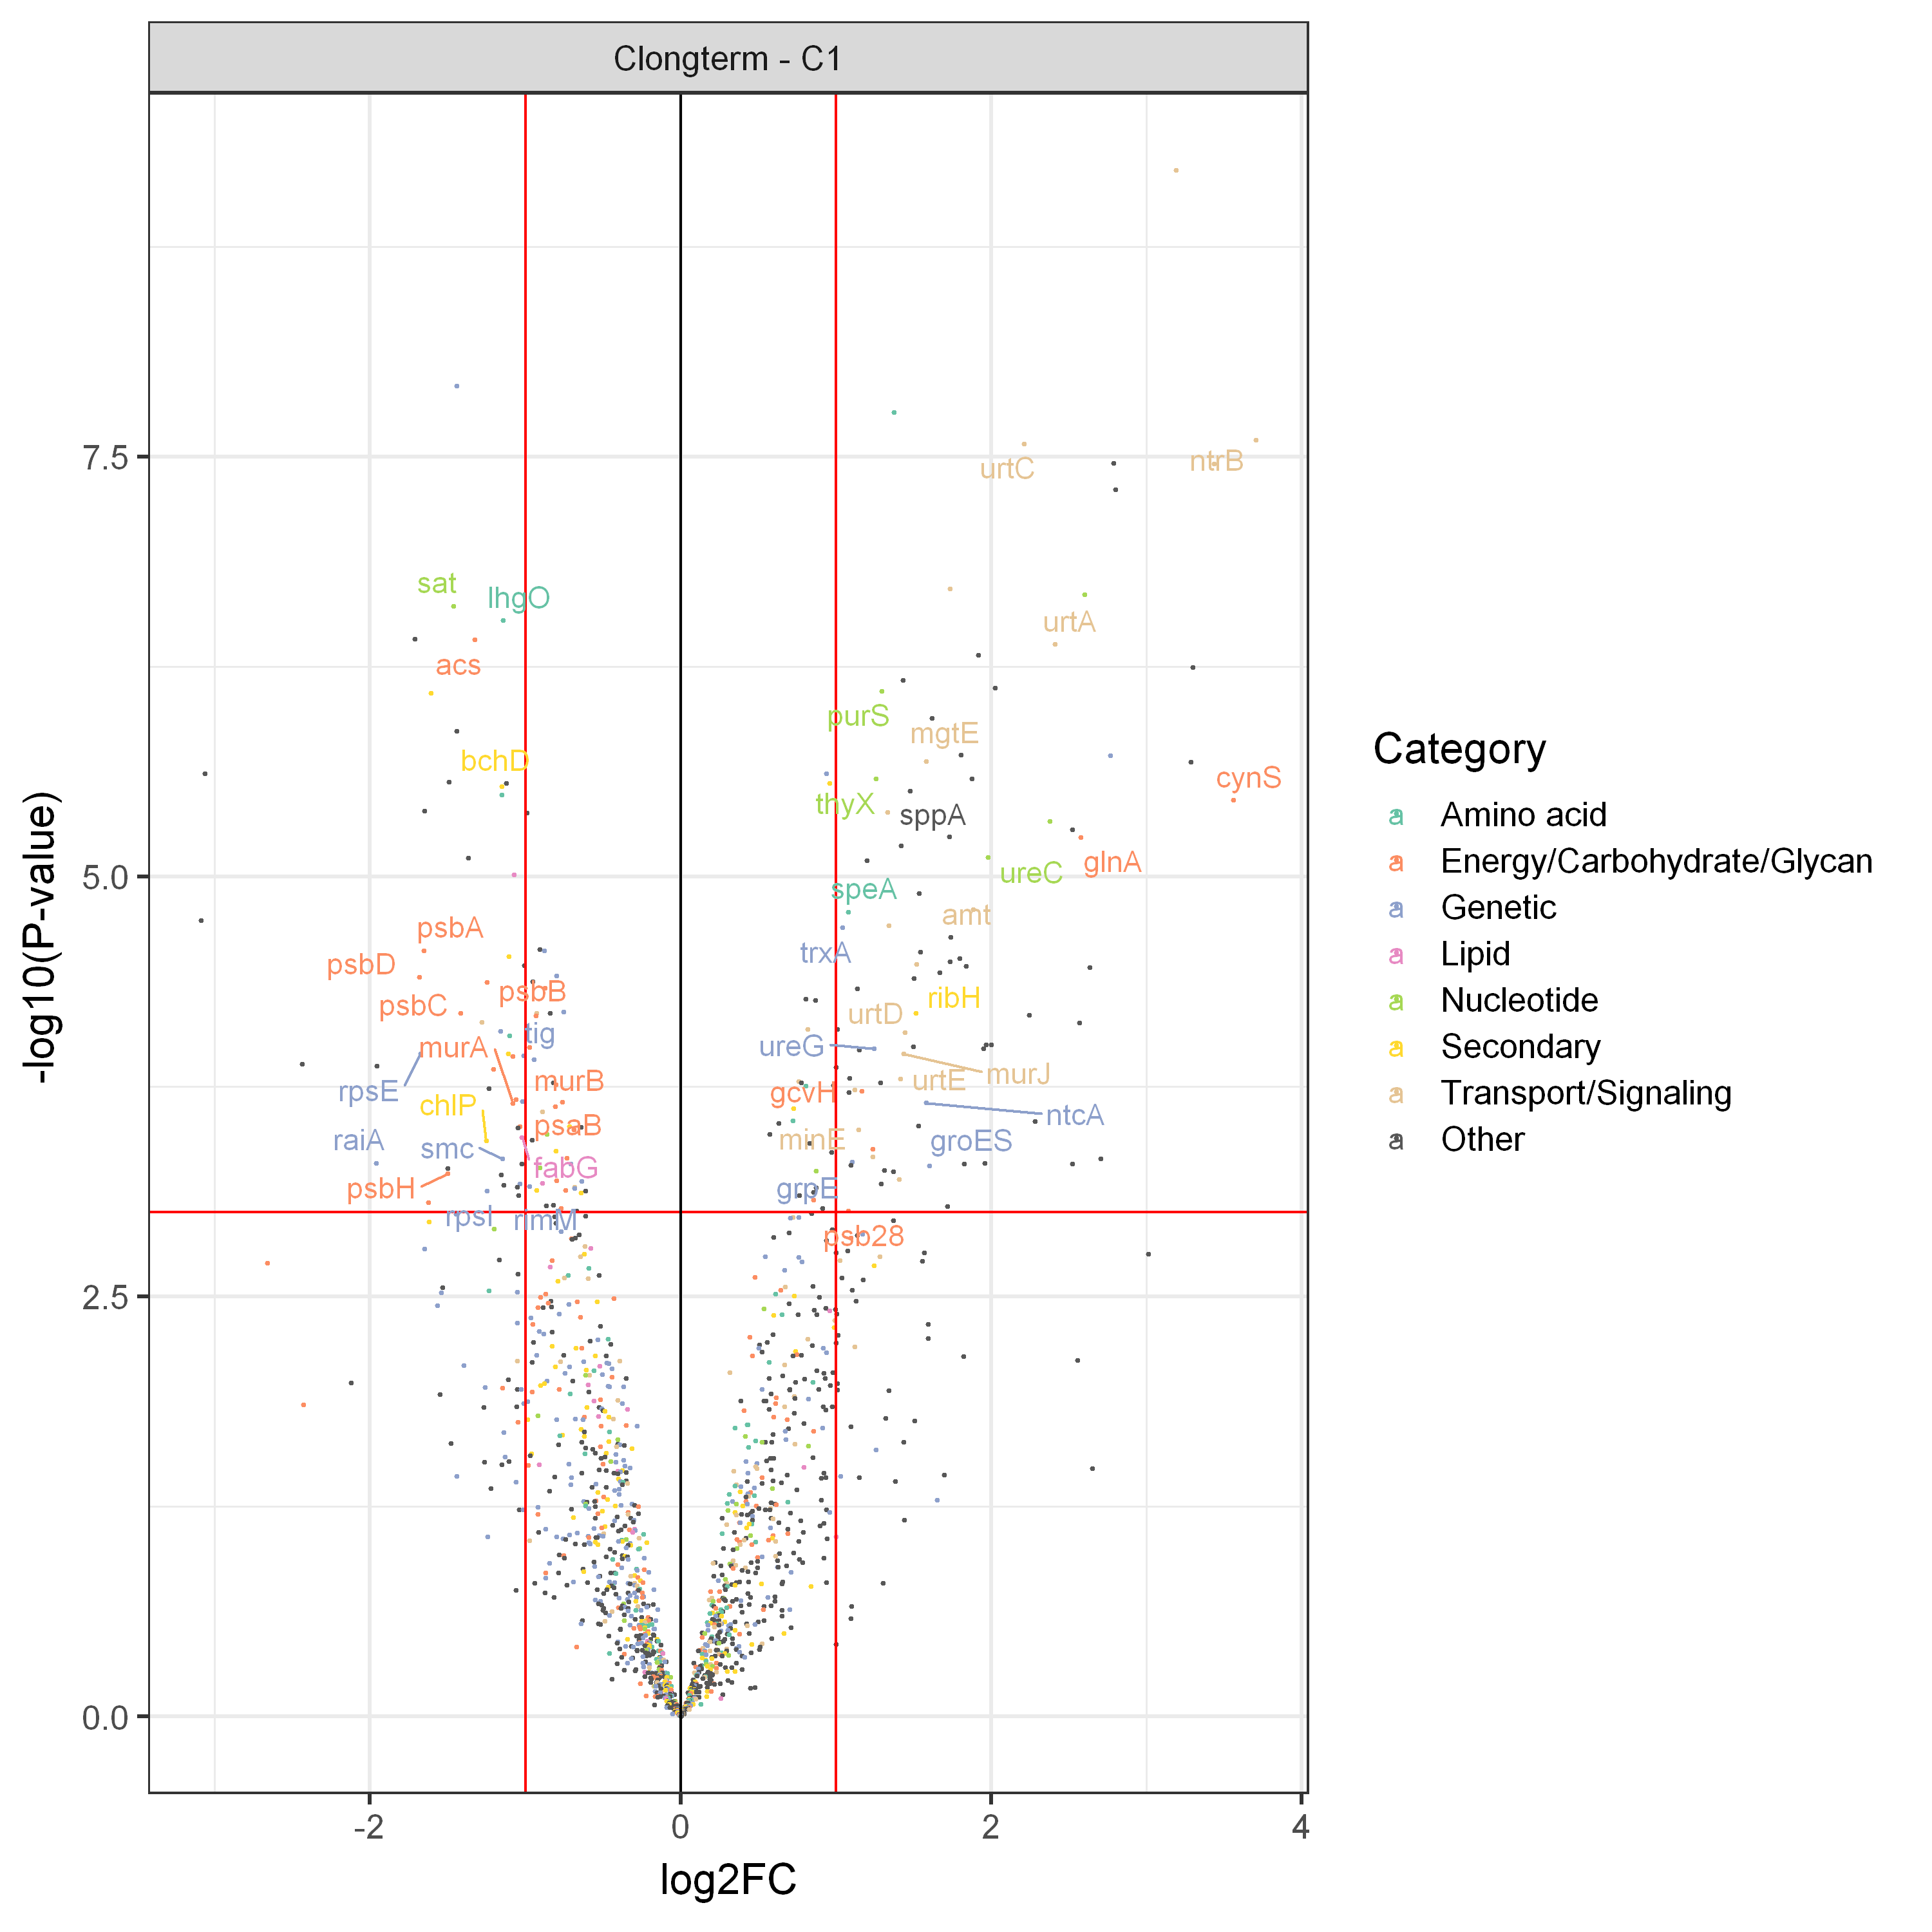

In [108]:
library(ggrepel)
# Use ggplot2 allows more flexibility in plotting

Clt.results$log.sca.pval = -log10(Clt.results$sca.P.Value)
ggplot(Clt.results, aes(x = logFC, y =log.sca.pval, color=Category )) + 
    geom_point(size=0.5 )+
    theme_bw(base_size = 16) + # change theme
    xlab(expression("log2FC")) + # x-axis label
    ylab(expression(" -log10(P-value)")) + # y-axis label
    geom_vline(xintercept = c(-1,1), colour = "red") + # Add fold change cutoffs
    geom_hline(yintercept = 3, colour = "red") + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black") + # Add 0 lines
    scale_colour_manual(values = my.cols)+
    geom_text_repel(data=subset(Clt.results, abs(logFC)>1&log.sca.pval > 3),
                    aes( logFC, log.sca.pval ,label=gene.y), max.overlaps = Inf)  + # add gene label
    facet_wrap(~contrast, ncol=2)

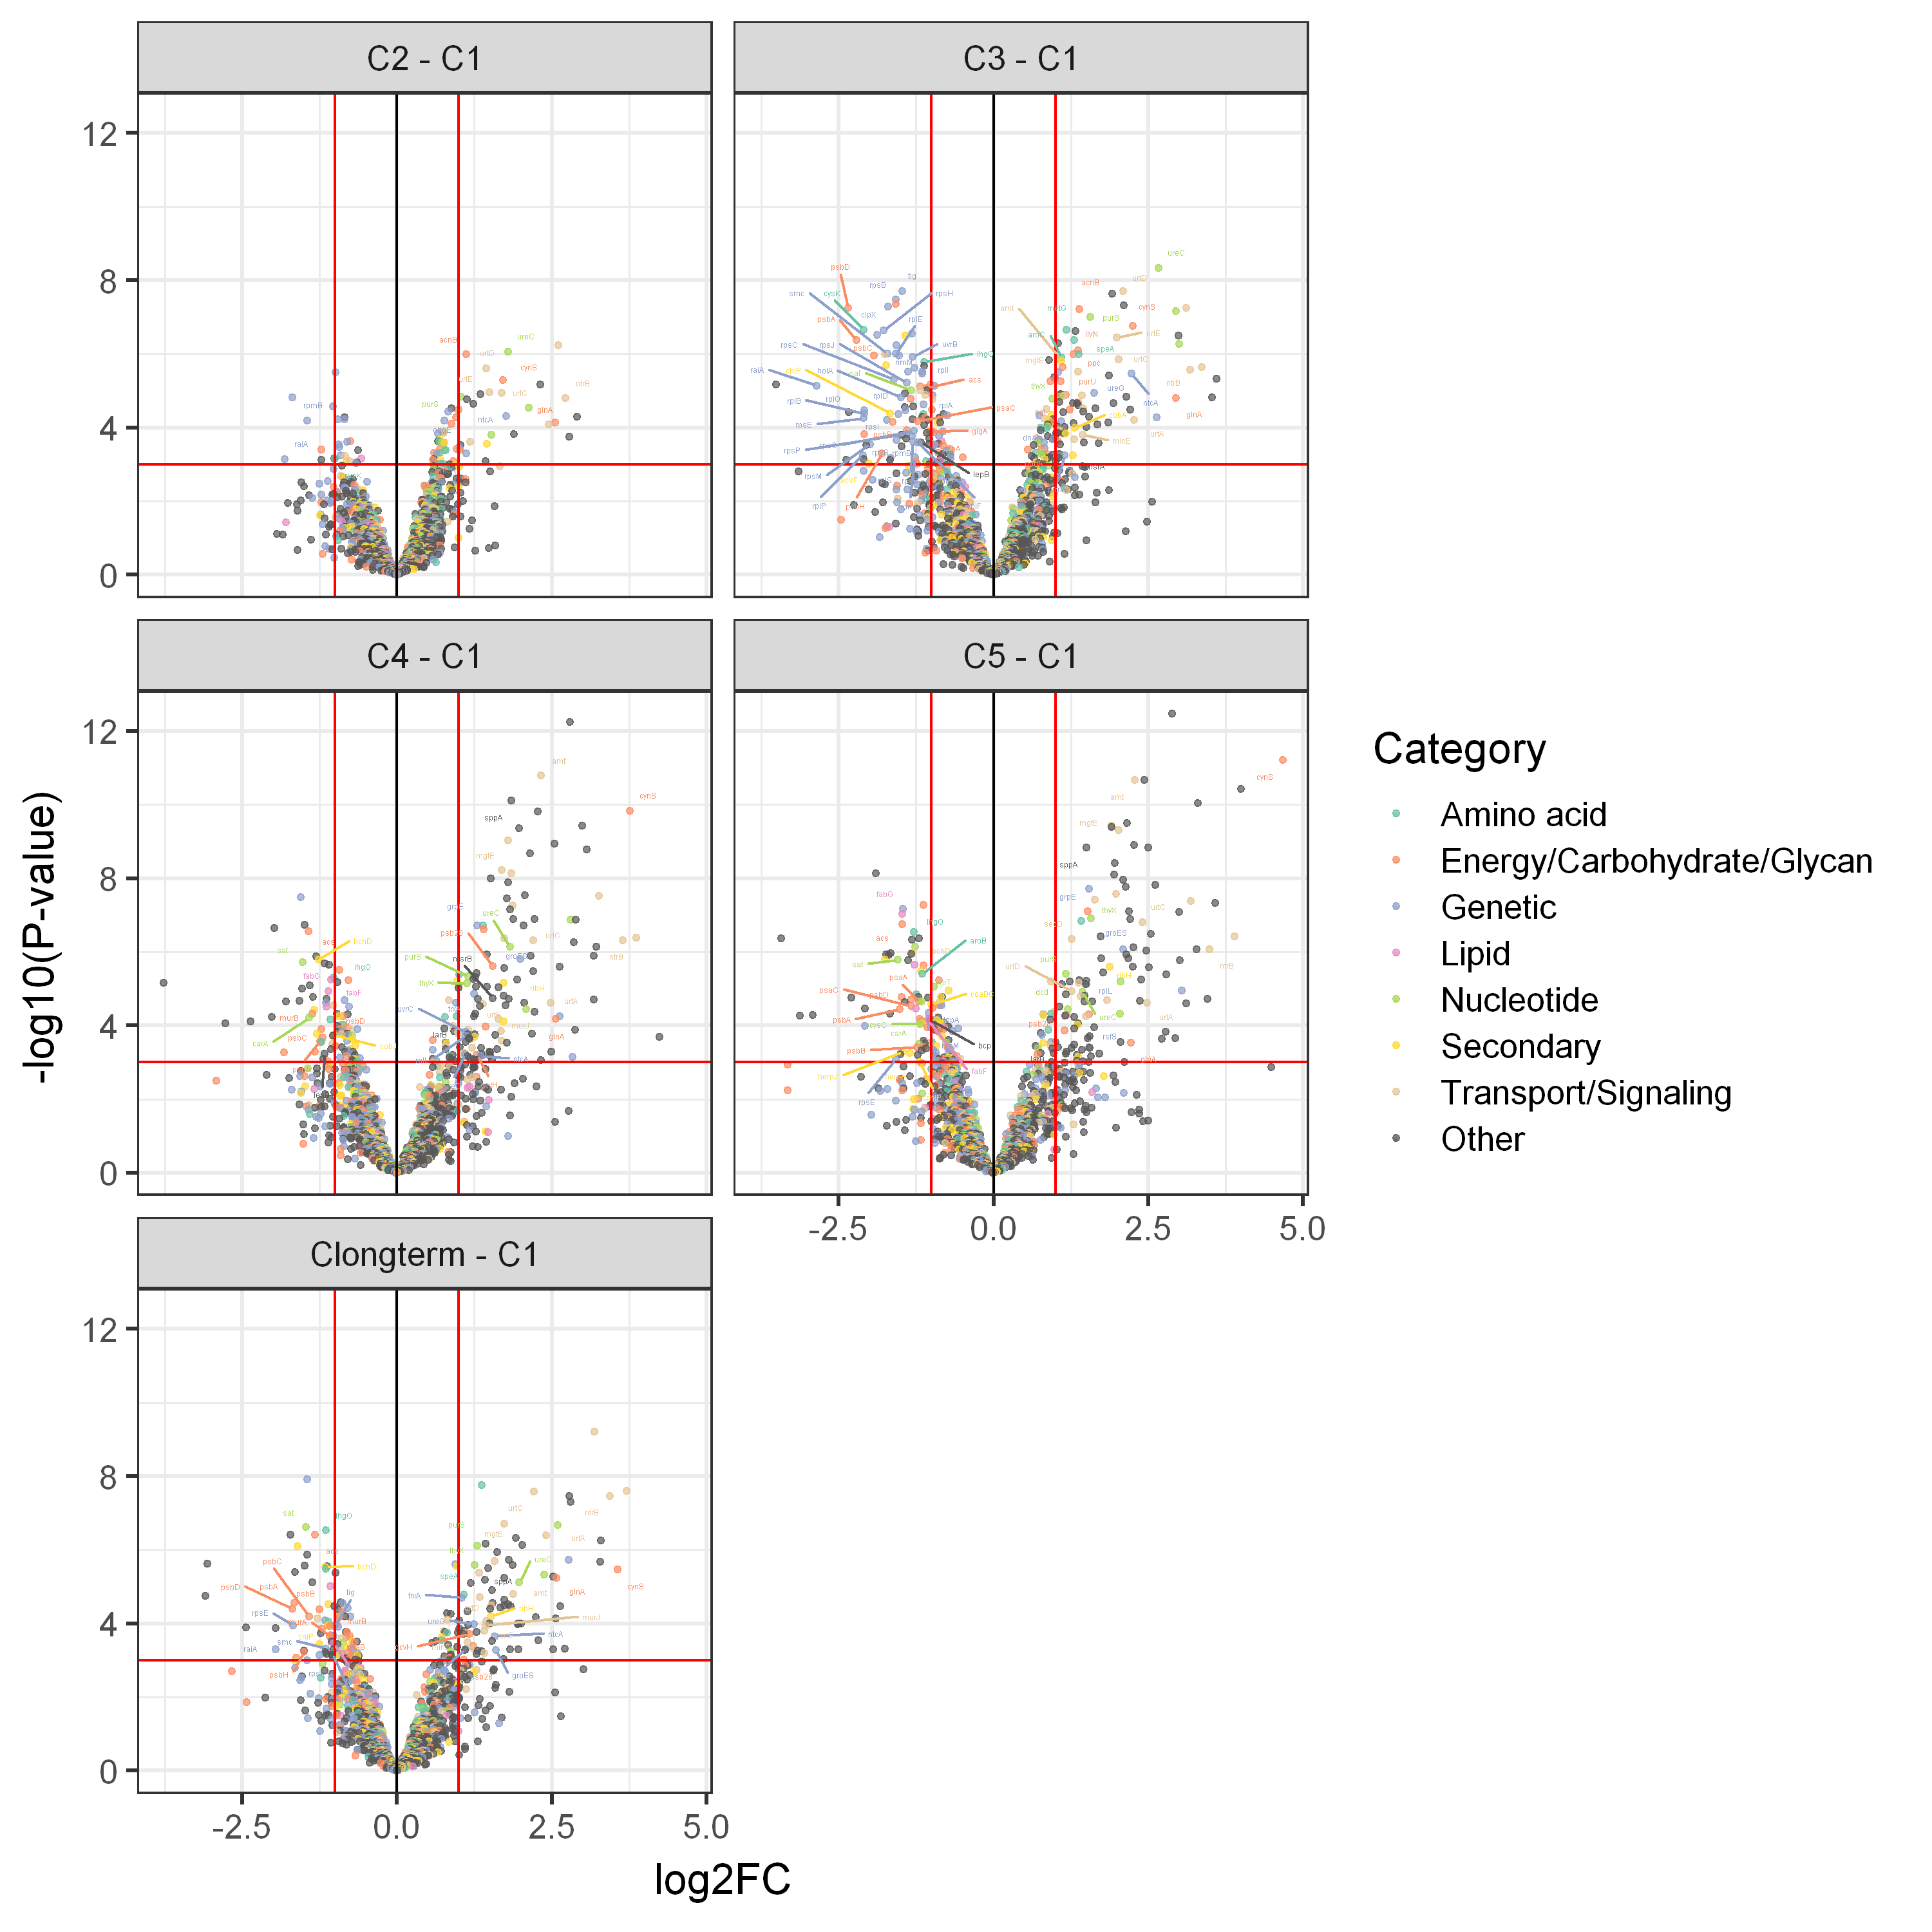

In [114]:
library(ggrepel)
# Use ggplot2 allows more flexibility in plotting

C.results$log.sca.pval = -log10(C.results$sca.P.Value)
ggplot(C.results, aes(x = logFC, y =log.sca.pval, color=Category )) + 
    geom_point(size=1, alpha=0.7 )+
    theme_bw(base_size = 16) + # change theme
    xlab(expression("log2FC")) + # x-axis label
    ylab(expression(" -log10(P-value)")) + # y-axis label
    geom_vline(xintercept = c(-1,1), colour = "red") + # Add fold change cutoffs
    geom_hline(yintercept = 3, colour = "red") + # Add significance cutoffs
    geom_vline(xintercept = 0, colour = "black") + # Add 0 lines
    scale_colour_manual(values = my.cols)+
    geom_text_repel(data=subset(C.results, abs(logFC)>1&log.sca.pval > 3),
                    aes( logFC, log.sca.pval ,label=gene.y), max.overlaps = Inf, size=1)  + # add gene label
    facet_wrap(~contrast, ncol=2)

In [99]:
write.csv(P.results, file.path('data', 'PRO_Axenic_DE.csv'))
write.csv(C.results, file.path('data', 'PRO_CC_DE.csv'))
